In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, roc_curve, auc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import sklearn.neighbors._base
from numpy import where
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.metrics import confusion_matrix

In [2]:
# Importation du package
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('preprocessing_train.csv')
df_test = pd.read_csv('preprocessing_test.csv')

In [4]:
best_features = pd.read_csv('best_fetaures.csv')
feats = best_features['feature'].unique()
feats = np.append(feats,'INTERET_CUMULE' )

# Features

In [86]:
best_features.sort_values('importance',ascending=False)

,feature,importance,fold
320,PAYMENT_RATE,3927,4
112,EXT_SOURCE_2,3926,2
413,EXT_SOURCE_3,3900,5
313,EXT_SOURCE_3,3891,4
212,EXT_SOURCE_2,3853,3
...,...,...,...
290,INSTAL_PAYMENT_PERC_VAR,1022,3
459,PREV_AMT_CREDIT_MEAN,1019,5
469,PREV_NAME_TYPE_SUITE_nan_MEAN,994,5
272,APPROVED_AMT_ANNUITY_MAX,979,3


In [87]:
best_features[best_features['feature'] == 'AMT_INCOME_TOTAL']

,feature,importance,fold
0,AMT_INCOME_TOTAL,1473,1
100,AMT_INCOME_TOTAL,1311,2
200,AMT_INCOME_TOTAL,1324,3
300,AMT_INCOME_TOTAL,1301,4
400,AMT_INCOME_TOTAL,1395,5


In [ ]:
df['TARGET']

In [7]:
df[feats].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 101 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    AMT_INCOME_TOTAL                         float64
 1    AMT_CREDIT                               float64
 2    AMT_ANNUITY                              float64
 3    AMT_GOODS_PRICE                          float64
 4    REGION_POPULATION_RELATIVE               float64
 5    DAYS_BIRTH                               int64  
 6    DAYS_EMPLOYED                            float64
 7    DAYS_REGISTRATION                        float64
 8    DAYS_ID_PUBLISH                          int64  
 9    OWN_CAR_AGE                              float64
 10   HOUR_APPR_PROCESS_START                  int64  
 11   EXT_SOURCE_1                             float64
 12   EXT_SOURCE_2                             float64
 13   EXT_SOURCE_3                             float64
 14   TO

# Preprocessing

In [88]:
#df = df[0:10000]

In [89]:
df = df[df['TARGET'].notnull()]

# Sélectionner les colonnes de type int et float
numeric_columns = df[feats].select_dtypes(include=['int', 'float']).columns

# Initialiser le MinMaxScaler
scaler = MinMaxScaler()

# Normaliser les colonnes sélectionnées
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

median_values = df[feats].median()

# Imputer les valeurs manquantes avec la médiane
df.fillna(median_values, inplace=True) 

X = df[feats]

y = df['TARGET']

# Diviser l'ensemble de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Diviser X_temp et y_temp pour obtenir le X_validation, y_validation, X_test, y_test
X_hide_test, X_test, y_hide_test, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [90]:
print(X_train.shape)
print(X_test.shape)
print(X_hide_test.shape)

(215254, 101)
(46127, 101)
(46126, 101)


# Score AUC

In [91]:
from sklearn.metrics import roc_auc_score

clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='auc')
proba_preds= clf.predict_proba(X_hide_test)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/work/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.714124	training's binary_logloss: 0.279387
[2]	training's auc: 0.715768	training's binary_logloss: 0.278305
[3]	training's auc: 0.717634	training's binary_logloss: 0.27728
[4]	training's auc: 0.720066	training's binary_logloss: 0.276315
[5]	training's auc: 0.721276	training's binary_logloss: 0.275401
[6]	training's auc: 0.721519	training's binary_logloss: 0.274538
[7]	training's auc: 0.722342	training's binary_logloss: 0.273717
[8]	training's auc: 0.723545	training's binary_logloss: 0.272926
[9]	training's auc: 0.724566	training's binary_logloss: 0.272165
[10]	training's auc: 0.725684	training's binary_logloss: 0.271441
[11]	training's auc: 0.726745	training's binary_logloss: 0.270741
[12]	training's auc: 0.728208	training's binary_logloss: 0.270064
[13]	training's auc: 0.73123	training's binary_logloss: 0.269498
[14]	training's auc: 0.73324	training's binary_logloss: 0.268954
[15]	training's auc: 0.733857	training's binary_logloss: 0.26835
[16]	training's auc: 0.

[126]	training's auc: 0.775634	training's binary_logloss: 0.243585
[127]	training's auc: 0.775873	training's binary_logloss: 0.243486
[128]	training's auc: 0.77608	training's binary_logloss: 0.243389
[129]	training's auc: 0.776322	training's binary_logloss: 0.243293
[130]	training's auc: 0.776657	training's binary_logloss: 0.243177
[131]	training's auc: 0.776874	training's binary_logloss: 0.243083
[132]	training's auc: 0.777099	training's binary_logloss: 0.24299
[133]	training's auc: 0.77738	training's binary_logloss: 0.24289
[134]	training's auc: 0.777654	training's binary_logloss: 0.242795
[135]	training's auc: 0.777853	training's binary_logloss: 0.242705
[136]	training's auc: 0.778087	training's binary_logloss: 0.242601
[137]	training's auc: 0.778336	training's binary_logloss: 0.242506
[138]	training's auc: 0.778642	training's binary_logloss: 0.2424
[139]	training's auc: 0.778919	training's binary_logloss: 0.242303
[140]	training's auc: 0.779139	training's binary_logloss: 0.242207
[

[250]	training's auc: 0.797229	training's binary_logloss: 0.23492
[251]	training's auc: 0.797346	training's binary_logloss: 0.234869
[252]	training's auc: 0.79747	training's binary_logloss: 0.234823
[253]	training's auc: 0.797599	training's binary_logloss: 0.234773
[254]	training's auc: 0.79771	training's binary_logloss: 0.23473
[255]	training's auc: 0.797839	training's binary_logloss: 0.234675
[256]	training's auc: 0.797958	training's binary_logloss: 0.234626
[257]	training's auc: 0.798083	training's binary_logloss: 0.234583
[258]	training's auc: 0.798213	training's binary_logloss: 0.234529
[259]	training's auc: 0.798356	training's binary_logloss: 0.234477
[260]	training's auc: 0.798452	training's binary_logloss: 0.234432
[261]	training's auc: 0.798553	training's binary_logloss: 0.234388
[262]	training's auc: 0.798677	training's binary_logloss: 0.234336
[263]	training's auc: 0.798799	training's binary_logloss: 0.234287
[264]	training's auc: 0.798895	training's binary_logloss: 0.234242

[374]	training's auc: 0.810837	training's binary_logloss: 0.229584
[375]	training's auc: 0.81095	training's binary_logloss: 0.229546
[376]	training's auc: 0.81103	training's binary_logloss: 0.229514
[377]	training's auc: 0.811135	training's binary_logloss: 0.22948
[378]	training's auc: 0.811234	training's binary_logloss: 0.229436
[379]	training's auc: 0.811356	training's binary_logloss: 0.229389
[380]	training's auc: 0.81146	training's binary_logloss: 0.229348
[381]	training's auc: 0.811573	training's binary_logloss: 0.229311
[382]	training's auc: 0.811672	training's binary_logloss: 0.229274
[383]	training's auc: 0.811737	training's binary_logloss: 0.22925
[384]	training's auc: 0.811849	training's binary_logloss: 0.229209
[385]	training's auc: 0.811945	training's binary_logloss: 0.229172
[386]	training's auc: 0.812033	training's binary_logloss: 0.229138
[387]	training's auc: 0.812086	training's binary_logloss: 0.229112
[388]	training's auc: 0.812169	training's binary_logloss: 0.22908
[

[500]	training's auc: 0.822372	training's binary_logloss: 0.225287
[501]	training's auc: 0.822412	training's binary_logloss: 0.225273
[502]	training's auc: 0.8225	training's binary_logloss: 0.225241
[503]	training's auc: 0.822573	training's binary_logloss: 0.225211
[504]	training's auc: 0.822675	training's binary_logloss: 0.225177
[505]	training's auc: 0.822748	training's binary_logloss: 0.225146
[506]	training's auc: 0.822851	training's binary_logloss: 0.225108
[507]	training's auc: 0.82296	training's binary_logloss: 0.225069
[508]	training's auc: 0.823022	training's binary_logloss: 0.225044
[509]	training's auc: 0.823101	training's binary_logloss: 0.225011
[510]	training's auc: 0.823194	training's binary_logloss: 0.224977
[511]	training's auc: 0.823278	training's binary_logloss: 0.224946
[512]	training's auc: 0.823366	training's binary_logloss: 0.224914
[513]	training's auc: 0.823433	training's binary_logloss: 0.224887
[514]	training's auc: 0.823499	training's binary_logloss: 0.22486

[623]	training's auc: 0.831908	training's binary_logloss: 0.221701
[624]	training's auc: 0.83199	training's binary_logloss: 0.221672
[625]	training's auc: 0.832076	training's binary_logloss: 0.221642
[626]	training's auc: 0.832105	training's binary_logloss: 0.221629
[627]	training's auc: 0.832182	training's binary_logloss: 0.221601
[628]	training's auc: 0.832257	training's binary_logloss: 0.221568
[629]	training's auc: 0.83233	training's binary_logloss: 0.221537
[630]	training's auc: 0.832413	training's binary_logloss: 0.221509
[631]	training's auc: 0.832465	training's binary_logloss: 0.221483
[632]	training's auc: 0.832511	training's binary_logloss: 0.221466
[633]	training's auc: 0.83258	training's binary_logloss: 0.221439
[634]	training's auc: 0.832661	training's binary_logloss: 0.221411
[635]	training's auc: 0.832723	training's binary_logloss: 0.221385
[636]	training's auc: 0.832768	training's binary_logloss: 0.221368
[637]	training's auc: 0.832858	training's binary_logloss: 0.22133

[750]	training's auc: 0.840574	training's binary_logloss: 0.218438
[751]	training's auc: 0.840601	training's binary_logloss: 0.218427
[752]	training's auc: 0.840666	training's binary_logloss: 0.2184
[753]	training's auc: 0.84073	training's binary_logloss: 0.218372
[754]	training's auc: 0.840803	training's binary_logloss: 0.218346
[755]	training's auc: 0.840887	training's binary_logloss: 0.218318
[756]	training's auc: 0.840922	training's binary_logloss: 0.218302
[757]	training's auc: 0.840968	training's binary_logloss: 0.218287
[758]	training's auc: 0.841028	training's binary_logloss: 0.218263
[759]	training's auc: 0.841136	training's binary_logloss: 0.218232
[760]	training's auc: 0.841201	training's binary_logloss: 0.218205
[761]	training's auc: 0.841264	training's binary_logloss: 0.218181
[762]	training's auc: 0.841317	training's binary_logloss: 0.218163
[763]	training's auc: 0.841415	training's binary_logloss: 0.218137
[764]	training's auc: 0.841471	training's binary_logloss: 0.21811

[877]	training's auc: 0.848278	training's binary_logloss: 0.215489
[878]	training's auc: 0.848317	training's binary_logloss: 0.215473
[879]	training's auc: 0.848371	training's binary_logloss: 0.215448
[880]	training's auc: 0.848419	training's binary_logloss: 0.215429
[881]	training's auc: 0.848469	training's binary_logloss: 0.215404
[882]	training's auc: 0.848501	training's binary_logloss: 0.215393
[883]	training's auc: 0.848559	training's binary_logloss: 0.215369
[884]	training's auc: 0.848633	training's binary_logloss: 0.215345
[885]	training's auc: 0.848691	training's binary_logloss: 0.215322
[886]	training's auc: 0.848772	training's binary_logloss: 0.215288
[887]	training's auc: 0.848824	training's binary_logloss: 0.215264
[888]	training's auc: 0.848904	training's binary_logloss: 0.215238
[889]	training's auc: 0.848966	training's binary_logloss: 0.215212
[890]	training's auc: 0.849023	training's binary_logloss: 0.215191
[891]	training's auc: 0.849077	training's binary_logloss: 0.21

[1005]	training's auc: 0.855675	training's binary_logloss: 0.212538
[1006]	training's auc: 0.855735	training's binary_logloss: 0.212513
[1007]	training's auc: 0.855828	training's binary_logloss: 0.212486
[1008]	training's auc: 0.855873	training's binary_logloss: 0.212464
[1009]	training's auc: 0.855942	training's binary_logloss: 0.212439
[1010]	training's auc: 0.855994	training's binary_logloss: 0.212416
[1011]	training's auc: 0.856049	training's binary_logloss: 0.212396
[1012]	training's auc: 0.85611	training's binary_logloss: 0.212373
[1013]	training's auc: 0.856154	training's binary_logloss: 0.212353
[1014]	training's auc: 0.856207	training's binary_logloss: 0.21233
[1015]	training's auc: 0.85626	training's binary_logloss: 0.212302
[1016]	training's auc: 0.856324	training's binary_logloss: 0.212276
[1017]	training's auc: 0.856354	training's binary_logloss: 0.212261
[1018]	training's auc: 0.856395	training's binary_logloss: 0.212243
[1019]	training's auc: 0.856443	training's binary_l

[1129]	training's auc: 0.862391	training's binary_logloss: 0.209776
[1130]	training's auc: 0.862454	training's binary_logloss: 0.20975
[1131]	training's auc: 0.862516	training's binary_logloss: 0.209726
[1132]	training's auc: 0.862588	training's binary_logloss: 0.209701
[1133]	training's auc: 0.862645	training's binary_logloss: 0.209674
[1134]	training's auc: 0.8627	training's binary_logloss: 0.209652
[1135]	training's auc: 0.862756	training's binary_logloss: 0.209629
[1136]	training's auc: 0.86278	training's binary_logloss: 0.20962
[1137]	training's auc: 0.862791	training's binary_logloss: 0.209614
[1138]	training's auc: 0.862849	training's binary_logloss: 0.209591
[1139]	training's auc: 0.862874	training's binary_logloss: 0.209584
[1140]	training's auc: 0.862927	training's binary_logloss: 0.209561
[1141]	training's auc: 0.86298	training's binary_logloss: 0.209538
[1142]	training's auc: 0.863022	training's binary_logloss: 0.20952
[1143]	training's auc: 0.863084	training's binary_loglo

[1251]	training's auc: 0.86884	training's binary_logloss: 0.207123
[1252]	training's auc: 0.868882	training's binary_logloss: 0.207105
[1253]	training's auc: 0.868898	training's binary_logloss: 0.207094
[1254]	training's auc: 0.868938	training's binary_logloss: 0.207073
[1255]	training's auc: 0.868982	training's binary_logloss: 0.207048
[1256]	training's auc: 0.869051	training's binary_logloss: 0.207024
[1257]	training's auc: 0.869116	training's binary_logloss: 0.207
[1258]	training's auc: 0.869153	training's binary_logloss: 0.206979
[1259]	training's auc: 0.869193	training's binary_logloss: 0.206957
[1260]	training's auc: 0.869212	training's binary_logloss: 0.206948
[1261]	training's auc: 0.869271	training's binary_logloss: 0.206923
[1262]	training's auc: 0.869335	training's binary_logloss: 0.206899
[1263]	training's auc: 0.86939	training's binary_logloss: 0.206876
[1264]	training's auc: 0.869437	training's binary_logloss: 0.206854
[1265]	training's auc: 0.869484	training's binary_log

[1374]	training's auc: 0.874941	training's binary_logloss: 0.204488
[1375]	training's auc: 0.874974	training's binary_logloss: 0.204471
[1376]	training's auc: 0.87503	training's binary_logloss: 0.204448
[1377]	training's auc: 0.87508	training's binary_logloss: 0.204427
[1378]	training's auc: 0.875125	training's binary_logloss: 0.204404
[1379]	training's auc: 0.875204	training's binary_logloss: 0.204374
[1380]	training's auc: 0.875245	training's binary_logloss: 0.204353
[1381]	training's auc: 0.875293	training's binary_logloss: 0.204333
[1382]	training's auc: 0.875341	training's binary_logloss: 0.204311
[1383]	training's auc: 0.875406	training's binary_logloss: 0.204289
[1384]	training's auc: 0.87547	training's binary_logloss: 0.204261
[1385]	training's auc: 0.875524	training's binary_logloss: 0.204235
[1386]	training's auc: 0.875575	training's binary_logloss: 0.204214
[1387]	training's auc: 0.875638	training's binary_logloss: 0.204187
[1388]	training's auc: 0.875676	training's binary_l

[1500]	training's auc: 0.880856	training's binary_logloss: 0.201901
[1501]	training's auc: 0.8809	training's binary_logloss: 0.201883
[1502]	training's auc: 0.880952	training's binary_logloss: 0.201857
[1503]	training's auc: 0.881	training's binary_logloss: 0.201834
[1504]	training's auc: 0.881041	training's binary_logloss: 0.201811
[1505]	training's auc: 0.881068	training's binary_logloss: 0.2018
[1506]	training's auc: 0.881112	training's binary_logloss: 0.201781
[1507]	training's auc: 0.881164	training's binary_logloss: 0.201758
[1508]	training's auc: 0.88122	training's binary_logloss: 0.201735
[1509]	training's auc: 0.881267	training's binary_logloss: 0.201711
[1510]	training's auc: 0.881316	training's binary_logloss: 0.20169
[1511]	training's auc: 0.88136	training's binary_logloss: 0.201668
[1512]	training's auc: 0.881414	training's binary_logloss: 0.201648
[1513]	training's auc: 0.881474	training's binary_logloss: 0.201621
[1514]	training's auc: 0.881528	training's binary_logloss:

[1626]	training's auc: 0.886362	training's binary_logloss: 0.199368
[1627]	training's auc: 0.886413	training's binary_logloss: 0.199348
[1628]	training's auc: 0.886449	training's binary_logloss: 0.199327
[1629]	training's auc: 0.886489	training's binary_logloss: 0.199303
[1630]	training's auc: 0.886542	training's binary_logloss: 0.199278
[1631]	training's auc: 0.886585	training's binary_logloss: 0.19926
[1632]	training's auc: 0.886638	training's binary_logloss: 0.199236
[1633]	training's auc: 0.886686	training's binary_logloss: 0.199213
[1634]	training's auc: 0.886749	training's binary_logloss: 0.199188
[1635]	training's auc: 0.886788	training's binary_logloss: 0.199168
[1636]	training's auc: 0.886833	training's binary_logloss: 0.199146
[1637]	training's auc: 0.886881	training's binary_logloss: 0.199125
[1638]	training's auc: 0.886914	training's binary_logloss: 0.199109
[1639]	training's auc: 0.886959	training's binary_logloss: 0.199087
[1640]	training's auc: 0.887021	training's binary

[1748]	training's auc: 0.891644	training's binary_logloss: 0.196901
[1749]	training's auc: 0.891695	training's binary_logloss: 0.19688
[1750]	training's auc: 0.891739	training's binary_logloss: 0.196861
[1751]	training's auc: 0.891793	training's binary_logloss: 0.196839
[1752]	training's auc: 0.891843	training's binary_logloss: 0.196819
[1753]	training's auc: 0.891876	training's binary_logloss: 0.196799
[1754]	training's auc: 0.89192	training's binary_logloss: 0.196777
[1755]	training's auc: 0.891958	training's binary_logloss: 0.196758
[1756]	training's auc: 0.892004	training's binary_logloss: 0.196733
[1757]	training's auc: 0.892021	training's binary_logloss: 0.196724
[1758]	training's auc: 0.892062	training's binary_logloss: 0.196702
[1759]	training's auc: 0.892103	training's binary_logloss: 0.19668
[1760]	training's auc: 0.892154	training's binary_logloss: 0.196657
[1761]	training's auc: 0.89219	training's binary_logloss: 0.196638
[1762]	training's auc: 0.892266	training's binary_lo

[1875]	training's auc: 0.896862	training's binary_logloss: 0.194433
[1876]	training's auc: 0.896874	training's binary_logloss: 0.194427
[1877]	training's auc: 0.8969	training's binary_logloss: 0.194415
[1878]	training's auc: 0.896908	training's binary_logloss: 0.194409
[1879]	training's auc: 0.896926	training's binary_logloss: 0.194399
[1880]	training's auc: 0.896974	training's binary_logloss: 0.194379
[1881]	training's auc: 0.896981	training's binary_logloss: 0.194375
[1882]	training's auc: 0.897025	training's binary_logloss: 0.194353
[1883]	training's auc: 0.897066	training's binary_logloss: 0.194332
[1884]	training's auc: 0.897117	training's binary_logloss: 0.194308
[1885]	training's auc: 0.897167	training's binary_logloss: 0.194288
[1886]	training's auc: 0.897187	training's binary_logloss: 0.194283
[1887]	training's auc: 0.897236	training's binary_logloss: 0.194261
[1888]	training's auc: 0.897277	training's binary_logloss: 0.19424
[1889]	training's auc: 0.897306	training's binary_l

[2001]	training's auc: 0.901504	training's binary_logloss: 0.192166
[2002]	training's auc: 0.901549	training's binary_logloss: 0.19214
[2003]	training's auc: 0.90159	training's binary_logloss: 0.192119
[2004]	training's auc: 0.901647	training's binary_logloss: 0.192096
[2005]	training's auc: 0.901677	training's binary_logloss: 0.19208
[2006]	training's auc: 0.901685	training's binary_logloss: 0.192075
[2007]	training's auc: 0.901702	training's binary_logloss: 0.192066
[2008]	training's auc: 0.901734	training's binary_logloss: 0.192047
[2009]	training's auc: 0.901783	training's binary_logloss: 0.192029
[2010]	training's auc: 0.901834	training's binary_logloss: 0.192004
[2011]	training's auc: 0.901882	training's binary_logloss: 0.191981
[2012]	training's auc: 0.901923	training's binary_logloss: 0.191959
[2013]	training's auc: 0.901963	training's binary_logloss: 0.19194
[2014]	training's auc: 0.901998	training's binary_logloss: 0.191919
[2015]	training's auc: 0.902048	training's binary_lo

[2122]	training's auc: 0.906179	training's binary_logloss: 0.189832
[2123]	training's auc: 0.906218	training's binary_logloss: 0.189813
[2124]	training's auc: 0.906254	training's binary_logloss: 0.189793
[2125]	training's auc: 0.906297	training's binary_logloss: 0.189772
[2126]	training's auc: 0.906335	training's binary_logloss: 0.189757
[2127]	training's auc: 0.90637	training's binary_logloss: 0.189739
[2128]	training's auc: 0.906406	training's binary_logloss: 0.189718
[2129]	training's auc: 0.90645	training's binary_logloss: 0.189698
[2130]	training's auc: 0.906492	training's binary_logloss: 0.189679
[2131]	training's auc: 0.906508	training's binary_logloss: 0.18967
[2132]	training's auc: 0.906518	training's binary_logloss: 0.189664
[2133]	training's auc: 0.906561	training's binary_logloss: 0.189642
[2134]	training's auc: 0.906608	training's binary_logloss: 0.18962
[2135]	training's auc: 0.906646	training's binary_logloss: 0.189599
[2136]	training's auc: 0.906675	training's binary_lo

[2245]	training's auc: 0.910642	training's binary_logloss: 0.18754
[2246]	training's auc: 0.910685	training's binary_logloss: 0.187517
[2247]	training's auc: 0.910711	training's binary_logloss: 0.187505
[2248]	training's auc: 0.910742	training's binary_logloss: 0.187487
[2249]	training's auc: 0.910767	training's binary_logloss: 0.187473
[2250]	training's auc: 0.910812	training's binary_logloss: 0.187452
[2251]	training's auc: 0.910845	training's binary_logloss: 0.187434
[2252]	training's auc: 0.910868	training's binary_logloss: 0.187424
[2253]	training's auc: 0.910899	training's binary_logloss: 0.187401
[2254]	training's auc: 0.910947	training's binary_logloss: 0.18738
[2255]	training's auc: 0.910988	training's binary_logloss: 0.187358
[2256]	training's auc: 0.911028	training's binary_logloss: 0.187337
[2257]	training's auc: 0.911042	training's binary_logloss: 0.187331
[2258]	training's auc: 0.911066	training's binary_logloss: 0.187318
[2259]	training's auc: 0.91111	training's binary_l

[2368]	training's auc: 0.914959	training's binary_logloss: 0.185218
[2369]	training's auc: 0.914989	training's binary_logloss: 0.1852
[2370]	training's auc: 0.915029	training's binary_logloss: 0.185177
[2371]	training's auc: 0.915075	training's binary_logloss: 0.185156
[2372]	training's auc: 0.915111	training's binary_logloss: 0.185137
[2373]	training's auc: 0.91515	training's binary_logloss: 0.185117
[2374]	training's auc: 0.915203	training's binary_logloss: 0.185096
[2375]	training's auc: 0.91524	training's binary_logloss: 0.185075
[2376]	training's auc: 0.915281	training's binary_logloss: 0.185057
[2377]	training's auc: 0.915317	training's binary_logloss: 0.185038
[2378]	training's auc: 0.915357	training's binary_logloss: 0.185017
[2379]	training's auc: 0.91539	training's binary_logloss: 0.184997
[2380]	training's auc: 0.915428	training's binary_logloss: 0.184978
[2381]	training's auc: 0.915436	training's binary_logloss: 0.184974
[2382]	training's auc: 0.915472	training's binary_log

[2491]	training's auc: 0.919102	training's binary_logloss: 0.183028
[2492]	training's auc: 0.919134	training's binary_logloss: 0.18301
[2493]	training's auc: 0.919153	training's binary_logloss: 0.182997
[2494]	training's auc: 0.91919	training's binary_logloss: 0.182978
[2495]	training's auc: 0.919216	training's binary_logloss: 0.18296
[2496]	training's auc: 0.919256	training's binary_logloss: 0.182939
[2497]	training's auc: 0.9193	training's binary_logloss: 0.18292
[2498]	training's auc: 0.919318	training's binary_logloss: 0.182908
[2499]	training's auc: 0.919364	training's binary_logloss: 0.182887
[2500]	training's auc: 0.919401	training's binary_logloss: 0.182866
[2501]	training's auc: 0.919432	training's binary_logloss: 0.182848
[2502]	training's auc: 0.919478	training's binary_logloss: 0.182825
[2503]	training's auc: 0.919515	training's binary_logloss: 0.182804
[2504]	training's auc: 0.919548	training's binary_logloss: 0.182783
[2505]	training's auc: 0.919598	training's binary_logl

[2617]	training's auc: 0.922931	training's binary_logloss: 0.180926
[2618]	training's auc: 0.922961	training's binary_logloss: 0.180907
[2619]	training's auc: 0.922981	training's binary_logloss: 0.180895
[2620]	training's auc: 0.923012	training's binary_logloss: 0.180878
[2621]	training's auc: 0.923046	training's binary_logloss: 0.180856
[2622]	training's auc: 0.923066	training's binary_logloss: 0.180845
[2623]	training's auc: 0.923098	training's binary_logloss: 0.180828
[2624]	training's auc: 0.923106	training's binary_logloss: 0.180824
[2625]	training's auc: 0.923137	training's binary_logloss: 0.180804
[2626]	training's auc: 0.923166	training's binary_logloss: 0.180786
[2627]	training's auc: 0.92319	training's binary_logloss: 0.180771
[2628]	training's auc: 0.923216	training's binary_logloss: 0.18076
[2629]	training's auc: 0.923253	training's binary_logloss: 0.180741
[2630]	training's auc: 0.923284	training's binary_logloss: 0.180723
[2631]	training's auc: 0.923311	training's binary_

[2739]	training's auc: 0.926361	training's binary_logloss: 0.178922
[2740]	training's auc: 0.92639	training's binary_logloss: 0.178904
[2741]	training's auc: 0.92641	training's binary_logloss: 0.178893
[2742]	training's auc: 0.926445	training's binary_logloss: 0.178875
[2743]	training's auc: 0.926473	training's binary_logloss: 0.178859
[2744]	training's auc: 0.926499	training's binary_logloss: 0.178841
[2745]	training's auc: 0.926523	training's binary_logloss: 0.178825
[2746]	training's auc: 0.92656	training's binary_logloss: 0.178804
[2747]	training's auc: 0.926569	training's binary_logloss: 0.178798
[2748]	training's auc: 0.926599	training's binary_logloss: 0.17878
[2749]	training's auc: 0.92663	training's binary_logloss: 0.178763
[2750]	training's auc: 0.926662	training's binary_logloss: 0.178744
[2751]	training's auc: 0.926702	training's binary_logloss: 0.178724
[2752]	training's auc: 0.926719	training's binary_logloss: 0.178706
[2753]	training's auc: 0.926758	training's binary_log

[2866]	training's auc: 0.929724	training's binary_logloss: 0.176868
[2867]	training's auc: 0.929753	training's binary_logloss: 0.176851
[2868]	training's auc: 0.929772	training's binary_logloss: 0.176841
[2869]	training's auc: 0.929805	training's binary_logloss: 0.176822
[2870]	training's auc: 0.929822	training's binary_logloss: 0.176813
[2871]	training's auc: 0.929845	training's binary_logloss: 0.176802
[2872]	training's auc: 0.929872	training's binary_logloss: 0.176781
[2873]	training's auc: 0.929896	training's binary_logloss: 0.176768
[2874]	training's auc: 0.929911	training's binary_logloss: 0.176757
[2875]	training's auc: 0.929941	training's binary_logloss: 0.176742
[2876]	training's auc: 0.929952	training's binary_logloss: 0.176735
[2877]	training's auc: 0.929976	training's binary_logloss: 0.176722
[2878]	training's auc: 0.930008	training's binary_logloss: 0.176703
[2879]	training's auc: 0.93003	training's binary_logloss: 0.176687
[2880]	training's auc: 0.930047	training's binary

[2987]	training's auc: 0.932828	training's binary_logloss: 0.174921
[2988]	training's auc: 0.932865	training's binary_logloss: 0.174902
[2989]	training's auc: 0.932869	training's binary_logloss: 0.174899
[2990]	training's auc: 0.932899	training's binary_logloss: 0.174882
[2991]	training's auc: 0.932928	training's binary_logloss: 0.174865
[2992]	training's auc: 0.932964	training's binary_logloss: 0.174845
[2993]	training's auc: 0.932999	training's binary_logloss: 0.174824
[2994]	training's auc: 0.93303	training's binary_logloss: 0.174805
[2995]	training's auc: 0.933069	training's binary_logloss: 0.174787
[2996]	training's auc: 0.933094	training's binary_logloss: 0.174769
[2997]	training's auc: 0.933116	training's binary_logloss: 0.17475
[2998]	training's auc: 0.933142	training's binary_logloss: 0.174731
[2999]	training's auc: 0.933174	training's binary_logloss: 0.174714
[3000]	training's auc: 0.933188	training's binary_logloss: 0.174705
[3001]	training's auc: 0.933217	training's binary_

[3111]	training's auc: 0.935949	training's binary_logloss: 0.172961
[3112]	training's auc: 0.93596	training's binary_logloss: 0.172954
[3113]	training's auc: 0.935994	training's binary_logloss: 0.172935
[3114]	training's auc: 0.936019	training's binary_logloss: 0.172917
[3115]	training's auc: 0.936047	training's binary_logloss: 0.172899
[3116]	training's auc: 0.936059	training's binary_logloss: 0.17289
[3117]	training's auc: 0.936093	training's binary_logloss: 0.172872
[3118]	training's auc: 0.936121	training's binary_logloss: 0.172853
[3119]	training's auc: 0.936141	training's binary_logloss: 0.172837
[3120]	training's auc: 0.936156	training's binary_logloss: 0.172821
[3121]	training's auc: 0.936174	training's binary_logloss: 0.172802
[3122]	training's auc: 0.9362	training's binary_logloss: 0.172786
[3123]	training's auc: 0.936226	training's binary_logloss: 0.172769
[3124]	training's auc: 0.936245	training's binary_logloss: 0.17276
[3125]	training's auc: 0.936276	training's binary_log

[3233]	training's auc: 0.938978	training's binary_logloss: 0.170966
[3234]	training's auc: 0.939	training's binary_logloss: 0.170956
[3235]	training's auc: 0.939034	training's binary_logloss: 0.170939
[3236]	training's auc: 0.939069	training's binary_logloss: 0.170921
[3237]	training's auc: 0.9391	training's binary_logloss: 0.170903
[3238]	training's auc: 0.939124	training's binary_logloss: 0.170887
[3239]	training's auc: 0.939146	training's binary_logloss: 0.170873
[3240]	training's auc: 0.939156	training's binary_logloss: 0.170868
[3241]	training's auc: 0.939176	training's binary_logloss: 0.170856
[3242]	training's auc: 0.939183	training's binary_logloss: 0.17085
[3243]	training's auc: 0.93921	training's binary_logloss: 0.170833
[3244]	training's auc: 0.939243	training's binary_logloss: 0.170815
[3245]	training's auc: 0.939266	training's binary_logloss: 0.170797
[3246]	training's auc: 0.939287	training's binary_logloss: 0.17078
[3247]	training's auc: 0.939295	training's binary_loglos

[3354]	training's auc: 0.9417	training's binary_logloss: 0.169174
[3355]	training's auc: 0.941713	training's binary_logloss: 0.169166
[3356]	training's auc: 0.941724	training's binary_logloss: 0.16916
[3357]	training's auc: 0.941761	training's binary_logloss: 0.169139
[3358]	training's auc: 0.941778	training's binary_logloss: 0.169122
[3359]	training's auc: 0.941802	training's binary_logloss: 0.169105
[3360]	training's auc: 0.941822	training's binary_logloss: 0.169088
[3361]	training's auc: 0.941834	training's binary_logloss: 0.16908
[3362]	training's auc: 0.941859	training's binary_logloss: 0.169064
[3363]	training's auc: 0.941887	training's binary_logloss: 0.169047
[3364]	training's auc: 0.941904	training's binary_logloss: 0.16903
[3365]	training's auc: 0.941915	training's binary_logloss: 0.169021
[3366]	training's auc: 0.941934	training's binary_logloss: 0.169006
[3367]	training's auc: 0.941957	training's binary_logloss: 0.168988
[3368]	training's auc: 0.94198	training's binary_logl

[3477]	training's auc: 0.944352	training's binary_logloss: 0.167361
[3478]	training's auc: 0.944374	training's binary_logloss: 0.167346
[3479]	training's auc: 0.944403	training's binary_logloss: 0.167332
[3480]	training's auc: 0.944426	training's binary_logloss: 0.167315
[3481]	training's auc: 0.944452	training's binary_logloss: 0.167297
[3482]	training's auc: 0.944477	training's binary_logloss: 0.16728
[3483]	training's auc: 0.944508	training's binary_logloss: 0.167262
[3484]	training's auc: 0.944524	training's binary_logloss: 0.167245
[3485]	training's auc: 0.944553	training's binary_logloss: 0.167228
[3486]	training's auc: 0.94457	training's binary_logloss: 0.167212
[3487]	training's auc: 0.944594	training's binary_logloss: 0.167197
[3488]	training's auc: 0.944619	training's binary_logloss: 0.167181
[3489]	training's auc: 0.944624	training's binary_logloss: 0.167175
[3490]	training's auc: 0.944642	training's binary_logloss: 0.167159
[3491]	training's auc: 0.944656	training's binary_

[3603]	training's auc: 0.94712	training's binary_logloss: 0.165383
[3604]	training's auc: 0.947144	training's binary_logloss: 0.165364
[3605]	training's auc: 0.947166	training's binary_logloss: 0.165348
[3606]	training's auc: 0.947204	training's binary_logloss: 0.16533
[3607]	training's auc: 0.94722	training's binary_logloss: 0.165314
[3608]	training's auc: 0.947252	training's binary_logloss: 0.165293
[3609]	training's auc: 0.947264	training's binary_logloss: 0.165284
[3610]	training's auc: 0.947279	training's binary_logloss: 0.165269
[3611]	training's auc: 0.947302	training's binary_logloss: 0.165254
[3612]	training's auc: 0.947321	training's binary_logloss: 0.165239
[3613]	training's auc: 0.947343	training's binary_logloss: 0.165222
[3614]	training's auc: 0.947371	training's binary_logloss: 0.165202
[3615]	training's auc: 0.947388	training's binary_logloss: 0.165186
[3616]	training's auc: 0.947406	training's binary_logloss: 0.165174
[3617]	training's auc: 0.947424	training's binary_l

[3724]	training's auc: 0.949665	training's binary_logloss: 0.163547
[3725]	training's auc: 0.949688	training's binary_logloss: 0.163533
[3726]	training's auc: 0.949709	training's binary_logloss: 0.163519
[3727]	training's auc: 0.94973	training's binary_logloss: 0.163503
[3728]	training's auc: 0.949763	training's binary_logloss: 0.163485
[3729]	training's auc: 0.949775	training's binary_logloss: 0.163479
[3730]	training's auc: 0.949803	training's binary_logloss: 0.163464
[3731]	training's auc: 0.949806	training's binary_logloss: 0.16346
[3732]	training's auc: 0.94983	training's binary_logloss: 0.16344
[3733]	training's auc: 0.94985	training's binary_logloss: 0.163426
[3734]	training's auc: 0.949874	training's binary_logloss: 0.163409
[3735]	training's auc: 0.949898	training's binary_logloss: 0.163391
[3736]	training's auc: 0.949918	training's binary_logloss: 0.163375
[3737]	training's auc: 0.94992	training's binary_logloss: 0.163373
[3738]	training's auc: 0.949945	training's binary_logl

[3845]	training's auc: 0.951881	training's binary_logloss: 0.16191
[3846]	training's auc: 0.951886	training's binary_logloss: 0.161905
[3847]	training's auc: 0.951888	training's binary_logloss: 0.161902
[3848]	training's auc: 0.951908	training's binary_logloss: 0.161887
[3849]	training's auc: 0.95193	training's binary_logloss: 0.161872
[3850]	training's auc: 0.95194	training's binary_logloss: 0.161863
[3851]	training's auc: 0.951953	training's binary_logloss: 0.161857
[3852]	training's auc: 0.95197	training's binary_logloss: 0.161846
[3853]	training's auc: 0.951988	training's binary_logloss: 0.16183
[3854]	training's auc: 0.952012	training's binary_logloss: 0.161814
[3855]	training's auc: 0.952035	training's binary_logloss: 0.161795
[3856]	training's auc: 0.952056	training's binary_logloss: 0.161779
[3857]	training's auc: 0.952085	training's binary_logloss: 0.161759
[3858]	training's auc: 0.952104	training's binary_logloss: 0.161742
[3859]	training's auc: 0.952122	training's binary_log

[3971]	training's auc: 0.954189	training's binary_logloss: 0.160146
[3972]	training's auc: 0.954199	training's binary_logloss: 0.160136
[3973]	training's auc: 0.954217	training's binary_logloss: 0.160121
[3974]	training's auc: 0.954244	training's binary_logloss: 0.160105
[3975]	training's auc: 0.95425	training's binary_logloss: 0.160099
[3976]	training's auc: 0.95426	training's binary_logloss: 0.160092
[3977]	training's auc: 0.954286	training's binary_logloss: 0.160075
[3978]	training's auc: 0.954294	training's binary_logloss: 0.160068
[3979]	training's auc: 0.954318	training's binary_logloss: 0.160052
[3980]	training's auc: 0.954326	training's binary_logloss: 0.160046
[3981]	training's auc: 0.954346	training's binary_logloss: 0.160029
[3982]	training's auc: 0.954351	training's binary_logloss: 0.160026
[3983]	training's auc: 0.954377	training's binary_logloss: 0.160009
[3984]	training's auc: 0.954387	training's binary_logloss: 0.160002
[3985]	training's auc: 0.954428	training's binary_

[4094]	training's auc: 0.956381	training's binary_logloss: 0.158446
[4095]	training's auc: 0.956402	training's binary_logloss: 0.158431
[4096]	training's auc: 0.956419	training's binary_logloss: 0.158416
[4097]	training's auc: 0.956424	training's binary_logloss: 0.158412
[4098]	training's auc: 0.956434	training's binary_logloss: 0.158398
[4099]	training's auc: 0.956459	training's binary_logloss: 0.15838
[4100]	training's auc: 0.956482	training's binary_logloss: 0.158362
[4101]	training's auc: 0.956502	training's binary_logloss: 0.158346
[4102]	training's auc: 0.956522	training's binary_logloss: 0.158333
[4103]	training's auc: 0.956542	training's binary_logloss: 0.158319
[4104]	training's auc: 0.956558	training's binary_logloss: 0.158307
[4105]	training's auc: 0.956576	training's binary_logloss: 0.158289
[4106]	training's auc: 0.956593	training's binary_logloss: 0.158273
[4107]	training's auc: 0.956613	training's binary_logloss: 0.158259
[4108]	training's auc: 0.956647	training's binary

[4219]	training's auc: 0.958572	training's binary_logloss: 0.15669
[4220]	training's auc: 0.958585	training's binary_logloss: 0.156674
[4221]	training's auc: 0.958599	training's binary_logloss: 0.156661
[4222]	training's auc: 0.958629	training's binary_logloss: 0.156646
[4223]	training's auc: 0.958636	training's binary_logloss: 0.156639
[4224]	training's auc: 0.958661	training's binary_logloss: 0.156623
[4225]	training's auc: 0.958669	training's binary_logloss: 0.156613
[4226]	training's auc: 0.958697	training's binary_logloss: 0.156597
[4227]	training's auc: 0.958708	training's binary_logloss: 0.156582
[4228]	training's auc: 0.958737	training's binary_logloss: 0.156563
[4229]	training's auc: 0.958761	training's binary_logloss: 0.156546
[4230]	training's auc: 0.958779	training's binary_logloss: 0.15653
[4231]	training's auc: 0.958796	training's binary_logloss: 0.156516
[4232]	training's auc: 0.958815	training's binary_logloss: 0.156499
[4233]	training's auc: 0.958831	training's binary_

[4341]	training's auc: 0.960698	training's binary_logloss: 0.154921
[4342]	training's auc: 0.960704	training's binary_logloss: 0.154914
[4343]	training's auc: 0.960719	training's binary_logloss: 0.154898
[4344]	training's auc: 0.96074	training's binary_logloss: 0.154881
[4345]	training's auc: 0.960758	training's binary_logloss: 0.154865
[4346]	training's auc: 0.960771	training's binary_logloss: 0.154855
[4347]	training's auc: 0.96079	training's binary_logloss: 0.154841
[4348]	training's auc: 0.960806	training's binary_logloss: 0.154827
[4349]	training's auc: 0.960818	training's binary_logloss: 0.154813
[4350]	training's auc: 0.96082	training's binary_logloss: 0.154811
[4351]	training's auc: 0.960836	training's binary_logloss: 0.154797
[4352]	training's auc: 0.960841	training's binary_logloss: 0.154791
[4353]	training's auc: 0.960866	training's binary_logloss: 0.154774
[4354]	training's auc: 0.960887	training's binary_logloss: 0.154758
[4355]	training's auc: 0.960898	training's binary_l

[4465]	training's auc: 0.962514	training's binary_logloss: 0.153279
[4466]	training's auc: 0.962528	training's binary_logloss: 0.153271
[4467]	training's auc: 0.962545	training's binary_logloss: 0.153255
[4468]	training's auc: 0.962564	training's binary_logloss: 0.15324
[4469]	training's auc: 0.962573	training's binary_logloss: 0.153229
[4470]	training's auc: 0.962588	training's binary_logloss: 0.153215
[4471]	training's auc: 0.962606	training's binary_logloss: 0.153197
[4472]	training's auc: 0.962622	training's binary_logloss: 0.153184
[4473]	training's auc: 0.962639	training's binary_logloss: 0.15317
[4474]	training's auc: 0.962667	training's binary_logloss: 0.153153
[4475]	training's auc: 0.962682	training's binary_logloss: 0.153142
[4476]	training's auc: 0.962704	training's binary_logloss: 0.153125
[4477]	training's auc: 0.962718	training's binary_logloss: 0.153109
[4478]	training's auc: 0.962741	training's binary_logloss: 0.153095
[4479]	training's auc: 0.962758	training's binary_

[4590]	training's auc: 0.964424	training's binary_logloss: 0.151532
[4591]	training's auc: 0.964438	training's binary_logloss: 0.151519
[4592]	training's auc: 0.964455	training's binary_logloss: 0.151506
[4593]	training's auc: 0.96447	training's binary_logloss: 0.151492
[4594]	training's auc: 0.964485	training's binary_logloss: 0.151478
[4595]	training's auc: 0.964495	training's binary_logloss: 0.151464
[4596]	training's auc: 0.964508	training's binary_logloss: 0.151449
[4597]	training's auc: 0.964532	training's binary_logloss: 0.151434
[4598]	training's auc: 0.964551	training's binary_logloss: 0.15142
[4599]	training's auc: 0.964552	training's binary_logloss: 0.151419
[4600]	training's auc: 0.964573	training's binary_logloss: 0.151403
[4601]	training's auc: 0.964592	training's binary_logloss: 0.151389
[4602]	training's auc: 0.964597	training's binary_logloss: 0.151382
[4603]	training's auc: 0.964607	training's binary_logloss: 0.151369
[4604]	training's auc: 0.964618	training's binary_

[4716]	training's auc: 0.966186	training's binary_logloss: 0.149863
[4717]	training's auc: 0.966199	training's binary_logloss: 0.149847
[4718]	training's auc: 0.96621	training's binary_logloss: 0.149837
[4719]	training's auc: 0.966214	training's binary_logloss: 0.149833
[4720]	training's auc: 0.966239	training's binary_logloss: 0.149814
[4721]	training's auc: 0.966258	training's binary_logloss: 0.149797
[4722]	training's auc: 0.966271	training's binary_logloss: 0.149782
[4723]	training's auc: 0.966285	training's binary_logloss: 0.149767
[4724]	training's auc: 0.966302	training's binary_logloss: 0.149752
[4725]	training's auc: 0.966314	training's binary_logloss: 0.149741
[4726]	training's auc: 0.966322	training's binary_logloss: 0.149731
[4727]	training's auc: 0.966335	training's binary_logloss: 0.149717
[4728]	training's auc: 0.966345	training's binary_logloss: 0.149704
[4729]	training's auc: 0.966362	training's binary_logloss: 0.149687
[4730]	training's auc: 0.966374	training's binary

[4840]	training's auc: 0.967819	training's binary_logloss: 0.148255
[4841]	training's auc: 0.967826	training's binary_logloss: 0.148243
[4842]	training's auc: 0.967841	training's binary_logloss: 0.148227
[4843]	training's auc: 0.967851	training's binary_logloss: 0.14822
[4844]	training's auc: 0.96787	training's binary_logloss: 0.148204
[4845]	training's auc: 0.967884	training's binary_logloss: 0.148191
[4846]	training's auc: 0.9679	training's binary_logloss: 0.148175
[4847]	training's auc: 0.967916	training's binary_logloss: 0.148159
[4848]	training's auc: 0.967933	training's binary_logloss: 0.148144
[4849]	training's auc: 0.967939	training's binary_logloss: 0.148137
[4850]	training's auc: 0.967953	training's binary_logloss: 0.148122
[4851]	training's auc: 0.967956	training's binary_logloss: 0.148119
[4852]	training's auc: 0.96796	training's binary_logloss: 0.148116
[4853]	training's auc: 0.967978	training's binary_logloss: 0.148102
[4854]	training's auc: 0.967983	training's binary_log

[4962]	training's auc: 0.969209	training's binary_logloss: 0.146865
[4963]	training's auc: 0.969224	training's binary_logloss: 0.146851
[4964]	training's auc: 0.969236	training's binary_logloss: 0.146834
[4965]	training's auc: 0.969254	training's binary_logloss: 0.146817
[4966]	training's auc: 0.969263	training's binary_logloss: 0.146806
[4967]	training's auc: 0.969281	training's binary_logloss: 0.146789
[4968]	training's auc: 0.969303	training's binary_logloss: 0.146773
[4969]	training's auc: 0.969312	training's binary_logloss: 0.146763
[4970]	training's auc: 0.969324	training's binary_logloss: 0.146749
[4971]	training's auc: 0.969338	training's binary_logloss: 0.146736
[4972]	training's auc: 0.96935	training's binary_logloss: 0.146723
[4973]	training's auc: 0.969364	training's binary_logloss: 0.14671
[4974]	training's auc: 0.969379	training's binary_logloss: 0.146695
[4975]	training's auc: 0.96939	training's binary_logloss: 0.146682
[4976]	training's auc: 0.969408	training's binary_l

[5088]	training's auc: 0.97075	training's binary_logloss: 0.145295
[5089]	training's auc: 0.970761	training's binary_logloss: 0.145279
[5090]	training's auc: 0.970768	training's binary_logloss: 0.145271
[5091]	training's auc: 0.970778	training's binary_logloss: 0.145258
[5092]	training's auc: 0.970787	training's binary_logloss: 0.145247
[5093]	training's auc: 0.970794	training's binary_logloss: 0.145239
[5094]	training's auc: 0.970811	training's binary_logloss: 0.145226
[5095]	training's auc: 0.970825	training's binary_logloss: 0.145215
[5096]	training's auc: 0.970836	training's binary_logloss: 0.145201
[5097]	training's auc: 0.97085	training's binary_logloss: 0.145187
[5098]	training's auc: 0.970867	training's binary_logloss: 0.145172
[5099]	training's auc: 0.970878	training's binary_logloss: 0.145158
[5100]	training's auc: 0.970894	training's binary_logloss: 0.145145
[5101]	training's auc: 0.970899	training's binary_logloss: 0.14514
[5102]	training's auc: 0.970915	training's binary_l

[5209]	training's auc: 0.972251	training's binary_logloss: 0.143757
[5210]	training's auc: 0.972268	training's binary_logloss: 0.143743
[5211]	training's auc: 0.972282	training's binary_logloss: 0.143728
[5212]	training's auc: 0.972295	training's binary_logloss: 0.143714
[5213]	training's auc: 0.9723	training's binary_logloss: 0.143705
[5214]	training's auc: 0.972309	training's binary_logloss: 0.143693
[5215]	training's auc: 0.972328	training's binary_logloss: 0.143677
[5216]	training's auc: 0.972344	training's binary_logloss: 0.143663
[5217]	training's auc: 0.972353	training's binary_logloss: 0.143652
[5218]	training's auc: 0.972366	training's binary_logloss: 0.143643
[5219]	training's auc: 0.97238	training's binary_logloss: 0.14363
[5220]	training's auc: 0.972389	training's binary_logloss: 0.143619
[5221]	training's auc: 0.972401	training's binary_logloss: 0.143606
[5222]	training's auc: 0.972414	training's binary_logloss: 0.143592
[5223]	training's auc: 0.972427	training's binary_lo

[5335]	training's auc: 0.973614	training's binary_logloss: 0.142236
[5336]	training's auc: 0.973618	training's binary_logloss: 0.14223
[5337]	training's auc: 0.973629	training's binary_logloss: 0.142219
[5338]	training's auc: 0.973644	training's binary_logloss: 0.142206
[5339]	training's auc: 0.973652	training's binary_logloss: 0.142193
[5340]	training's auc: 0.973666	training's binary_logloss: 0.142178
[5341]	training's auc: 0.973684	training's binary_logloss: 0.142162
[5342]	training's auc: 0.973698	training's binary_logloss: 0.142147
[5343]	training's auc: 0.97371	training's binary_logloss: 0.142135
[5344]	training's auc: 0.973713	training's binary_logloss: 0.14213
[5345]	training's auc: 0.973723	training's binary_logloss: 0.142118
[5346]	training's auc: 0.973727	training's binary_logloss: 0.142111
[5347]	training's auc: 0.97374	training's binary_logloss: 0.142098
[5348]	training's auc: 0.973752	training's binary_logloss: 0.142084
[5349]	training's auc: 0.973762	training's binary_lo

[5461]	training's auc: 0.974826	training's binary_logloss: 0.140813
[5462]	training's auc: 0.97484	training's binary_logloss: 0.140798
[5463]	training's auc: 0.974849	training's binary_logloss: 0.140786
[5464]	training's auc: 0.974865	training's binary_logloss: 0.140768
[5465]	training's auc: 0.974874	training's binary_logloss: 0.140756
[5466]	training's auc: 0.974882	training's binary_logloss: 0.140741
[5467]	training's auc: 0.974892	training's binary_logloss: 0.140726
[5468]	training's auc: 0.974904	training's binary_logloss: 0.140715
[5469]	training's auc: 0.974917	training's binary_logloss: 0.140704
[5470]	training's auc: 0.974927	training's binary_logloss: 0.140689
[5471]	training's auc: 0.974939	training's binary_logloss: 0.140675
[5472]	training's auc: 0.974948	training's binary_logloss: 0.140665
[5473]	training's auc: 0.974956	training's binary_logloss: 0.140652
[5474]	training's auc: 0.974969	training's binary_logloss: 0.140637
[5475]	training's auc: 0.974973	training's binary

[5584]	training's auc: 0.976051	training's binary_logloss: 0.139402
[5585]	training's auc: 0.97606	training's binary_logloss: 0.139387
[5586]	training's auc: 0.976068	training's binary_logloss: 0.139379
[5587]	training's auc: 0.97607	training's binary_logloss: 0.139375
[5588]	training's auc: 0.976079	training's binary_logloss: 0.139362
[5589]	training's auc: 0.976084	training's binary_logloss: 0.139352
[5590]	training's auc: 0.976094	training's binary_logloss: 0.139337
[5591]	training's auc: 0.976107	training's binary_logloss: 0.139325
[5592]	training's auc: 0.976118	training's binary_logloss: 0.139312
[5593]	training's auc: 0.976134	training's binary_logloss: 0.139297
[5594]	training's auc: 0.976141	training's binary_logloss: 0.139284
[5595]	training's auc: 0.976155	training's binary_logloss: 0.139268
[5596]	training's auc: 0.976162	training's binary_logloss: 0.139261
[5597]	training's auc: 0.976169	training's binary_logloss: 0.13925
[5598]	training's auc: 0.976176	training's binary_l

[5707]	training's auc: 0.977277	training's binary_logloss: 0.137963
[5708]	training's auc: 0.977288	training's binary_logloss: 0.137949
[5709]	training's auc: 0.977305	training's binary_logloss: 0.137935
[5710]	training's auc: 0.977315	training's binary_logloss: 0.137922
[5711]	training's auc: 0.977323	training's binary_logloss: 0.137914
[5712]	training's auc: 0.977334	training's binary_logloss: 0.137902
[5713]	training's auc: 0.977343	training's binary_logloss: 0.13789
[5714]	training's auc: 0.977351	training's binary_logloss: 0.137877
[5715]	training's auc: 0.977359	training's binary_logloss: 0.137865
[5716]	training's auc: 0.977374	training's binary_logloss: 0.13785
[5717]	training's auc: 0.977381	training's binary_logloss: 0.137842
[5718]	training's auc: 0.977397	training's binary_logloss: 0.137827
[5719]	training's auc: 0.977407	training's binary_logloss: 0.137814
[5720]	training's auc: 0.977416	training's binary_logloss: 0.1378
[5721]	training's auc: 0.977419	training's binary_lo

[5831]	training's auc: 0.978493	training's binary_logloss: 0.136429
[5832]	training's auc: 0.97851	training's binary_logloss: 0.136414
[5833]	training's auc: 0.978514	training's binary_logloss: 0.136407
[5834]	training's auc: 0.978526	training's binary_logloss: 0.136395
[5835]	training's auc: 0.978533	training's binary_logloss: 0.136383
[5836]	training's auc: 0.97855	training's binary_logloss: 0.136368
[5837]	training's auc: 0.978557	training's binary_logloss: 0.136356
[5838]	training's auc: 0.978567	training's binary_logloss: 0.136343
[5839]	training's auc: 0.97857	training's binary_logloss: 0.136333
[5840]	training's auc: 0.97857	training's binary_logloss: 0.136332
[5841]	training's auc: 0.978579	training's binary_logloss: 0.136321
[5842]	training's auc: 0.978587	training's binary_logloss: 0.136307
[5843]	training's auc: 0.978603	training's binary_logloss: 0.136292
[5844]	training's auc: 0.978616	training's binary_logloss: 0.136276
[5845]	training's auc: 0.978624	training's binary_lo

[5957]	training's auc: 0.979548	training's binary_logloss: 0.135046
[5958]	training's auc: 0.979556	training's binary_logloss: 0.135033
[5959]	training's auc: 0.97956	training's binary_logloss: 0.135028
[5960]	training's auc: 0.979571	training's binary_logloss: 0.135014
[5961]	training's auc: 0.979578	training's binary_logloss: 0.135002
[5962]	training's auc: 0.979587	training's binary_logloss: 0.13499
[5963]	training's auc: 0.979599	training's binary_logloss: 0.134976
[5964]	training's auc: 0.979608	training's binary_logloss: 0.134963
[5965]	training's auc: 0.979618	training's binary_logloss: 0.134949
[5966]	training's auc: 0.979629	training's binary_logloss: 0.134935
[5967]	training's auc: 0.979643	training's binary_logloss: 0.13492
[5968]	training's auc: 0.979655	training's binary_logloss: 0.134907
[5969]	training's auc: 0.979664	training's binary_logloss: 0.134893
[5970]	training's auc: 0.979675	training's binary_logloss: 0.13488
[5971]	training's auc: 0.979688	training's binary_lo

[6084]	training's auc: 0.980682	training's binary_logloss: 0.133496
[6085]	training's auc: 0.980685	training's binary_logloss: 0.133484
[6086]	training's auc: 0.980698	training's binary_logloss: 0.13347
[6087]	training's auc: 0.9807	training's binary_logloss: 0.133466
[6088]	training's auc: 0.98071	training's binary_logloss: 0.133453
[6089]	training's auc: 0.980715	training's binary_logloss: 0.13344
[6090]	training's auc: 0.980723	training's binary_logloss: 0.133429
[6091]	training's auc: 0.980729	training's binary_logloss: 0.133418
[6092]	training's auc: 0.980738	training's binary_logloss: 0.133403
[6093]	training's auc: 0.980752	training's binary_logloss: 0.13339
[6094]	training's auc: 0.980754	training's binary_logloss: 0.133387
[6095]	training's auc: 0.980761	training's binary_logloss: 0.133376
[6096]	training's auc: 0.980775	training's binary_logloss: 0.133364
[6097]	training's auc: 0.980781	training's binary_logloss: 0.133355
[6098]	training's auc: 0.980788	training's binary_logl

[6210]	training's auc: 0.981669	training's binary_logloss: 0.132077
[6211]	training's auc: 0.981679	training's binary_logloss: 0.132063
[6212]	training's auc: 0.981689	training's binary_logloss: 0.132051
[6213]	training's auc: 0.981698	training's binary_logloss: 0.132038
[6214]	training's auc: 0.981698	training's binary_logloss: 0.132036
[6215]	training's auc: 0.981711	training's binary_logloss: 0.132025
[6216]	training's auc: 0.981713	training's binary_logloss: 0.13202
[6217]	training's auc: 0.981722	training's binary_logloss: 0.132007
[6218]	training's auc: 0.981723	training's binary_logloss: 0.132003
[6219]	training's auc: 0.981729	training's binary_logloss: 0.131992
[6220]	training's auc: 0.981736	training's binary_logloss: 0.131978
[6221]	training's auc: 0.981739	training's binary_logloss: 0.131968
[6222]	training's auc: 0.981749	training's binary_logloss: 0.131956
[6223]	training's auc: 0.981763	training's binary_logloss: 0.131942
[6224]	training's auc: 0.981775	training's binary

[6332]	training's auc: 0.982571	training's binary_logloss: 0.130729
[6333]	training's auc: 0.982576	training's binary_logloss: 0.130717
[6334]	training's auc: 0.982577	training's binary_logloss: 0.13071
[6335]	training's auc: 0.982587	training's binary_logloss: 0.130698
[6336]	training's auc: 0.982594	training's binary_logloss: 0.130686
[6337]	training's auc: 0.982602	training's binary_logloss: 0.130674
[6338]	training's auc: 0.982611	training's binary_logloss: 0.13066
[6339]	training's auc: 0.982616	training's binary_logloss: 0.13065
[6340]	training's auc: 0.982625	training's binary_logloss: 0.130638
[6341]	training's auc: 0.982632	training's binary_logloss: 0.130627
[6342]	training's auc: 0.982639	training's binary_logloss: 0.130614
[6343]	training's auc: 0.982644	training's binary_logloss: 0.130604
[6344]	training's auc: 0.982653	training's binary_logloss: 0.130592
[6345]	training's auc: 0.982659	training's binary_logloss: 0.130578
[6346]	training's auc: 0.98267	training's binary_lo

[6460]	training's auc: 0.983413	training's binary_logloss: 0.129373
[6461]	training's auc: 0.983414	training's binary_logloss: 0.129371
[6462]	training's auc: 0.983422	training's binary_logloss: 0.129361
[6463]	training's auc: 0.983429	training's binary_logloss: 0.129348
[6464]	training's auc: 0.983435	training's binary_logloss: 0.129336
[6465]	training's auc: 0.983442	training's binary_logloss: 0.129325
[6466]	training's auc: 0.983443	training's binary_logloss: 0.129323
[6467]	training's auc: 0.983453	training's binary_logloss: 0.12931
[6468]	training's auc: 0.98346	training's binary_logloss: 0.129298
[6469]	training's auc: 0.983466	training's binary_logloss: 0.129285
[6470]	training's auc: 0.983471	training's binary_logloss: 0.129273
[6471]	training's auc: 0.983474	training's binary_logloss: 0.129266
[6472]	training's auc: 0.983481	training's binary_logloss: 0.129256
[6473]	training's auc: 0.983492	training's binary_logloss: 0.129242
[6474]	training's auc: 0.983501	training's binary_

[6586]	training's auc: 0.98426	training's binary_logloss: 0.128021
[6587]	training's auc: 0.984264	training's binary_logloss: 0.12801
[6588]	training's auc: 0.984265	training's binary_logloss: 0.128008
[6589]	training's auc: 0.984273	training's binary_logloss: 0.127997
[6590]	training's auc: 0.98428	training's binary_logloss: 0.127984
[6591]	training's auc: 0.984283	training's binary_logloss: 0.127977
[6592]	training's auc: 0.984289	training's binary_logloss: 0.127966
[6593]	training's auc: 0.984294	training's binary_logloss: 0.127954
[6594]	training's auc: 0.984301	training's binary_logloss: 0.127943
[6595]	training's auc: 0.98431	training's binary_logloss: 0.12793
[6596]	training's auc: 0.984316	training's binary_logloss: 0.127921
[6597]	training's auc: 0.984324	training's binary_logloss: 0.127909
[6598]	training's auc: 0.984331	training's binary_logloss: 0.127902
[6599]	training's auc: 0.984337	training's binary_logloss: 0.127892
[6600]	training's auc: 0.984343	training's binary_log

[6708]	training's auc: 0.985051	training's binary_logloss: 0.126715
[6709]	training's auc: 0.98506	training's binary_logloss: 0.126702
[6710]	training's auc: 0.985062	training's binary_logloss: 0.126698
[6711]	training's auc: 0.985069	training's binary_logloss: 0.126687
[6712]	training's auc: 0.985077	training's binary_logloss: 0.126675
[6713]	training's auc: 0.985085	training's binary_logloss: 0.126664
[6714]	training's auc: 0.985094	training's binary_logloss: 0.126651
[6715]	training's auc: 0.985102	training's binary_logloss: 0.126639
[6716]	training's auc: 0.98511	training's binary_logloss: 0.126627
[6717]	training's auc: 0.985114	training's binary_logloss: 0.126619
[6718]	training's auc: 0.98512	training's binary_logloss: 0.126608
[6719]	training's auc: 0.985128	training's binary_logloss: 0.126595
[6720]	training's auc: 0.98513	training's binary_logloss: 0.12659
[6721]	training's auc: 0.985137	training's binary_logloss: 0.126579
[6722]	training's auc: 0.985144	training's binary_log

[6829]	training's auc: 0.985788	training's binary_logloss: 0.125491
[6830]	training's auc: 0.985793	training's binary_logloss: 0.125481
[6831]	training's auc: 0.985802	training's binary_logloss: 0.12547
[6832]	training's auc: 0.985808	training's binary_logloss: 0.125459
[6833]	training's auc: 0.985811	training's binary_logloss: 0.125453
[6834]	training's auc: 0.985812	training's binary_logloss: 0.125451
[6835]	training's auc: 0.985816	training's binary_logloss: 0.12544
[6836]	training's auc: 0.985824	training's binary_logloss: 0.125427
[6837]	training's auc: 0.98583	training's binary_logloss: 0.125416
[6838]	training's auc: 0.985835	training's binary_logloss: 0.125405
[6839]	training's auc: 0.985839	training's binary_logloss: 0.125398
[6840]	training's auc: 0.985842	training's binary_logloss: 0.125394
[6841]	training's auc: 0.985849	training's binary_logloss: 0.125384
[6842]	training's auc: 0.985859	training's binary_logloss: 0.125371
[6843]	training's auc: 0.985864	training's binary_l

[6950]	training's auc: 0.986458	training's binary_logloss: 0.124315
[6951]	training's auc: 0.986461	training's binary_logloss: 0.124309
[6952]	training's auc: 0.986466	training's binary_logloss: 0.124303
[6953]	training's auc: 0.98647	training's binary_logloss: 0.124293
[6954]	training's auc: 0.986477	training's binary_logloss: 0.124281
[6955]	training's auc: 0.986483	training's binary_logloss: 0.124272
[6956]	training's auc: 0.98649	training's binary_logloss: 0.124262
[6957]	training's auc: 0.986499	training's binary_logloss: 0.124249
[6958]	training's auc: 0.986504	training's binary_logloss: 0.124237
[6959]	training's auc: 0.986508	training's binary_logloss: 0.124225
[6960]	training's auc: 0.986514	training's binary_logloss: 0.124214
[6961]	training's auc: 0.986525	training's binary_logloss: 0.124201
[6962]	training's auc: 0.986532	training's binary_logloss: 0.124187
[6963]	training's auc: 0.986539	training's binary_logloss: 0.124175
[6964]	training's auc: 0.986546	training's binary_

[7074]	training's auc: 0.987172	training's binary_logloss: 0.123034
[7075]	training's auc: 0.987175	training's binary_logloss: 0.123024
[7076]	training's auc: 0.987184	training's binary_logloss: 0.123011
[7077]	training's auc: 0.987188	training's binary_logloss: 0.123002
[7078]	training's auc: 0.987191	training's binary_logloss: 0.122993
[7079]	training's auc: 0.987198	training's binary_logloss: 0.122982
[7080]	training's auc: 0.987199	training's binary_logloss: 0.12298
[7081]	training's auc: 0.987203	training's binary_logloss: 0.122969
[7082]	training's auc: 0.987208	training's binary_logloss: 0.122961
[7083]	training's auc: 0.987216	training's binary_logloss: 0.122947
[7084]	training's auc: 0.987221	training's binary_logloss: 0.122936
[7085]	training's auc: 0.987226	training's binary_logloss: 0.122925
[7086]	training's auc: 0.987229	training's binary_logloss: 0.122915
[7087]	training's auc: 0.987236	training's binary_logloss: 0.122903
[7088]	training's auc: 0.987241	training's binary

[7195]	training's auc: 0.987821	training's binary_logloss: 0.121791
[7196]	training's auc: 0.987828	training's binary_logloss: 0.12178
[7197]	training's auc: 0.987832	training's binary_logloss: 0.121768
[7198]	training's auc: 0.98784	training's binary_logloss: 0.121754
[7199]	training's auc: 0.987846	training's binary_logloss: 0.121744
[7200]	training's auc: 0.987848	training's binary_logloss: 0.121739
[7201]	training's auc: 0.987855	training's binary_logloss: 0.121728
[7202]	training's auc: 0.987861	training's binary_logloss: 0.121717
[7203]	training's auc: 0.987868	training's binary_logloss: 0.121704
[7204]	training's auc: 0.987874	training's binary_logloss: 0.121692
[7205]	training's auc: 0.987878	training's binary_logloss: 0.121681
[7206]	training's auc: 0.987884	training's binary_logloss: 0.12167
[7207]	training's auc: 0.987892	training's binary_logloss: 0.121657
[7208]	training's auc: 0.987899	training's binary_logloss: 0.121646
[7209]	training's auc: 0.987901	training's binary_l

[7320]	training's auc: 0.988468	training's binary_logloss: 0.120523
[7321]	training's auc: 0.988475	training's binary_logloss: 0.120511
[7322]	training's auc: 0.988477	training's binary_logloss: 0.120506
[7323]	training's auc: 0.988485	training's binary_logloss: 0.120495
[7324]	training's auc: 0.988488	training's binary_logloss: 0.120485
[7325]	training's auc: 0.98849	training's binary_logloss: 0.120473
[7326]	training's auc: 0.988493	training's binary_logloss: 0.120468
[7327]	training's auc: 0.988496	training's binary_logloss: 0.120462
[7328]	training's auc: 0.988499	training's binary_logloss: 0.120452
[7329]	training's auc: 0.9885	training's binary_logloss: 0.120447
[7330]	training's auc: 0.988504	training's binary_logloss: 0.120437
[7331]	training's auc: 0.988509	training's binary_logloss: 0.120427
[7332]	training's auc: 0.988516	training's binary_logloss: 0.120416
[7333]	training's auc: 0.988523	training's binary_logloss: 0.120405
[7334]	training's auc: 0.988527	training's binary_l

[7441]	training's auc: 0.988995	training's binary_logloss: 0.119433
[7442]	training's auc: 0.989003	training's binary_logloss: 0.119422
[7443]	training's auc: 0.989006	training's binary_logloss: 0.119412
[7444]	training's auc: 0.989011	training's binary_logloss: 0.119401
[7445]	training's auc: 0.989013	training's binary_logloss: 0.119395
[7446]	training's auc: 0.98902	training's binary_logloss: 0.119385
[7447]	training's auc: 0.989024	training's binary_logloss: 0.119379
[7448]	training's auc: 0.989026	training's binary_logloss: 0.119374
[7449]	training's auc: 0.989035	training's binary_logloss: 0.119358
[7450]	training's auc: 0.98904	training's binary_logloss: 0.119353
[7451]	training's auc: 0.989046	training's binary_logloss: 0.119339
[7452]	training's auc: 0.989047	training's binary_logloss: 0.119337
[7453]	training's auc: 0.989053	training's binary_logloss: 0.119325
[7454]	training's auc: 0.989056	training's binary_logloss: 0.119319
[7455]	training's auc: 0.989057	training's binary_

[7566]	training's auc: 0.989549	training's binary_logloss: 0.11824
[7567]	training's auc: 0.989551	training's binary_logloss: 0.118235
[7568]	training's auc: 0.989555	training's binary_logloss: 0.118225
[7569]	training's auc: 0.98956	training's binary_logloss: 0.118212
[7570]	training's auc: 0.989567	training's binary_logloss: 0.118201
[7571]	training's auc: 0.989567	training's binary_logloss: 0.118199
[7572]	training's auc: 0.989573	training's binary_logloss: 0.118187
[7573]	training's auc: 0.989581	training's binary_logloss: 0.118176
[7574]	training's auc: 0.989584	training's binary_logloss: 0.118166
[7575]	training's auc: 0.989591	training's binary_logloss: 0.118154
[7576]	training's auc: 0.989594	training's binary_logloss: 0.118144
[7577]	training's auc: 0.989596	training's binary_logloss: 0.118134
[7578]	training's auc: 0.989605	training's binary_logloss: 0.118118
[7579]	training's auc: 0.989607	training's binary_logloss: 0.118111
[7580]	training's auc: 0.989607	training's binary_

[7690]	training's auc: 0.990053	training's binary_logloss: 0.117155
[7691]	training's auc: 0.990057	training's binary_logloss: 0.117145
[7692]	training's auc: 0.99006	training's binary_logloss: 0.117134
[7693]	training's auc: 0.990064	training's binary_logloss: 0.117127
[7694]	training's auc: 0.990067	training's binary_logloss: 0.117119
[7695]	training's auc: 0.990069	training's binary_logloss: 0.117114
[7696]	training's auc: 0.990073	training's binary_logloss: 0.117104
[7697]	training's auc: 0.990077	training's binary_logloss: 0.117093
[7698]	training's auc: 0.990079	training's binary_logloss: 0.11709
[7699]	training's auc: 0.990079	training's binary_logloss: 0.117088
[7700]	training's auc: 0.990086	training's binary_logloss: 0.117077
[7701]	training's auc: 0.990092	training's binary_logloss: 0.117067
[7702]	training's auc: 0.990096	training's binary_logloss: 0.117056
[7703]	training's auc: 0.990096	training's binary_logloss: 0.117054
[7704]	training's auc: 0.990101	training's binary_

[7812]	training's auc: 0.990535	training's binary_logloss: 0.116055
[7813]	training's auc: 0.99054	training's binary_logloss: 0.116045
[7814]	training's auc: 0.990545	training's binary_logloss: 0.116034
[7815]	training's auc: 0.990551	training's binary_logloss: 0.11602
[7816]	training's auc: 0.990559	training's binary_logloss: 0.116008
[7817]	training's auc: 0.990563	training's binary_logloss: 0.115997
[7818]	training's auc: 0.990568	training's binary_logloss: 0.115986
[7819]	training's auc: 0.990576	training's binary_logloss: 0.115974
[7820]	training's auc: 0.990579	training's binary_logloss: 0.115963
[7821]	training's auc: 0.990581	training's binary_logloss: 0.115954
[7822]	training's auc: 0.990582	training's binary_logloss: 0.115945
[7823]	training's auc: 0.990586	training's binary_logloss: 0.115934
[7824]	training's auc: 0.990589	training's binary_logloss: 0.115927
[7825]	training's auc: 0.990591	training's binary_logloss: 0.115923
[7826]	training's auc: 0.990597	training's binary_

[7933]	training's auc: 0.991004	training's binary_logloss: 0.114937
[7934]	training's auc: 0.991004	training's binary_logloss: 0.114935
[7935]	training's auc: 0.991007	training's binary_logloss: 0.114922
[7936]	training's auc: 0.99101	training's binary_logloss: 0.114913
[7937]	training's auc: 0.991012	training's binary_logloss: 0.114908
[7938]	training's auc: 0.991012	training's binary_logloss: 0.114907
[7939]	training's auc: 0.991016	training's binary_logloss: 0.114897
[7940]	training's auc: 0.991017	training's binary_logloss: 0.114894
[7941]	training's auc: 0.991021	training's binary_logloss: 0.114884
[7942]	training's auc: 0.991025	training's binary_logloss: 0.114874
[7943]	training's auc: 0.991029	training's binary_logloss: 0.114864
[7944]	training's auc: 0.991031	training's binary_logloss: 0.114856
[7945]	training's auc: 0.991035	training's binary_logloss: 0.114845
[7946]	training's auc: 0.991037	training's binary_logloss: 0.114835
[7947]	training's auc: 0.991041	training's binary

[8059]	training's auc: 0.991415	training's binary_logloss: 0.113829
[8060]	training's auc: 0.991417	training's binary_logloss: 0.113823
[8061]	training's auc: 0.991423	training's binary_logloss: 0.113811
[8062]	training's auc: 0.991426	training's binary_logloss: 0.113805
[8063]	training's auc: 0.991427	training's binary_logloss: 0.113796
[8064]	training's auc: 0.99143	training's binary_logloss: 0.113787
[8065]	training's auc: 0.991431	training's binary_logloss: 0.113784
[8066]	training's auc: 0.991436	training's binary_logloss: 0.113773
[8067]	training's auc: 0.991439	training's binary_logloss: 0.113766
[8068]	training's auc: 0.991446	training's binary_logloss: 0.113754
[8069]	training's auc: 0.991449	training's binary_logloss: 0.113744
[8070]	training's auc: 0.991453	training's binary_logloss: 0.113732
[8071]	training's auc: 0.991456	training's binary_logloss: 0.113722
[8072]	training's auc: 0.991458	training's binary_logloss: 0.113718
[8073]	training's auc: 0.991461	training's binary

[8180]	training's auc: 0.991829	training's binary_logloss: 0.112767
[8181]	training's auc: 0.991834	training's binary_logloss: 0.112756
[8182]	training's auc: 0.991836	training's binary_logloss: 0.112748
[8183]	training's auc: 0.991841	training's binary_logloss: 0.112736
[8184]	training's auc: 0.991846	training's binary_logloss: 0.112727
[8185]	training's auc: 0.991851	training's binary_logloss: 0.112713
[8186]	training's auc: 0.991853	training's binary_logloss: 0.112702
[8187]	training's auc: 0.991857	training's binary_logloss: 0.112692
[8188]	training's auc: 0.991859	training's binary_logloss: 0.112687
[8189]	training's auc: 0.991862	training's binary_logloss: 0.112678
[8190]	training's auc: 0.991865	training's binary_logloss: 0.112668
[8191]	training's auc: 0.991866	training's binary_logloss: 0.112662
[8192]	training's auc: 0.991866	training's binary_logloss: 0.112653
[8193]	training's auc: 0.99187	training's binary_logloss: 0.112644
[8194]	training's auc: 0.991872	training's binary

[8301]	training's auc: 0.992226	training's binary_logloss: 0.111717
[8302]	training's auc: 0.99223	training's binary_logloss: 0.111708
[8303]	training's auc: 0.992234	training's binary_logloss: 0.111698
[8304]	training's auc: 0.992237	training's binary_logloss: 0.111692
[8305]	training's auc: 0.992242	training's binary_logloss: 0.111682
[8306]	training's auc: 0.992244	training's binary_logloss: 0.111675
[8307]	training's auc: 0.992249	training's binary_logloss: 0.111663
[8308]	training's auc: 0.992254	training's binary_logloss: 0.111653
[8309]	training's auc: 0.992255	training's binary_logloss: 0.111645
[8310]	training's auc: 0.992256	training's binary_logloss: 0.111636
[8311]	training's auc: 0.992257	training's binary_logloss: 0.111634
[8312]	training's auc: 0.992257	training's binary_logloss: 0.111633
[8313]	training's auc: 0.992259	training's binary_logloss: 0.111622
[8314]	training's auc: 0.992265	training's binary_logloss: 0.111609
[8315]	training's auc: 0.992267	training's binary

[8427]	training's auc: 0.992627	training's binary_logloss: 0.110602
[8428]	training's auc: 0.992628	training's binary_logloss: 0.110592
[8429]	training's auc: 0.992632	training's binary_logloss: 0.110582
[8430]	training's auc: 0.992635	training's binary_logloss: 0.110574
[8431]	training's auc: 0.992637	training's binary_logloss: 0.110567
[8432]	training's auc: 0.99264	training's binary_logloss: 0.110559
[8433]	training's auc: 0.992643	training's binary_logloss: 0.110549
[8434]	training's auc: 0.992647	training's binary_logloss: 0.110539
[8435]	training's auc: 0.99265	training's binary_logloss: 0.110531
[8436]	training's auc: 0.992653	training's binary_logloss: 0.11052
[8437]	training's auc: 0.992655	training's binary_logloss: 0.11051
[8438]	training's auc: 0.99266	training's binary_logloss: 0.110501
[8439]	training's auc: 0.992664	training's binary_logloss: 0.11049
[8440]	training's auc: 0.992666	training's binary_logloss: 0.110482
[8441]	training's auc: 0.992667	training's binary_logl

[8551]	training's auc: 0.993006	training's binary_logloss: 0.109533
[8552]	training's auc: 0.993007	training's binary_logloss: 0.109531
[8553]	training's auc: 0.993011	training's binary_logloss: 0.10952
[8554]	training's auc: 0.993014	training's binary_logloss: 0.109512
[8555]	training's auc: 0.993016	training's binary_logloss: 0.109503
[8556]	training's auc: 0.993019	training's binary_logloss: 0.109493
[8557]	training's auc: 0.99302	training's binary_logloss: 0.109488
[8558]	training's auc: 0.993023	training's binary_logloss: 0.109478
[8559]	training's auc: 0.993025	training's binary_logloss: 0.109467
[8560]	training's auc: 0.993027	training's binary_logloss: 0.109457
[8561]	training's auc: 0.993031	training's binary_logloss: 0.109447
[8562]	training's auc: 0.993033	training's binary_logloss: 0.10944
[8563]	training's auc: 0.993035	training's binary_logloss: 0.109432
[8564]	training's auc: 0.99304	training's binary_logloss: 0.109421
[8565]	training's auc: 0.993043	training's binary_lo

[8677]	training's auc: 0.993407	training's binary_logloss: 0.108357
[8678]	training's auc: 0.993411	training's binary_logloss: 0.108347
[8679]	training's auc: 0.993415	training's binary_logloss: 0.108337
[8680]	training's auc: 0.993417	training's binary_logloss: 0.108326
[8681]	training's auc: 0.993419	training's binary_logloss: 0.10832
[8682]	training's auc: 0.993421	training's binary_logloss: 0.10831
[8683]	training's auc: 0.993423	training's binary_logloss: 0.108302
[8684]	training's auc: 0.993426	training's binary_logloss: 0.108294
[8685]	training's auc: 0.993429	training's binary_logloss: 0.108285
[8686]	training's auc: 0.993432	training's binary_logloss: 0.108276
[8687]	training's auc: 0.993435	training's binary_logloss: 0.108267
[8688]	training's auc: 0.993441	training's binary_logloss: 0.108256
[8689]	training's auc: 0.993443	training's binary_logloss: 0.108246
[8690]	training's auc: 0.993446	training's binary_logloss: 0.108236
[8691]	training's auc: 0.993449	training's binary_

[8801]	training's auc: 0.993757	training's binary_logloss: 0.107208
[8802]	training's auc: 0.993759	training's binary_logloss: 0.107202
[8803]	training's auc: 0.993758	training's binary_logloss: 0.107193
[8804]	training's auc: 0.993762	training's binary_logloss: 0.107183
[8805]	training's auc: 0.993765	training's binary_logloss: 0.107173
[8806]	training's auc: 0.993768	training's binary_logloss: 0.107163
[8807]	training's auc: 0.993772	training's binary_logloss: 0.107151
[8808]	training's auc: 0.993775	training's binary_logloss: 0.107143
[8809]	training's auc: 0.993776	training's binary_logloss: 0.107135
[8810]	training's auc: 0.993779	training's binary_logloss: 0.107128
[8811]	training's auc: 0.993779	training's binary_logloss: 0.107123
[8812]	training's auc: 0.99378	training's binary_logloss: 0.10712
[8813]	training's auc: 0.993784	training's binary_logloss: 0.10711
[8814]	training's auc: 0.993789	training's binary_logloss: 0.1071
[8815]	training's auc: 0.993793	training's binary_log

[8927]	training's auc: 0.994085	training's binary_logloss: 0.106133
[8928]	training's auc: 0.994088	training's binary_logloss: 0.106124
[8929]	training's auc: 0.99409	training's binary_logloss: 0.106115
[8930]	training's auc: 0.994092	training's binary_logloss: 0.106106
[8931]	training's auc: 0.994093	training's binary_logloss: 0.106102
[8932]	training's auc: 0.994094	training's binary_logloss: 0.106095
[8933]	training's auc: 0.994097	training's binary_logloss: 0.106086
[8934]	training's auc: 0.994099	training's binary_logloss: 0.106079
[8935]	training's auc: 0.994102	training's binary_logloss: 0.106069
[8936]	training's auc: 0.994103	training's binary_logloss: 0.106067
[8937]	training's auc: 0.994105	training's binary_logloss: 0.106059
[8938]	training's auc: 0.994105	training's binary_logloss: 0.106056
[8939]	training's auc: 0.994108	training's binary_logloss: 0.106045
[8940]	training's auc: 0.994109	training's binary_logloss: 0.106036
[8941]	training's auc: 0.994111	training's binary

[9051]	training's auc: 0.994362	training's binary_logloss: 0.105131
[9052]	training's auc: 0.994363	training's binary_logloss: 0.105125
[9053]	training's auc: 0.994365	training's binary_logloss: 0.105123
[9054]	training's auc: 0.994367	training's binary_logloss: 0.105114
[9055]	training's auc: 0.994369	training's binary_logloss: 0.105105
[9056]	training's auc: 0.994372	training's binary_logloss: 0.105098
[9057]	training's auc: 0.994375	training's binary_logloss: 0.105088
[9058]	training's auc: 0.994376	training's binary_logloss: 0.105087
[9059]	training's auc: 0.994378	training's binary_logloss: 0.105078
[9060]	training's auc: 0.99438	training's binary_logloss: 0.105071
[9061]	training's auc: 0.99438	training's binary_logloss: 0.105068
[9062]	training's auc: 0.994382	training's binary_logloss: 0.105058
[9063]	training's auc: 0.994384	training's binary_logloss: 0.10505
[9064]	training's auc: 0.994386	training's binary_logloss: 0.10504
[9065]	training's auc: 0.994389	training's binary_lo

[9173]	training's auc: 0.994632	training's binary_logloss: 0.104175
[9174]	training's auc: 0.994632	training's binary_logloss: 0.104172
[9175]	training's auc: 0.994633	training's binary_logloss: 0.104171
[9176]	training's auc: 0.994634	training's binary_logloss: 0.104165
[9177]	training's auc: 0.994636	training's binary_logloss: 0.104159
[9178]	training's auc: 0.994639	training's binary_logloss: 0.104149
[9179]	training's auc: 0.994641	training's binary_logloss: 0.104146
[9180]	training's auc: 0.994644	training's binary_logloss: 0.104134
[9181]	training's auc: 0.994647	training's binary_logloss: 0.104123
[9182]	training's auc: 0.994649	training's binary_logloss: 0.104116
[9183]	training's auc: 0.99465	training's binary_logloss: 0.104108
[9184]	training's auc: 0.994653	training's binary_logloss: 0.104099
[9185]	training's auc: 0.994653	training's binary_logloss: 0.104097
[9186]	training's auc: 0.994655	training's binary_logloss: 0.104089
[9187]	training's auc: 0.99466	training's binary_

[9299]	training's auc: 0.994939	training's binary_logloss: 0.103119
[9300]	training's auc: 0.994939	training's binary_logloss: 0.103117
[9301]	training's auc: 0.994943	training's binary_logloss: 0.103106
[9302]	training's auc: 0.994946	training's binary_logloss: 0.103096
[9303]	training's auc: 0.994948	training's binary_logloss: 0.103087
[9304]	training's auc: 0.99495	training's binary_logloss: 0.103079
[9305]	training's auc: 0.994952	training's binary_logloss: 0.103074
[9306]	training's auc: 0.994956	training's binary_logloss: 0.103064
[9307]	training's auc: 0.99496	training's binary_logloss: 0.103053
[9308]	training's auc: 0.994963	training's binary_logloss: 0.103043
[9309]	training's auc: 0.994966	training's binary_logloss: 0.103034
[9310]	training's auc: 0.994966	training's binary_logloss: 0.103033
[9311]	training's auc: 0.99497	training's binary_logloss: 0.103022
[9312]	training's auc: 0.994972	training's binary_logloss: 0.103013
[9313]	training's auc: 0.994975	training's binary_l

[9423]	training's auc: 0.995201	training's binary_logloss: 0.102143
[9424]	training's auc: 0.995203	training's binary_logloss: 0.102133
[9425]	training's auc: 0.995206	training's binary_logloss: 0.102123
[9426]	training's auc: 0.995208	training's binary_logloss: 0.102114
[9427]	training's auc: 0.995209	training's binary_logloss: 0.102104
[9428]	training's auc: 0.99521	training's binary_logloss: 0.102095
[9429]	training's auc: 0.995211	training's binary_logloss: 0.102089
[9430]	training's auc: 0.995214	training's binary_logloss: 0.102082
[9431]	training's auc: 0.995216	training's binary_logloss: 0.102072
[9432]	training's auc: 0.995218	training's binary_logloss: 0.102063
[9433]	training's auc: 0.995219	training's binary_logloss: 0.102058
[9434]	training's auc: 0.995223	training's binary_logloss: 0.10205
[9435]	training's auc: 0.995226	training's binary_logloss: 0.102042
[9436]	training's auc: 0.995226	training's binary_logloss: 0.10204
[9437]	training's auc: 0.995226	training's binary_l

[9548]	training's auc: 0.995459	training's binary_logloss: 0.101129
[9549]	training's auc: 0.99546	training's binary_logloss: 0.101127
[9550]	training's auc: 0.995461	training's binary_logloss: 0.101121
[9551]	training's auc: 0.995464	training's binary_logloss: 0.101114
[9552]	training's auc: 0.995466	training's binary_logloss: 0.101104
[9553]	training's auc: 0.995467	training's binary_logloss: 0.101095
[9554]	training's auc: 0.99547	training's binary_logloss: 0.101086
[9555]	training's auc: 0.995472	training's binary_logloss: 0.101076
[9556]	training's auc: 0.995473	training's binary_logloss: 0.101071
[9557]	training's auc: 0.995476	training's binary_logloss: 0.101063
[9558]	training's auc: 0.995477	training's binary_logloss: 0.101054
[9559]	training's auc: 0.995478	training's binary_logloss: 0.101045
[9560]	training's auc: 0.99548	training's binary_logloss: 0.101037
[9561]	training's auc: 0.995484	training's binary_logloss: 0.101029
[9562]	training's auc: 0.995484	training's binary_l

[9670]	training's auc: 0.9957	training's binary_logloss: 0.100128
[9671]	training's auc: 0.995702	training's binary_logloss: 0.100118
[9672]	training's auc: 0.995705	training's binary_logloss: 0.100107
[9673]	training's auc: 0.995707	training's binary_logloss: 0.100099
[9674]	training's auc: 0.995707	training's binary_logloss: 0.100097
[9675]	training's auc: 0.995708	training's binary_logloss: 0.10009
[9676]	training's auc: 0.99571	training's binary_logloss: 0.100081
[9677]	training's auc: 0.995711	training's binary_logloss: 0.100071
[9678]	training's auc: 0.995712	training's binary_logloss: 0.100066
[9679]	training's auc: 0.995714	training's binary_logloss: 0.100056
[9680]	training's auc: 0.995716	training's binary_logloss: 0.100047
[9681]	training's auc: 0.995717	training's binary_logloss: 0.10004
[9682]	training's auc: 0.99572	training's binary_logloss: 0.100031
[9683]	training's auc: 0.995721	training's binary_logloss: 0.100024
[9684]	training's auc: 0.995724	training's binary_logl

[9796]	training's auc: 0.99594	training's binary_logloss: 0.0990908
[9797]	training's auc: 0.995942	training's binary_logloss: 0.0990877
[9798]	training's auc: 0.995944	training's binary_logloss: 0.0990785
[9799]	training's auc: 0.995945	training's binary_logloss: 0.0990715
[9800]	training's auc: 0.995949	training's binary_logloss: 0.0990609
[9801]	training's auc: 0.995951	training's binary_logloss: 0.099051
[9802]	training's auc: 0.995952	training's binary_logloss: 0.0990419
[9803]	training's auc: 0.995955	training's binary_logloss: 0.0990327
[9804]	training's auc: 0.995957	training's binary_logloss: 0.0990228
[9805]	training's auc: 0.995959	training's binary_logloss: 0.0990141
[9806]	training's auc: 0.995961	training's binary_logloss: 0.0990063
[9807]	training's auc: 0.995965	training's binary_logloss: 0.098995
[9808]	training's auc: 0.995966	training's binary_logloss: 0.0989889
[9809]	training's auc: 0.995969	training's binary_logloss: 0.0989795
[9810]	training's auc: 0.995971	train

[9920]	training's auc: 0.996131	training's binary_logloss: 0.0982149
[9921]	training's auc: 0.996133	training's binary_logloss: 0.0982054
[9922]	training's auc: 0.996135	training's binary_logloss: 0.0981957
[9923]	training's auc: 0.996136	training's binary_logloss: 0.0981873
[9924]	training's auc: 0.996138	training's binary_logloss: 0.0981782
[9925]	training's auc: 0.99614	training's binary_logloss: 0.098167
[9926]	training's auc: 0.996141	training's binary_logloss: 0.0981586
[9927]	training's auc: 0.996143	training's binary_logloss: 0.0981511
[9928]	training's auc: 0.996144	training's binary_logloss: 0.0981428
[9929]	training's auc: 0.996147	training's binary_logloss: 0.0981343
[9930]	training's auc: 0.996147	training's binary_logloss: 0.0981317
[9931]	training's auc: 0.996148	training's binary_logloss: 0.0981271
[9932]	training's auc: 0.996148	training's binary_logloss: 0.0981256
[9933]	training's auc: 0.99615	training's binary_logloss: 0.0981148
[9934]	training's auc: 0.99615	traini

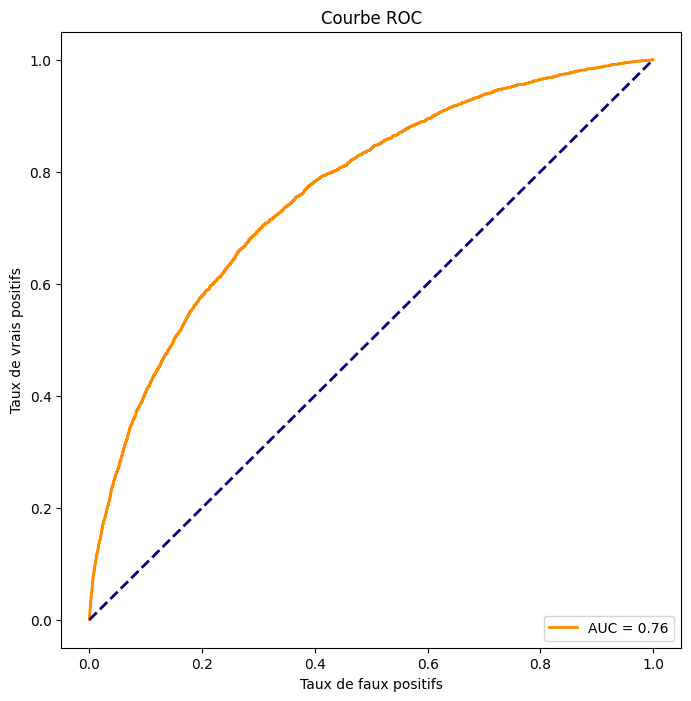

In [92]:
from sklearn.metrics import roc_curve, auc

# Calculez la courbe ROC
fpr, tpr, thresholds = roc_curve(y_hide_test, proba_preds[:, 1])
roc_auc = auc(fpr, tpr)

# Tracez la courbe ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Score F1

In [93]:
from sklearn.metrics import f1_score

clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='f1')

predictions = clf.predict(X_test)

/home/work/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[1]	training's binary_logloss: 0.279387
[2]	training's binary_logloss: 0.278305
[3]	training's binary_logloss: 0.27728
[4]	training's binary_logloss: 0.276315
[5]	training's binary_logloss: 0.275401
[6]	training's binary_logloss: 0.274538
[7]	training's binary_logloss: 0.273717
[8]	training's binary_logloss: 0.272926
[9]	training's binary_logloss: 0.272165
[10]	training's binary_logloss: 0.271441
[11]	training's binary_logloss: 0.270741
[12]	training's binary_logloss: 0.270064
[13]	training's binary_logloss: 0.269498
[14]	training's binary_logloss: 0.268954
[15]	training's binary_logloss: 0.26835
[16]	training's binary_logloss: 0.267775
[17]	training's binary_logloss: 0.267206
[18]	training's binary_logloss: 0.266663
[19]	training's binary_logloss: 0.266135
[20]	training's binary_logloss: 0.265636
[21]	training's binary_logloss: 0.26517
[22]	training's binary_logloss: 

[198]	training's binary_logloss: 0.237844
[199]	training's binary_logloss: 0.237778
[200]	training's binary_logloss: 0.237709
[201]	training's binary_logloss: 0.23765
[202]	training's binary_logloss: 0.237586
[203]	training's binary_logloss: 0.237533
[204]	training's binary_logloss: 0.237471
[205]	training's binary_logloss: 0.237413
[206]	training's binary_logloss: 0.237354
[207]	training's binary_logloss: 0.237292
[208]	training's binary_logloss: 0.23723
[209]	training's binary_logloss: 0.23717
[210]	training's binary_logloss: 0.237113
[211]	training's binary_logloss: 0.237058
[212]	training's binary_logloss: 0.236999
[213]	training's binary_logloss: 0.236935
[214]	training's binary_logloss: 0.236879
[215]	training's binary_logloss: 0.236816
[216]	training's binary_logloss: 0.23675
[217]	training's binary_logloss: 0.236696
[218]	training's binary_logloss: 0.236644
[219]	training's binary_logloss: 0.236583
[220]	training's binary_logloss: 0.236529
[221]	training's binary_logloss: 0.236

[396]	training's binary_logloss: 0.228798
[397]	training's binary_logloss: 0.228758
[398]	training's binary_logloss: 0.228724
[399]	training's binary_logloss: 0.228692
[400]	training's binary_logloss: 0.228656
[401]	training's binary_logloss: 0.228612
[402]	training's binary_logloss: 0.228578
[403]	training's binary_logloss: 0.228543
[404]	training's binary_logloss: 0.228507
[405]	training's binary_logloss: 0.228477
[406]	training's binary_logloss: 0.228433
[407]	training's binary_logloss: 0.228401
[408]	training's binary_logloss: 0.228368
[409]	training's binary_logloss: 0.228323
[410]	training's binary_logloss: 0.228289
[411]	training's binary_logloss: 0.228255
[412]	training's binary_logloss: 0.228226
[413]	training's binary_logloss: 0.228192
[414]	training's binary_logloss: 0.228158
[415]	training's binary_logloss: 0.22812
[416]	training's binary_logloss: 0.228083
[417]	training's binary_logloss: 0.228046
[418]	training's binary_logloss: 0.228005
[419]	training's binary_logloss: 0.

[593]	training's binary_logloss: 0.222572
[594]	training's binary_logloss: 0.222547
[595]	training's binary_logloss: 0.222518
[596]	training's binary_logloss: 0.22249
[597]	training's binary_logloss: 0.222459
[598]	training's binary_logloss: 0.222423
[599]	training's binary_logloss: 0.222392
[600]	training's binary_logloss: 0.222363
[601]	training's binary_logloss: 0.222335
[602]	training's binary_logloss: 0.222307
[603]	training's binary_logloss: 0.222287
[604]	training's binary_logloss: 0.222258
[605]	training's binary_logloss: 0.222224
[606]	training's binary_logloss: 0.222194
[607]	training's binary_logloss: 0.222159
[608]	training's binary_logloss: 0.222128
[609]	training's binary_logloss: 0.222109
[610]	training's binary_logloss: 0.222075
[611]	training's binary_logloss: 0.222045
[612]	training's binary_logloss: 0.222015
[613]	training's binary_logloss: 0.221986
[614]	training's binary_logloss: 0.221951
[615]	training's binary_logloss: 0.221921
[616]	training's binary_logloss: 0.

[790]	training's binary_logloss: 0.217481
[791]	training's binary_logloss: 0.217454
[792]	training's binary_logloss: 0.217431
[793]	training's binary_logloss: 0.217407
[794]	training's binary_logloss: 0.217381
[795]	training's binary_logloss: 0.217357
[796]	training's binary_logloss: 0.21733
[797]	training's binary_logloss: 0.217316
[798]	training's binary_logloss: 0.217292
[799]	training's binary_logloss: 0.217265
[800]	training's binary_logloss: 0.217236
[801]	training's binary_logloss: 0.217205
[802]	training's binary_logloss: 0.217177
[803]	training's binary_logloss: 0.217151
[804]	training's binary_logloss: 0.217122
[805]	training's binary_logloss: 0.217099
[806]	training's binary_logloss: 0.217091
[807]	training's binary_logloss: 0.217074
[808]	training's binary_logloss: 0.217064
[809]	training's binary_logloss: 0.217039
[810]	training's binary_logloss: 0.217014
[811]	training's binary_logloss: 0.21699
[812]	training's binary_logloss: 0.216959
[813]	training's binary_logloss: 0.2

[993]	training's binary_logloss: 0.212834
[994]	training's binary_logloss: 0.212805
[995]	training's binary_logloss: 0.212781
[996]	training's binary_logloss: 0.212756
[997]	training's binary_logloss: 0.212732
[998]	training's binary_logloss: 0.212707
[999]	training's binary_logloss: 0.212684
[1000]	training's binary_logloss: 0.212659
[1001]	training's binary_logloss: 0.212636
[1002]	training's binary_logloss: 0.212614
[1003]	training's binary_logloss: 0.212589
[1004]	training's binary_logloss: 0.212562
[1005]	training's binary_logloss: 0.212538
[1006]	training's binary_logloss: 0.212513
[1007]	training's binary_logloss: 0.212486
[1008]	training's binary_logloss: 0.212464
[1009]	training's binary_logloss: 0.212439
[1010]	training's binary_logloss: 0.212416
[1011]	training's binary_logloss: 0.212396
[1012]	training's binary_logloss: 0.212373
[1013]	training's binary_logloss: 0.212353
[1014]	training's binary_logloss: 0.21233
[1015]	training's binary_logloss: 0.212302
[1016]	training's b

[1186]	training's binary_logloss: 0.208531
[1187]	training's binary_logloss: 0.208506
[1188]	training's binary_logloss: 0.208479
[1189]	training's binary_logloss: 0.208457
[1190]	training's binary_logloss: 0.208432
[1191]	training's binary_logloss: 0.208424
[1192]	training's binary_logloss: 0.208401
[1193]	training's binary_logloss: 0.208374
[1194]	training's binary_logloss: 0.208347
[1195]	training's binary_logloss: 0.208324
[1196]	training's binary_logloss: 0.208299
[1197]	training's binary_logloss: 0.20827
[1198]	training's binary_logloss: 0.208247
[1199]	training's binary_logloss: 0.208222
[1200]	training's binary_logloss: 0.208214
[1201]	training's binary_logloss: 0.208204
[1202]	training's binary_logloss: 0.208178
[1203]	training's binary_logloss: 0.20816
[1204]	training's binary_logloss: 0.208136
[1205]	training's binary_logloss: 0.208111
[1206]	training's binary_logloss: 0.208084
[1207]	training's binary_logloss: 0.208063
[1208]	training's binary_logloss: 0.208039
[1209]	traini

[1382]	training's binary_logloss: 0.204311
[1383]	training's binary_logloss: 0.204289
[1384]	training's binary_logloss: 0.204261
[1385]	training's binary_logloss: 0.204235
[1386]	training's binary_logloss: 0.204214
[1387]	training's binary_logloss: 0.204187
[1388]	training's binary_logloss: 0.204174
[1389]	training's binary_logloss: 0.204149
[1390]	training's binary_logloss: 0.204127
[1391]	training's binary_logloss: 0.204105
[1392]	training's binary_logloss: 0.204084
[1393]	training's binary_logloss: 0.204058
[1394]	training's binary_logloss: 0.204032
[1395]	training's binary_logloss: 0.204011
[1396]	training's binary_logloss: 0.203987
[1397]	training's binary_logloss: 0.203962
[1398]	training's binary_logloss: 0.203941
[1399]	training's binary_logloss: 0.203919
[1400]	training's binary_logloss: 0.203896
[1401]	training's binary_logloss: 0.203876
[1402]	training's binary_logloss: 0.203855
[1403]	training's binary_logloss: 0.203831
[1404]	training's binary_logloss: 0.20381
[1405]	train

[1574]	training's binary_logloss: 0.200401
[1575]	training's binary_logloss: 0.200374
[1576]	training's binary_logloss: 0.200349
[1577]	training's binary_logloss: 0.200328
[1578]	training's binary_logloss: 0.200308
[1579]	training's binary_logloss: 0.200302
[1580]	training's binary_logloss: 0.20028
[1581]	training's binary_logloss: 0.200256
[1582]	training's binary_logloss: 0.200231
[1583]	training's binary_logloss: 0.200206
[1584]	training's binary_logloss: 0.200187
[1585]	training's binary_logloss: 0.20018
[1586]	training's binary_logloss: 0.200172
[1587]	training's binary_logloss: 0.200166
[1588]	training's binary_logloss: 0.200139
[1589]	training's binary_logloss: 0.200115
[1590]	training's binary_logloss: 0.200094
[1591]	training's binary_logloss: 0.200071
[1592]	training's binary_logloss: 0.200063
[1593]	training's binary_logloss: 0.200039
[1594]	training's binary_logloss: 0.200017
[1595]	training's binary_logloss: 0.199997
[1596]	training's binary_logloss: 0.199973
[1597]	traini

[1770]	training's binary_logloss: 0.196455
[1771]	training's binary_logloss: 0.196434
[1772]	training's binary_logloss: 0.196414
[1773]	training's binary_logloss: 0.196395
[1774]	training's binary_logloss: 0.196388
[1775]	training's binary_logloss: 0.196369
[1776]	training's binary_logloss: 0.196348
[1777]	training's binary_logloss: 0.196326
[1778]	training's binary_logloss: 0.196305
[1779]	training's binary_logloss: 0.196286
[1780]	training's binary_logloss: 0.196264
[1781]	training's binary_logloss: 0.196243
[1782]	training's binary_logloss: 0.196224
[1783]	training's binary_logloss: 0.196201
[1784]	training's binary_logloss: 0.196179
[1785]	training's binary_logloss: 0.19616
[1786]	training's binary_logloss: 0.196138
[1787]	training's binary_logloss: 0.196119
[1788]	training's binary_logloss: 0.1961
[1789]	training's binary_logloss: 0.19608
[1790]	training's binary_logloss: 0.196058
[1791]	training's binary_logloss: 0.196039
[1792]	training's binary_logloss: 0.196019
[1793]	training

[1964]	training's binary_logloss: 0.192876
[1965]	training's binary_logloss: 0.192856
[1966]	training's binary_logloss: 0.192837
[1967]	training's binary_logloss: 0.192818
[1968]	training's binary_logloss: 0.192798
[1969]	training's binary_logloss: 0.192775
[1970]	training's binary_logloss: 0.192752
[1971]	training's binary_logloss: 0.192735
[1972]	training's binary_logloss: 0.192715
[1973]	training's binary_logloss: 0.192692
[1974]	training's binary_logloss: 0.192671
[1975]	training's binary_logloss: 0.192649
[1976]	training's binary_logloss: 0.192627
[1977]	training's binary_logloss: 0.192608
[1978]	training's binary_logloss: 0.192589
[1979]	training's binary_logloss: 0.192566
[1980]	training's binary_logloss: 0.192548
[1981]	training's binary_logloss: 0.192538
[1982]	training's binary_logloss: 0.192516
[1983]	training's binary_logloss: 0.192499
[1984]	training's binary_logloss: 0.192477
[1985]	training's binary_logloss: 0.192465
[1986]	training's binary_logloss: 0.192456
[1987]	trai

[2158]	training's binary_logloss: 0.189191
[2159]	training's binary_logloss: 0.189172
[2160]	training's binary_logloss: 0.189152
[2161]	training's binary_logloss: 0.189135
[2162]	training's binary_logloss: 0.189118
[2163]	training's binary_logloss: 0.189098
[2164]	training's binary_logloss: 0.189079
[2165]	training's binary_logloss: 0.18906
[2166]	training's binary_logloss: 0.189039
[2167]	training's binary_logloss: 0.189019
[2168]	training's binary_logloss: 0.189
[2169]	training's binary_logloss: 0.188979
[2170]	training's binary_logloss: 0.188961
[2171]	training's binary_logloss: 0.188957
[2172]	training's binary_logloss: 0.188938
[2173]	training's binary_logloss: 0.188917
[2174]	training's binary_logloss: 0.188897
[2175]	training's binary_logloss: 0.188877
[2176]	training's binary_logloss: 0.188855
[2177]	training's binary_logloss: 0.188835
[2178]	training's binary_logloss: 0.188823
[2179]	training's binary_logloss: 0.188806
[2180]	training's binary_logloss: 0.188784
[2181]	training

[2351]	training's binary_logloss: 0.185559
[2352]	training's binary_logloss: 0.185542
[2353]	training's binary_logloss: 0.185522
[2354]	training's binary_logloss: 0.1855
[2355]	training's binary_logloss: 0.185478
[2356]	training's binary_logloss: 0.185457
[2357]	training's binary_logloss: 0.185438
[2358]	training's binary_logloss: 0.185417
[2359]	training's binary_logloss: 0.185399
[2360]	training's binary_logloss: 0.185378
[2361]	training's binary_logloss: 0.185358
[2362]	training's binary_logloss: 0.185337
[2363]	training's binary_logloss: 0.185315
[2364]	training's binary_logloss: 0.185293
[2365]	training's binary_logloss: 0.185274
[2366]	training's binary_logloss: 0.185254
[2367]	training's binary_logloss: 0.185235
[2368]	training's binary_logloss: 0.185218
[2369]	training's binary_logloss: 0.1852
[2370]	training's binary_logloss: 0.185177
[2371]	training's binary_logloss: 0.185156
[2372]	training's binary_logloss: 0.185137
[2373]	training's binary_logloss: 0.185117
[2374]	training

[2547]	training's binary_logloss: 0.182035
[2548]	training's binary_logloss: 0.182018
[2549]	training's binary_logloss: 0.181999
[2550]	training's binary_logloss: 0.181982
[2551]	training's binary_logloss: 0.181964
[2552]	training's binary_logloss: 0.181946
[2553]	training's binary_logloss: 0.181925
[2554]	training's binary_logloss: 0.181908
[2555]	training's binary_logloss: 0.181901
[2556]	training's binary_logloss: 0.181888
[2557]	training's binary_logloss: 0.181868
[2558]	training's binary_logloss: 0.181849
[2559]	training's binary_logloss: 0.181834
[2560]	training's binary_logloss: 0.181814
[2561]	training's binary_logloss: 0.181808
[2562]	training's binary_logloss: 0.181803
[2563]	training's binary_logloss: 0.181786
[2564]	training's binary_logloss: 0.181777
[2565]	training's binary_logloss: 0.181759
[2566]	training's binary_logloss: 0.181751
[2567]	training's binary_logloss: 0.181745
[2568]	training's binary_logloss: 0.181727
[2569]	training's binary_logloss: 0.181714
[2570]	trai

[2746]	training's binary_logloss: 0.178804
[2747]	training's binary_logloss: 0.178798
[2748]	training's binary_logloss: 0.17878
[2749]	training's binary_logloss: 0.178763
[2750]	training's binary_logloss: 0.178744
[2751]	training's binary_logloss: 0.178724
[2752]	training's binary_logloss: 0.178706
[2753]	training's binary_logloss: 0.178686
[2754]	training's binary_logloss: 0.178668
[2755]	training's binary_logloss: 0.178648
[2756]	training's binary_logloss: 0.178634
[2757]	training's binary_logloss: 0.178619
[2758]	training's binary_logloss: 0.178599
[2759]	training's binary_logloss: 0.178578
[2760]	training's binary_logloss: 0.178558
[2761]	training's binary_logloss: 0.178539
[2762]	training's binary_logloss: 0.178534
[2763]	training's binary_logloss: 0.178524
[2764]	training's binary_logloss: 0.178519
[2765]	training's binary_logloss: 0.178501
[2766]	training's binary_logloss: 0.178484
[2767]	training's binary_logloss: 0.178469
[2768]	training's binary_logloss: 0.178458
[2769]	train

[2943]	training's binary_logloss: 0.175688
[2944]	training's binary_logloss: 0.17567
[2945]	training's binary_logloss: 0.175655
[2946]	training's binary_logloss: 0.175636
[2947]	training's binary_logloss: 0.17562
[2948]	training's binary_logloss: 0.175603
[2949]	training's binary_logloss: 0.175593
[2950]	training's binary_logloss: 0.175575
[2951]	training's binary_logloss: 0.175556
[2952]	training's binary_logloss: 0.175533
[2953]	training's binary_logloss: 0.175511
[2954]	training's binary_logloss: 0.175493
[2955]	training's binary_logloss: 0.175475
[2956]	training's binary_logloss: 0.175458
[2957]	training's binary_logloss: 0.175442
[2958]	training's binary_logloss: 0.175425
[2959]	training's binary_logloss: 0.175404
[2960]	training's binary_logloss: 0.175386
[2961]	training's binary_logloss: 0.175368
[2962]	training's binary_logloss: 0.175347
[2963]	training's binary_logloss: 0.175327
[2964]	training's binary_logloss: 0.175309
[2965]	training's binary_logloss: 0.175292
[2966]	traini

[3139]	training's binary_logloss: 0.172549
[3140]	training's binary_logloss: 0.172529
[3141]	training's binary_logloss: 0.172511
[3142]	training's binary_logloss: 0.172495
[3143]	training's binary_logloss: 0.172476
[3144]	training's binary_logloss: 0.172457
[3145]	training's binary_logloss: 0.172441
[3146]	training's binary_logloss: 0.17243
[3147]	training's binary_logloss: 0.172418
[3148]	training's binary_logloss: 0.172406
[3149]	training's binary_logloss: 0.172389
[3150]	training's binary_logloss: 0.172373
[3151]	training's binary_logloss: 0.172355
[3152]	training's binary_logloss: 0.172336
[3153]	training's binary_logloss: 0.172319
[3154]	training's binary_logloss: 0.172304
[3155]	training's binary_logloss: 0.172288
[3156]	training's binary_logloss: 0.172272
[3157]	training's binary_logloss: 0.172253
[3158]	training's binary_logloss: 0.172237
[3159]	training's binary_logloss: 0.17222
[3160]	training's binary_logloss: 0.172202
[3161]	training's binary_logloss: 0.172183
[3162]	traini

[3334]	training's binary_logloss: 0.169466
[3335]	training's binary_logloss: 0.169458
[3336]	training's binary_logloss: 0.169449
[3337]	training's binary_logloss: 0.169431
[3338]	training's binary_logloss: 0.16942
[3339]	training's binary_logloss: 0.169402
[3340]	training's binary_logloss: 0.169385
[3341]	training's binary_logloss: 0.16937
[3342]	training's binary_logloss: 0.169351
[3343]	training's binary_logloss: 0.169335
[3344]	training's binary_logloss: 0.169321
[3345]	training's binary_logloss: 0.169302
[3346]	training's binary_logloss: 0.169285
[3347]	training's binary_logloss: 0.16927
[3348]	training's binary_logloss: 0.169257
[3349]	training's binary_logloss: 0.16925
[3350]	training's binary_logloss: 0.169234
[3351]	training's binary_logloss: 0.169217
[3352]	training's binary_logloss: 0.169201
[3353]	training's binary_logloss: 0.169192
[3354]	training's binary_logloss: 0.169174
[3355]	training's binary_logloss: 0.169166
[3356]	training's binary_logloss: 0.16916
[3357]	training'

[3526]	training's binary_logloss: 0.166562
[3527]	training's binary_logloss: 0.166545
[3528]	training's binary_logloss: 0.16653
[3529]	training's binary_logloss: 0.166514
[3530]	training's binary_logloss: 0.166509
[3531]	training's binary_logloss: 0.166491
[3532]	training's binary_logloss: 0.166476
[3533]	training's binary_logloss: 0.166459
[3534]	training's binary_logloss: 0.166443
[3535]	training's binary_logloss: 0.166427
[3536]	training's binary_logloss: 0.16641
[3537]	training's binary_logloss: 0.166393
[3538]	training's binary_logloss: 0.166375
[3539]	training's binary_logloss: 0.166358
[3540]	training's binary_logloss: 0.166343
[3541]	training's binary_logloss: 0.166326
[3542]	training's binary_logloss: 0.16631
[3543]	training's binary_logloss: 0.166296
[3544]	training's binary_logloss: 0.166281
[3545]	training's binary_logloss: 0.166265
[3546]	training's binary_logloss: 0.16625
[3547]	training's binary_logloss: 0.166231
[3548]	training's binary_logloss: 0.166214
[3549]	training

[3722]	training's binary_logloss: 0.163577
[3723]	training's binary_logloss: 0.16356
[3724]	training's binary_logloss: 0.163547
[3725]	training's binary_logloss: 0.163533
[3726]	training's binary_logloss: 0.163519
[3727]	training's binary_logloss: 0.163503
[3728]	training's binary_logloss: 0.163485
[3729]	training's binary_logloss: 0.163479
[3730]	training's binary_logloss: 0.163464
[3731]	training's binary_logloss: 0.16346
[3732]	training's binary_logloss: 0.16344
[3733]	training's binary_logloss: 0.163426
[3734]	training's binary_logloss: 0.163409
[3735]	training's binary_logloss: 0.163391
[3736]	training's binary_logloss: 0.163375
[3737]	training's binary_logloss: 0.163373
[3738]	training's binary_logloss: 0.163355
[3739]	training's binary_logloss: 0.16334
[3740]	training's binary_logloss: 0.163323
[3741]	training's binary_logloss: 0.163306
[3742]	training's binary_logloss: 0.163297
[3743]	training's binary_logloss: 0.163288
[3744]	training's binary_logloss: 0.163272
[3745]	training

[3922]	training's binary_logloss: 0.160829
[3923]	training's binary_logloss: 0.160813
[3924]	training's binary_logloss: 0.160802
[3925]	training's binary_logloss: 0.160785
[3926]	training's binary_logloss: 0.160769
[3927]	training's binary_logloss: 0.160758
[3928]	training's binary_logloss: 0.160742
[3929]	training's binary_logloss: 0.160727
[3930]	training's binary_logloss: 0.160712
[3931]	training's binary_logloss: 0.160701
[3932]	training's binary_logloss: 0.160685
[3933]	training's binary_logloss: 0.160675
[3934]	training's binary_logloss: 0.16066
[3935]	training's binary_logloss: 0.160654
[3936]	training's binary_logloss: 0.160638
[3937]	training's binary_logloss: 0.160626
[3938]	training's binary_logloss: 0.160619
[3939]	training's binary_logloss: 0.160601
[3940]	training's binary_logloss: 0.160585
[3941]	training's binary_logloss: 0.160572
[3942]	training's binary_logloss: 0.160558
[3943]	training's binary_logloss: 0.160545
[3944]	training's binary_logloss: 0.160528
[3945]	train

[4117]	training's binary_logloss: 0.158141
[4118]	training's binary_logloss: 0.158128
[4119]	training's binary_logloss: 0.158126
[4120]	training's binary_logloss: 0.158114
[4121]	training's binary_logloss: 0.158098
[4122]	training's binary_logloss: 0.158082
[4123]	training's binary_logloss: 0.158065
[4124]	training's binary_logloss: 0.158052
[4125]	training's binary_logloss: 0.158035
[4126]	training's binary_logloss: 0.15802
[4127]	training's binary_logloss: 0.158004
[4128]	training's binary_logloss: 0.157989
[4129]	training's binary_logloss: 0.157975
[4130]	training's binary_logloss: 0.157961
[4131]	training's binary_logloss: 0.15795
[4132]	training's binary_logloss: 0.157943
[4133]	training's binary_logloss: 0.157937
[4134]	training's binary_logloss: 0.157921
[4135]	training's binary_logloss: 0.157905
[4136]	training's binary_logloss: 0.157889
[4137]	training's binary_logloss: 0.157875
[4138]	training's binary_logloss: 0.157859
[4139]	training's binary_logloss: 0.157843
[4140]	traini

[4309]	training's binary_logloss: 0.155312
[4310]	training's binary_logloss: 0.155305
[4311]	training's binary_logloss: 0.15529
[4312]	training's binary_logloss: 0.155276
[4313]	training's binary_logloss: 0.155262
[4314]	training's binary_logloss: 0.155253
[4315]	training's binary_logloss: 0.155237
[4316]	training's binary_logloss: 0.155226
[4317]	training's binary_logloss: 0.155209
[4318]	training's binary_logloss: 0.155193
[4319]	training's binary_logloss: 0.155179
[4320]	training's binary_logloss: 0.155167
[4321]	training's binary_logloss: 0.155153
[4322]	training's binary_logloss: 0.155139
[4323]	training's binary_logloss: 0.155124
[4324]	training's binary_logloss: 0.155109
[4325]	training's binary_logloss: 0.155094
[4326]	training's binary_logloss: 0.155077
[4327]	training's binary_logloss: 0.15506
[4328]	training's binary_logloss: 0.155046
[4329]	training's binary_logloss: 0.155027
[4330]	training's binary_logloss: 0.155012
[4331]	training's binary_logloss: 0.155007
[4332]	traini

[4506]	training's binary_logloss: 0.152699
[4507]	training's binary_logloss: 0.152685
[4508]	training's binary_logloss: 0.152682
[4509]	training's binary_logloss: 0.152666
[4510]	training's binary_logloss: 0.15265
[4511]	training's binary_logloss: 0.152637
[4512]	training's binary_logloss: 0.152622
[4513]	training's binary_logloss: 0.152607
[4514]	training's binary_logloss: 0.152593
[4515]	training's binary_logloss: 0.152576
[4516]	training's binary_logloss: 0.152559
[4517]	training's binary_logloss: 0.152543
[4518]	training's binary_logloss: 0.152527
[4519]	training's binary_logloss: 0.152512
[4520]	training's binary_logloss: 0.152496
[4521]	training's binary_logloss: 0.152482
[4522]	training's binary_logloss: 0.152468
[4523]	training's binary_logloss: 0.15245
[4524]	training's binary_logloss: 0.152432
[4525]	training's binary_logloss: 0.152431
[4526]	training's binary_logloss: 0.152418
[4527]	training's binary_logloss: 0.152403
[4528]	training's binary_logloss: 0.15239
[4529]	trainin

[4702]	training's binary_logloss: 0.150056
[4703]	training's binary_logloss: 0.150041
[4704]	training's binary_logloss: 0.150027
[4705]	training's binary_logloss: 0.15001
[4706]	training's binary_logloss: 0.150005
[4707]	training's binary_logloss: 0.149987
[4708]	training's binary_logloss: 0.149971
[4709]	training's binary_logloss: 0.149963
[4710]	training's binary_logloss: 0.149948
[4711]	training's binary_logloss: 0.149928
[4712]	training's binary_logloss: 0.149912
[4713]	training's binary_logloss: 0.149908
[4714]	training's binary_logloss: 0.149895
[4715]	training's binary_logloss: 0.149877
[4716]	training's binary_logloss: 0.149863
[4717]	training's binary_logloss: 0.149847
[4718]	training's binary_logloss: 0.149837
[4719]	training's binary_logloss: 0.149833
[4720]	training's binary_logloss: 0.149814
[4721]	training's binary_logloss: 0.149797
[4722]	training's binary_logloss: 0.149782
[4723]	training's binary_logloss: 0.149767
[4724]	training's binary_logloss: 0.149752
[4725]	train

[4897]	training's binary_logloss: 0.147616
[4898]	training's binary_logloss: 0.147601
[4899]	training's binary_logloss: 0.147597
[4900]	training's binary_logloss: 0.147593
[4901]	training's binary_logloss: 0.147576
[4902]	training's binary_logloss: 0.147562
[4903]	training's binary_logloss: 0.147559
[4904]	training's binary_logloss: 0.14755
[4905]	training's binary_logloss: 0.147533
[4906]	training's binary_logloss: 0.147524
[4907]	training's binary_logloss: 0.14751
[4908]	training's binary_logloss: 0.147497
[4909]	training's binary_logloss: 0.147483
[4910]	training's binary_logloss: 0.147468
[4911]	training's binary_logloss: 0.147454
[4912]	training's binary_logloss: 0.147438
[4913]	training's binary_logloss: 0.147424
[4914]	training's binary_logloss: 0.147413
[4915]	training's binary_logloss: 0.147403
[4916]	training's binary_logloss: 0.147389
[4917]	training's binary_logloss: 0.147375
[4918]	training's binary_logloss: 0.147362
[4919]	training's binary_logloss: 0.147354
[4920]	traini

[5091]	training's binary_logloss: 0.145258
[5092]	training's binary_logloss: 0.145247
[5093]	training's binary_logloss: 0.145239
[5094]	training's binary_logloss: 0.145226
[5095]	training's binary_logloss: 0.145215
[5096]	training's binary_logloss: 0.145201
[5097]	training's binary_logloss: 0.145187
[5098]	training's binary_logloss: 0.145172
[5099]	training's binary_logloss: 0.145158
[5100]	training's binary_logloss: 0.145145
[5101]	training's binary_logloss: 0.14514
[5102]	training's binary_logloss: 0.145122
[5103]	training's binary_logloss: 0.14511
[5104]	training's binary_logloss: 0.145096
[5105]	training's binary_logloss: 0.145081
[5106]	training's binary_logloss: 0.145067
[5107]	training's binary_logloss: 0.145053
[5108]	training's binary_logloss: 0.145039
[5109]	training's binary_logloss: 0.145026
[5110]	training's binary_logloss: 0.145013
[5111]	training's binary_logloss: 0.144997
[5112]	training's binary_logloss: 0.144988
[5113]	training's binary_logloss: 0.144973
[5114]	traini

[5282]	training's binary_logloss: 0.142867
[5283]	training's binary_logloss: 0.142863
[5284]	training's binary_logloss: 0.142849
[5285]	training's binary_logloss: 0.142837
[5286]	training's binary_logloss: 0.142823
[5287]	training's binary_logloss: 0.142806
[5288]	training's binary_logloss: 0.142803
[5289]	training's binary_logloss: 0.142788
[5290]	training's binary_logloss: 0.142775
[5291]	training's binary_logloss: 0.142763
[5292]	training's binary_logloss: 0.14276
[5293]	training's binary_logloss: 0.142757
[5294]	training's binary_logloss: 0.142748
[5295]	training's binary_logloss: 0.142745
[5296]	training's binary_logloss: 0.142732
[5297]	training's binary_logloss: 0.142719
[5298]	training's binary_logloss: 0.142703
[5299]	training's binary_logloss: 0.142691
[5300]	training's binary_logloss: 0.142677
[5301]	training's binary_logloss: 0.142664
[5302]	training's binary_logloss: 0.142654
[5303]	training's binary_logloss: 0.14265
[5304]	training's binary_logloss: 0.142637
[5305]	traini

[5479]	training's binary_logloss: 0.140585
[5480]	training's binary_logloss: 0.140569
[5481]	training's binary_logloss: 0.140555
[5482]	training's binary_logloss: 0.140541
[5483]	training's binary_logloss: 0.140535
[5484]	training's binary_logloss: 0.140532
[5485]	training's binary_logloss: 0.140519
[5486]	training's binary_logloss: 0.140513
[5487]	training's binary_logloss: 0.140499
[5488]	training's binary_logloss: 0.140489
[5489]	training's binary_logloss: 0.140484
[5490]	training's binary_logloss: 0.140468
[5491]	training's binary_logloss: 0.140455
[5492]	training's binary_logloss: 0.140443
[5493]	training's binary_logloss: 0.140428
[5494]	training's binary_logloss: 0.140412
[5495]	training's binary_logloss: 0.140399
[5496]	training's binary_logloss: 0.140384
[5497]	training's binary_logloss: 0.140372
[5498]	training's binary_logloss: 0.140359
[5499]	training's binary_logloss: 0.140343
[5500]	training's binary_logloss: 0.140329
[5501]	training's binary_logloss: 0.140317
[5502]	trai

[5672]	training's binary_logloss: 0.138412
[5673]	training's binary_logloss: 0.138397
[5674]	training's binary_logloss: 0.138385
[5675]	training's binary_logloss: 0.138373
[5676]	training's binary_logloss: 0.13836
[5677]	training's binary_logloss: 0.138351
[5678]	training's binary_logloss: 0.138339
[5679]	training's binary_logloss: 0.13833
[5680]	training's binary_logloss: 0.138317
[5681]	training's binary_logloss: 0.138307
[5682]	training's binary_logloss: 0.138295
[5683]	training's binary_logloss: 0.13828
[5684]	training's binary_logloss: 0.138269
[5685]	training's binary_logloss: 0.138259
[5686]	training's binary_logloss: 0.138245
[5687]	training's binary_logloss: 0.138229
[5688]	training's binary_logloss: 0.138217
[5689]	training's binary_logloss: 0.138203
[5690]	training's binary_logloss: 0.13819
[5691]	training's binary_logloss: 0.138181
[5692]	training's binary_logloss: 0.138168
[5693]	training's binary_logloss: 0.138162
[5694]	training's binary_logloss: 0.138147
[5695]	training

[5869]	training's binary_logloss: 0.135974
[5870]	training's binary_logloss: 0.135962
[5871]	training's binary_logloss: 0.135958
[5872]	training's binary_logloss: 0.135947
[5873]	training's binary_logloss: 0.135935
[5874]	training's binary_logloss: 0.135926
[5875]	training's binary_logloss: 0.135914
[5876]	training's binary_logloss: 0.1359
[5877]	training's binary_logloss: 0.135893
[5878]	training's binary_logloss: 0.135882
[5879]	training's binary_logloss: 0.13587
[5880]	training's binary_logloss: 0.135858
[5881]	training's binary_logloss: 0.135847
[5882]	training's binary_logloss: 0.135834
[5883]	training's binary_logloss: 0.135824
[5884]	training's binary_logloss: 0.135812
[5885]	training's binary_logloss: 0.135796
[5886]	training's binary_logloss: 0.135784
[5887]	training's binary_logloss: 0.135769
[5888]	training's binary_logloss: 0.135756
[5889]	training's binary_logloss: 0.135752
[5890]	training's binary_logloss: 0.135747
[5891]	training's binary_logloss: 0.135735
[5892]	trainin

[6065]	training's binary_logloss: 0.133731
[6066]	training's binary_logloss: 0.133718
[6067]	training's binary_logloss: 0.133705
[6068]	training's binary_logloss: 0.133692
[6069]	training's binary_logloss: 0.133679
[6070]	training's binary_logloss: 0.133667
[6071]	training's binary_logloss: 0.133654
[6072]	training's binary_logloss: 0.133639
[6073]	training's binary_logloss: 0.133627
[6074]	training's binary_logloss: 0.133613
[6075]	training's binary_logloss: 0.133605
[6076]	training's binary_logloss: 0.133596
[6077]	training's binary_logloss: 0.133585
[6078]	training's binary_logloss: 0.133571
[6079]	training's binary_logloss: 0.133557
[6080]	training's binary_logloss: 0.133549
[6081]	training's binary_logloss: 0.133534
[6082]	training's binary_logloss: 0.133523
[6083]	training's binary_logloss: 0.13351
[6084]	training's binary_logloss: 0.133496
[6085]	training's binary_logloss: 0.133484
[6086]	training's binary_logloss: 0.13347
[6087]	training's binary_logloss: 0.133466
[6088]	traini

[6258]	training's binary_logloss: 0.131518
[6259]	training's binary_logloss: 0.131503
[6260]	training's binary_logloss: 0.131492
[6261]	training's binary_logloss: 0.13148
[6262]	training's binary_logloss: 0.131468
[6263]	training's binary_logloss: 0.131461
[6264]	training's binary_logloss: 0.131459
[6265]	training's binary_logloss: 0.131445
[6266]	training's binary_logloss: 0.13143
[6267]	training's binary_logloss: 0.131418
[6268]	training's binary_logloss: 0.131407
[6269]	training's binary_logloss: 0.131394
[6270]	training's binary_logloss: 0.131382
[6271]	training's binary_logloss: 0.13137
[6272]	training's binary_logloss: 0.131359
[6273]	training's binary_logloss: 0.131347
[6274]	training's binary_logloss: 0.131336
[6275]	training's binary_logloss: 0.131327
[6276]	training's binary_logloss: 0.131323
[6277]	training's binary_logloss: 0.131311
[6278]	training's binary_logloss: 0.131304
[6279]	training's binary_logloss: 0.131293
[6280]	training's binary_logloss: 0.13128
[6281]	training

[6457]	training's binary_logloss: 0.129394
[6458]	training's binary_logloss: 0.129392
[6459]	training's binary_logloss: 0.12938
[6460]	training's binary_logloss: 0.129373
[6461]	training's binary_logloss: 0.129371
[6462]	training's binary_logloss: 0.129361
[6463]	training's binary_logloss: 0.129348
[6464]	training's binary_logloss: 0.129336
[6465]	training's binary_logloss: 0.129325
[6466]	training's binary_logloss: 0.129323
[6467]	training's binary_logloss: 0.12931
[6468]	training's binary_logloss: 0.129298
[6469]	training's binary_logloss: 0.129285
[6470]	training's binary_logloss: 0.129273
[6471]	training's binary_logloss: 0.129266
[6472]	training's binary_logloss: 0.129256
[6473]	training's binary_logloss: 0.129242
[6474]	training's binary_logloss: 0.12923
[6475]	training's binary_logloss: 0.129216
[6476]	training's binary_logloss: 0.129213
[6477]	training's binary_logloss: 0.1292
[6478]	training's binary_logloss: 0.129188
[6479]	training's binary_logloss: 0.129176
[6480]	training'

[6652]	training's binary_logloss: 0.127316
[6653]	training's binary_logloss: 0.127303
[6654]	training's binary_logloss: 0.127293
[6655]	training's binary_logloss: 0.127281
[6656]	training's binary_logloss: 0.127266
[6657]	training's binary_logloss: 0.127256
[6658]	training's binary_logloss: 0.127244
[6659]	training's binary_logloss: 0.127234
[6660]	training's binary_logloss: 0.127222
[6661]	training's binary_logloss: 0.127209
[6662]	training's binary_logloss: 0.127197
[6663]	training's binary_logloss: 0.127183
[6664]	training's binary_logloss: 0.127172
[6665]	training's binary_logloss: 0.127165
[6666]	training's binary_logloss: 0.127152
[6667]	training's binary_logloss: 0.12714
[6668]	training's binary_logloss: 0.127129
[6669]	training's binary_logloss: 0.127117
[6670]	training's binary_logloss: 0.127106
[6671]	training's binary_logloss: 0.127094
[6672]	training's binary_logloss: 0.127083
[6673]	training's binary_logloss: 0.12707
[6674]	training's binary_logloss: 0.127058
[6675]	traini

[6844]	training's binary_logloss: 0.125347
[6845]	training's binary_logloss: 0.125336
[6846]	training's binary_logloss: 0.125325
[6847]	training's binary_logloss: 0.125313
[6848]	training's binary_logloss: 0.125309
[6849]	training's binary_logloss: 0.125301
[6850]	training's binary_logloss: 0.125289
[6851]	training's binary_logloss: 0.125278
[6852]	training's binary_logloss: 0.125267
[6853]	training's binary_logloss: 0.125257
[6854]	training's binary_logloss: 0.125246
[6855]	training's binary_logloss: 0.125235
[6856]	training's binary_logloss: 0.125225
[6857]	training's binary_logloss: 0.125224
[6858]	training's binary_logloss: 0.125212
[6859]	training's binary_logloss: 0.125202
[6860]	training's binary_logloss: 0.125195
[6861]	training's binary_logloss: 0.125194
[6862]	training's binary_logloss: 0.125182
[6863]	training's binary_logloss: 0.125171
[6864]	training's binary_logloss: 0.125159
[6865]	training's binary_logloss: 0.125148
[6866]	training's binary_logloss: 0.125142
[6867]	trai

[7038]	training's binary_logloss: 0.123416
[7039]	training's binary_logloss: 0.123406
[7040]	training's binary_logloss: 0.123396
[7041]	training's binary_logloss: 0.123394
[7042]	training's binary_logloss: 0.123381
[7043]	training's binary_logloss: 0.123368
[7044]	training's binary_logloss: 0.123359
[7045]	training's binary_logloss: 0.123348
[7046]	training's binary_logloss: 0.123337
[7047]	training's binary_logloss: 0.123327
[7048]	training's binary_logloss: 0.123314
[7049]	training's binary_logloss: 0.123302
[7050]	training's binary_logloss: 0.1233
[7051]	training's binary_logloss: 0.123288
[7052]	training's binary_logloss: 0.123276
[7053]	training's binary_logloss: 0.123264
[7054]	training's binary_logloss: 0.123254
[7055]	training's binary_logloss: 0.12324
[7056]	training's binary_logloss: 0.123229
[7057]	training's binary_logloss: 0.123215
[7058]	training's binary_logloss: 0.123205
[7059]	training's binary_logloss: 0.123193
[7060]	training's binary_logloss: 0.12318
[7061]	training

[7238]	training's binary_logloss: 0.121347
[7239]	training's binary_logloss: 0.121337
[7240]	training's binary_logloss: 0.121327
[7241]	training's binary_logloss: 0.121315
[7242]	training's binary_logloss: 0.121303
[7243]	training's binary_logloss: 0.121295
[7244]	training's binary_logloss: 0.121286
[7245]	training's binary_logloss: 0.121274
[7246]	training's binary_logloss: 0.121272
[7247]	training's binary_logloss: 0.121265
[7248]	training's binary_logloss: 0.121253
[7249]	training's binary_logloss: 0.121251
[7250]	training's binary_logloss: 0.121245
[7251]	training's binary_logloss: 0.121233
[7252]	training's binary_logloss: 0.12122
[7253]	training's binary_logloss: 0.121209
[7254]	training's binary_logloss: 0.121198
[7255]	training's binary_logloss: 0.121187
[7256]	training's binary_logloss: 0.121177
[7257]	training's binary_logloss: 0.121165
[7258]	training's binary_logloss: 0.121155
[7259]	training's binary_logloss: 0.121144
[7260]	training's binary_logloss: 0.121133
[7261]	train

[7435]	training's binary_logloss: 0.119495
[7436]	training's binary_logloss: 0.119484
[7437]	training's binary_logloss: 0.119472
[7438]	training's binary_logloss: 0.119461
[7439]	training's binary_logloss: 0.11945
[7440]	training's binary_logloss: 0.119443
[7441]	training's binary_logloss: 0.119433
[7442]	training's binary_logloss: 0.119422
[7443]	training's binary_logloss: 0.119412
[7444]	training's binary_logloss: 0.119401
[7445]	training's binary_logloss: 0.119395
[7446]	training's binary_logloss: 0.119385
[7447]	training's binary_logloss: 0.119379
[7448]	training's binary_logloss: 0.119374
[7449]	training's binary_logloss: 0.119358
[7450]	training's binary_logloss: 0.119353
[7451]	training's binary_logloss: 0.119339
[7452]	training's binary_logloss: 0.119337
[7453]	training's binary_logloss: 0.119325
[7454]	training's binary_logloss: 0.119319
[7455]	training's binary_logloss: 0.119317
[7456]	training's binary_logloss: 0.119306
[7457]	training's binary_logloss: 0.119297
[7458]	train

[7629]	training's binary_logloss: 0.117677
[7630]	training's binary_logloss: 0.117668
[7631]	training's binary_logloss: 0.117659
[7632]	training's binary_logloss: 0.117651
[7633]	training's binary_logloss: 0.11765
[7634]	training's binary_logloss: 0.117638
[7635]	training's binary_logloss: 0.117627
[7636]	training's binary_logloss: 0.117618
[7637]	training's binary_logloss: 0.117607
[7638]	training's binary_logloss: 0.117596
[7639]	training's binary_logloss: 0.117585
[7640]	training's binary_logloss: 0.117575
[7641]	training's binary_logloss: 0.117565
[7642]	training's binary_logloss: 0.117562
[7643]	training's binary_logloss: 0.117551
[7644]	training's binary_logloss: 0.11754
[7645]	training's binary_logloss: 0.117527
[7646]	training's binary_logloss: 0.117517
[7647]	training's binary_logloss: 0.117514
[7648]	training's binary_logloss: 0.117503
[7649]	training's binary_logloss: 0.117494
[7650]	training's binary_logloss: 0.117484
[7651]	training's binary_logloss: 0.117478
[7652]	traini

[7827]	training's binary_logloss: 0.115901
[7828]	training's binary_logloss: 0.115894
[7829]	training's binary_logloss: 0.115882
[7830]	training's binary_logloss: 0.115879
[7831]	training's binary_logloss: 0.115869
[7832]	training's binary_logloss: 0.115856
[7833]	training's binary_logloss: 0.115845
[7834]	training's binary_logloss: 0.115832
[7835]	training's binary_logloss: 0.115825
[7836]	training's binary_logloss: 0.115814
[7837]	training's binary_logloss: 0.115809
[7838]	training's binary_logloss: 0.115795
[7839]	training's binary_logloss: 0.115785
[7840]	training's binary_logloss: 0.115777
[7841]	training's binary_logloss: 0.115765
[7842]	training's binary_logloss: 0.115752
[7843]	training's binary_logloss: 0.115747
[7844]	training's binary_logloss: 0.115735
[7845]	training's binary_logloss: 0.115732
[7846]	training's binary_logloss: 0.115727
[7847]	training's binary_logloss: 0.115716
[7848]	training's binary_logloss: 0.115707
[7849]	training's binary_logloss: 0.1157
[7850]	traini

[8022]	training's binary_logloss: 0.114172
[8023]	training's binary_logloss: 0.114161
[8024]	training's binary_logloss: 0.114153
[8025]	training's binary_logloss: 0.114142
[8026]	training's binary_logloss: 0.114132
[8027]	training's binary_logloss: 0.114122
[8028]	training's binary_logloss: 0.114113
[8029]	training's binary_logloss: 0.114102
[8030]	training's binary_logloss: 0.114091
[8031]	training's binary_logloss: 0.11408
[8032]	training's binary_logloss: 0.114075
[8033]	training's binary_logloss: 0.114065
[8034]	training's binary_logloss: 0.114058
[8035]	training's binary_logloss: 0.114046
[8036]	training's binary_logloss: 0.114034
[8037]	training's binary_logloss: 0.114029
[8038]	training's binary_logloss: 0.114024
[8039]	training's binary_logloss: 0.114013
[8040]	training's binary_logloss: 0.114003
[8041]	training's binary_logloss: 0.113997
[8042]	training's binary_logloss: 0.113987
[8043]	training's binary_logloss: 0.113976
[8044]	training's binary_logloss: 0.113966
[8045]	train

[8214]	training's binary_logloss: 0.112501
[8215]	training's binary_logloss: 0.112494
[8216]	training's binary_logloss: 0.112489
[8217]	training's binary_logloss: 0.112478
[8218]	training's binary_logloss: 0.112466
[8219]	training's binary_logloss: 0.112461
[8220]	training's binary_logloss: 0.112454
[8221]	training's binary_logloss: 0.112443
[8222]	training's binary_logloss: 0.112431
[8223]	training's binary_logloss: 0.112418
[8224]	training's binary_logloss: 0.112412
[8225]	training's binary_logloss: 0.112402
[8226]	training's binary_logloss: 0.11239
[8227]	training's binary_logloss: 0.112385
[8228]	training's binary_logloss: 0.112374
[8229]	training's binary_logloss: 0.112363
[8230]	training's binary_logloss: 0.112353
[8231]	training's binary_logloss: 0.112341
[8232]	training's binary_logloss: 0.112332
[8233]	training's binary_logloss: 0.112322
[8234]	training's binary_logloss: 0.11231
[8235]	training's binary_logloss: 0.1123
[8236]	training's binary_logloss: 0.11229
[8237]	training'

[8413]	training's binary_logloss: 0.110727
[8414]	training's binary_logloss: 0.110717
[8415]	training's binary_logloss: 0.110706
[8416]	training's binary_logloss: 0.1107
[8417]	training's binary_logloss: 0.110693
[8418]	training's binary_logloss: 0.110688
[8419]	training's binary_logloss: 0.110678
[8420]	training's binary_logloss: 0.110668
[8421]	training's binary_logloss: 0.110659
[8422]	training's binary_logloss: 0.110649
[8423]	training's binary_logloss: 0.110638
[8424]	training's binary_logloss: 0.110629
[8425]	training's binary_logloss: 0.110619
[8426]	training's binary_logloss: 0.110609
[8427]	training's binary_logloss: 0.110602
[8428]	training's binary_logloss: 0.110592
[8429]	training's binary_logloss: 0.110582
[8430]	training's binary_logloss: 0.110574
[8431]	training's binary_logloss: 0.110567
[8432]	training's binary_logloss: 0.110559
[8433]	training's binary_logloss: 0.110549
[8434]	training's binary_logloss: 0.110539
[8435]	training's binary_logloss: 0.110531
[8436]	traini

[8608]	training's binary_logloss: 0.109017
[8609]	training's binary_logloss: 0.109007
[8610]	training's binary_logloss: 0.108995
[8611]	training's binary_logloss: 0.108985
[8612]	training's binary_logloss: 0.108972
[8613]	training's binary_logloss: 0.108969
[8614]	training's binary_logloss: 0.108957
[8615]	training's binary_logloss: 0.108947
[8616]	training's binary_logloss: 0.108937
[8617]	training's binary_logloss: 0.108926
[8618]	training's binary_logloss: 0.108915
[8619]	training's binary_logloss: 0.108905
[8620]	training's binary_logloss: 0.108895
[8621]	training's binary_logloss: 0.108885
[8622]	training's binary_logloss: 0.108874
[8623]	training's binary_logloss: 0.108866
[8624]	training's binary_logloss: 0.108854
[8625]	training's binary_logloss: 0.108846
[8626]	training's binary_logloss: 0.108834
[8627]	training's binary_logloss: 0.108829
[8628]	training's binary_logloss: 0.108823
[8629]	training's binary_logloss: 0.108813
[8630]	training's binary_logloss: 0.10881
[8631]	train

[8802]	training's binary_logloss: 0.107202
[8803]	training's binary_logloss: 0.107193
[8804]	training's binary_logloss: 0.107183
[8805]	training's binary_logloss: 0.107173
[8806]	training's binary_logloss: 0.107163
[8807]	training's binary_logloss: 0.107151
[8808]	training's binary_logloss: 0.107143
[8809]	training's binary_logloss: 0.107135
[8810]	training's binary_logloss: 0.107128
[8811]	training's binary_logloss: 0.107123
[8812]	training's binary_logloss: 0.10712
[8813]	training's binary_logloss: 0.10711
[8814]	training's binary_logloss: 0.1071
[8815]	training's binary_logloss: 0.10709
[8816]	training's binary_logloss: 0.107082
[8817]	training's binary_logloss: 0.107073
[8818]	training's binary_logloss: 0.107064
[8819]	training's binary_logloss: 0.107054
[8820]	training's binary_logloss: 0.107044
[8821]	training's binary_logloss: 0.107034
[8822]	training's binary_logloss: 0.107026
[8823]	training's binary_logloss: 0.107017
[8824]	training's binary_logloss: 0.107008
[8825]	training'

[9001]	training's binary_logloss: 0.105503
[9002]	training's binary_logloss: 0.105498
[9003]	training's binary_logloss: 0.10549
[9004]	training's binary_logloss: 0.10548
[9005]	training's binary_logloss: 0.105473
[9006]	training's binary_logloss: 0.105472
[9007]	training's binary_logloss: 0.105462
[9008]	training's binary_logloss: 0.105452
[9009]	training's binary_logloss: 0.105445
[9010]	training's binary_logloss: 0.105435
[9011]	training's binary_logloss: 0.105433
[9012]	training's binary_logloss: 0.105424
[9013]	training's binary_logloss: 0.105419
[9014]	training's binary_logloss: 0.105412
[9015]	training's binary_logloss: 0.105403
[9016]	training's binary_logloss: 0.1054
[9017]	training's binary_logloss: 0.105391
[9018]	training's binary_logloss: 0.105384
[9019]	training's binary_logloss: 0.105379
[9020]	training's binary_logloss: 0.105368
[9021]	training's binary_logloss: 0.105358
[9022]	training's binary_logloss: 0.105353
[9023]	training's binary_logloss: 0.105345
[9024]	training

[9199]	training's binary_logloss: 0.103974
[9200]	training's binary_logloss: 0.103965
[9201]	training's binary_logloss: 0.103956
[9202]	training's binary_logloss: 0.103946
[9203]	training's binary_logloss: 0.10394
[9204]	training's binary_logloss: 0.10393
[9205]	training's binary_logloss: 0.103922
[9206]	training's binary_logloss: 0.10391
[9207]	training's binary_logloss: 0.103898
[9208]	training's binary_logloss: 0.103887
[9209]	training's binary_logloss: 0.103878
[9210]	training's binary_logloss: 0.103868
[9211]	training's binary_logloss: 0.10386
[9212]	training's binary_logloss: 0.103853
[9213]	training's binary_logloss: 0.103843
[9214]	training's binary_logloss: 0.103832
[9215]	training's binary_logloss: 0.103822
[9216]	training's binary_logloss: 0.103811
[9217]	training's binary_logloss: 0.103803
[9218]	training's binary_logloss: 0.10379
[9219]	training's binary_logloss: 0.10378
[9220]	training's binary_logloss: 0.103771
[9221]	training's binary_logloss: 0.10376
[9222]	training's 

[9398]	training's binary_logloss: 0.102338
[9399]	training's binary_logloss: 0.102328
[9400]	training's binary_logloss: 0.10232
[9401]	training's binary_logloss: 0.102312
[9402]	training's binary_logloss: 0.102304
[9403]	training's binary_logloss: 0.102295
[9404]	training's binary_logloss: 0.102285
[9405]	training's binary_logloss: 0.102276
[9406]	training's binary_logloss: 0.102267
[9407]	training's binary_logloss: 0.102262
[9408]	training's binary_logloss: 0.10226
[9409]	training's binary_logloss: 0.102252
[9410]	training's binary_logloss: 0.102247
[9411]	training's binary_logloss: 0.102245
[9412]	training's binary_logloss: 0.102235
[9413]	training's binary_logloss: 0.102226
[9414]	training's binary_logloss: 0.102215
[9415]	training's binary_logloss: 0.102205
[9416]	training's binary_logloss: 0.102196
[9417]	training's binary_logloss: 0.102188
[9418]	training's binary_logloss: 0.102181
[9419]	training's binary_logloss: 0.102175
[9420]	training's binary_logloss: 0.102167
[9421]	traini

[9589]	training's binary_logloss: 0.100796
[9590]	training's binary_logloss: 0.100788
[9591]	training's binary_logloss: 0.100779
[9592]	training's binary_logloss: 0.10077
[9593]	training's binary_logloss: 0.100761
[9594]	training's binary_logloss: 0.100752
[9595]	training's binary_logloss: 0.100748
[9596]	training's binary_logloss: 0.100737
[9597]	training's binary_logloss: 0.100731
[9598]	training's binary_logloss: 0.100722
[9599]	training's binary_logloss: 0.100713
[9600]	training's binary_logloss: 0.100703
[9601]	training's binary_logloss: 0.100698
[9602]	training's binary_logloss: 0.100694
[9603]	training's binary_logloss: 0.100685
[9604]	training's binary_logloss: 0.100674
[9605]	training's binary_logloss: 0.100666
[9606]	training's binary_logloss: 0.100657
[9607]	training's binary_logloss: 0.10065
[9608]	training's binary_logloss: 0.100642
[9609]	training's binary_logloss: 0.100636
[9610]	training's binary_logloss: 0.100625
[9611]	training's binary_logloss: 0.100615
[9612]	traini

[9781]	training's binary_logloss: 0.099195
[9782]	training's binary_logloss: 0.0991886
[9783]	training's binary_logloss: 0.0991876
[9784]	training's binary_logloss: 0.0991785
[9785]	training's binary_logloss: 0.0991687
[9786]	training's binary_logloss: 0.0991602
[9787]	training's binary_logloss: 0.0991533
[9788]	training's binary_logloss: 0.0991436
[9789]	training's binary_logloss: 0.0991392
[9790]	training's binary_logloss: 0.0991345
[9791]	training's binary_logloss: 0.0991242
[9792]	training's binary_logloss: 0.0991186
[9793]	training's binary_logloss: 0.0991078
[9794]	training's binary_logloss: 0.0991003
[9795]	training's binary_logloss: 0.0990994
[9796]	training's binary_logloss: 0.0990908
[9797]	training's binary_logloss: 0.0990877
[9798]	training's binary_logloss: 0.0990785
[9799]	training's binary_logloss: 0.0990715
[9800]	training's binary_logloss: 0.0990609
[9801]	training's binary_logloss: 0.099051
[9802]	training's binary_logloss: 0.0990419
[9803]	training's binary_logloss: 

[9970]	training's binary_logloss: 0.0978387
[9971]	training's binary_logloss: 0.0978297
[9972]	training's binary_logloss: 0.097822
[9973]	training's binary_logloss: 0.0978182
[9974]	training's binary_logloss: 0.0978138
[9975]	training's binary_logloss: 0.0978047
[9976]	training's binary_logloss: 0.0977945
[9977]	training's binary_logloss: 0.0977917
[9978]	training's binary_logloss: 0.0977836
[9979]	training's binary_logloss: 0.0977789
[9980]	training's binary_logloss: 0.0977694
[9981]	training's binary_logloss: 0.0977602
[9982]	training's binary_logloss: 0.0977509
[9983]	training's binary_logloss: 0.0977449
[9984]	training's binary_logloss: 0.097742
[9985]	training's binary_logloss: 0.0977377
[9986]	training's binary_logloss: 0.0977337
[9987]	training's binary_logloss: 0.0977252
[9988]	training's binary_logloss: 0.0977164
[9989]	training's binary_logloss: 0.0977084
[9990]	training's binary_logloss: 0.0977026
[9991]	training's binary_logloss: 0.0976985
[9992]	training's binary_logloss: 

In [94]:
f1 = f1_score(y_test, predictions)
print(f"Score F1 sur l'ensemble de test: {f1}")

Score F1 sur l'ensemble de test: 0.11359315589353611


In [95]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[42158   245]
 [ 3485   239]]


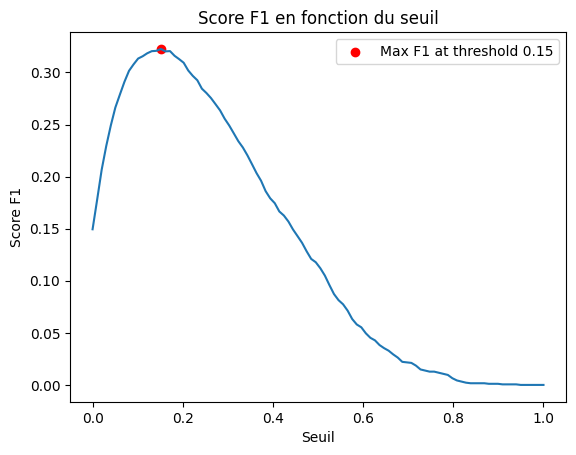

[0 0 0 ... 1 0 0]


In [96]:
probas_pred = clf.predict_proba(X_test)[:, 1]

# Initialiser les listes pour stocker les résultats
threshold_array = np.linspace(0, 1, 100)
f1_list = []

# Calculer le F1 pour différents seuils
for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (probas_pred > threshold).astype(int)
    # Calcul du f1 pour un seuil donné
    f1_threshold = f1_score(
        y_true=y_test, y_pred=label_pred_threshold
    )

    f1_list.append(f1_threshold)

# Trouver l'indice du maximum de la liste des scores F1
best_threshold_index = np.argmax(f1_list)

# Récupérer le seuil correspondant
best_threshold = threshold_array[best_threshold_index]

# Afficher le graphique
plt.plot(threshold_array, f1_list)
plt.xlabel('Seuil')
plt.ylabel('Score F1')
plt.title('Score F1 en fonction du seuil')
plt.scatter(best_threshold, f1_list[best_threshold_index], color='red', label=f'Max F1 at threshold {best_threshold:.2f}')
plt.legend()
plt.show()

# Utiliser le seuil optimal pour les prédictions
optimal_predictions = (probas_pred > best_threshold).astype(int)
print(optimal_predictions)

In [97]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_with_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1] > best_threshold).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_with_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché avec le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché avec le seuil optimal: 0.3183861418704089


In [98]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_hide_test, predictions_with_optimal_threshold)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[38457  3945]
 [ 2272  1452]]


In [1]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_without_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1]).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_without_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché sans le seuil optimal: {f1_optimal}")

NameError: name 'clf' is not defined

# SMOTE

In [100]:
counter = Counter(y_train)
print(counter)

Counter({0: 197877, 1: 17377})


In [101]:
smote = SMOTE(random_state=42)

# Appliquer SMOTE sur les données
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [102]:
counter = Counter(y_resampled)
print(counter)

Counter({0: 197877, 1: 197877})


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='f1')

predictions = clf.predict(X_test)

/home/work/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[1]	training's binary_logloss: 0.68764
[2]	training's binary_logloss: 0.682327
[3]	training's binary_logloss: 0.677262
[4]	training's binary_logloss: 0.672366
[5]	training's binary_logloss: 0.667499
[6]	training's binary_logloss: 0.662897
[7]	training's binary_logloss: 0.658438
[8]	training's binary_logloss: 0.654014
[9]	training's binary_logloss: 0.64971
[10]	training's binary_logloss: 0.645707
[11]	training's binary_logloss: 0.641771
[12]	training's binary_logloss: 0.637959
[13]	training's binary_logloss: 0.634223
[14]	training's binary_logloss: 0.630599
[15]	training's binary_logloss: 0.627033
[16]	training's binary_logloss: 0.623576
[17]	training's binary_logloss: 0.620239
[18]	training's binary_logloss: 0.616847
[19]	training's binary_logloss: 0.613558
[20]	training's binary_logloss: 0.610498
[21]	training's binary_logloss: 0.60732
[22]	training's binary_logloss: 

[197]	training's binary_logloss: 0.318362
[198]	training's binary_logloss: 0.317805
[199]	training's binary_logloss: 0.316741
[200]	training's binary_logloss: 0.314264
[201]	training's binary_logloss: 0.313461
[202]	training's binary_logloss: 0.313035
[203]	training's binary_logloss: 0.310649
[204]	training's binary_logloss: 0.308328
[205]	training's binary_logloss: 0.307466
[206]	training's binary_logloss: 0.307065
[207]	training's binary_logloss: 0.306452
[208]	training's binary_logloss: 0.304224
[209]	training's binary_logloss: 0.303256
[210]	training's binary_logloss: 0.302576
[211]	training's binary_logloss: 0.300434
[212]	training's binary_logloss: 0.300041
[213]	training's binary_logloss: 0.299277
[214]	training's binary_logloss: 0.298628
[215]	training's binary_logloss: 0.296565
[216]	training's binary_logloss: 0.29597
[217]	training's binary_logloss: 0.293969
[218]	training's binary_logloss: 0.293494
[219]	training's binary_logloss: 0.291558
[220]	training's binary_logloss: 0.

[393]	training's binary_logloss: 0.203991
[394]	training's binary_logloss: 0.203788
[395]	training's binary_logloss: 0.203492
[396]	training's binary_logloss: 0.203257
[397]	training's binary_logloss: 0.202828
[398]	training's binary_logloss: 0.202646
[399]	training's binary_logloss: 0.202341
[400]	training's binary_logloss: 0.202166
[401]	training's binary_logloss: 0.20188
[402]	training's binary_logloss: 0.201734
[403]	training's binary_logloss: 0.201436
[404]	training's binary_logloss: 0.201303
[405]	training's binary_logloss: 0.200894
[406]	training's binary_logloss: 0.200761
[407]	training's binary_logloss: 0.2006
[408]	training's binary_logloss: 0.200386
[409]	training's binary_logloss: 0.200184
[410]	training's binary_logloss: 0.19991
[411]	training's binary_logloss: 0.199776
[412]	training's binary_logloss: 0.199645
[413]	training's binary_logloss: 0.199195
[414]	training's binary_logloss: 0.198918
[415]	training's binary_logloss: 0.198814
[416]	training's binary_logloss: 0.198

[591]	training's binary_logloss: 0.171605
[592]	training's binary_logloss: 0.171525
[593]	training's binary_logloss: 0.171438
[594]	training's binary_logloss: 0.171358
[595]	training's binary_logloss: 0.17131
[596]	training's binary_logloss: 0.171135
[597]	training's binary_logloss: 0.170993
[598]	training's binary_logloss: 0.170945
[599]	training's binary_logloss: 0.170854
[600]	training's binary_logloss: 0.170742
[601]	training's binary_logloss: 0.170692
[602]	training's binary_logloss: 0.170538
[603]	training's binary_logloss: 0.170484
[604]	training's binary_logloss: 0.170336
[605]	training's binary_logloss: 0.170186
[606]	training's binary_logloss: 0.1701
[607]	training's binary_logloss: 0.170018
[608]	training's binary_logloss: 0.169959
[609]	training's binary_logloss: 0.169896
[610]	training's binary_logloss: 0.169744
[611]	training's binary_logloss: 0.169674
[612]	training's binary_logloss: 0.169592
[613]	training's binary_logloss: 0.169476
[614]	training's binary_logloss: 0.16

[790]	training's binary_logloss: 0.155946
[791]	training's binary_logloss: 0.155898
[792]	training's binary_logloss: 0.15585
[793]	training's binary_logloss: 0.15579
[794]	training's binary_logloss: 0.155751
[795]	training's binary_logloss: 0.155699
[796]	training's binary_logloss: 0.155658
[797]	training's binary_logloss: 0.155615
[798]	training's binary_logloss: 0.155476
[799]	training's binary_logloss: 0.155332
[800]	training's binary_logloss: 0.155266
[801]	training's binary_logloss: 0.155224
[802]	training's binary_logloss: 0.155155
[803]	training's binary_logloss: 0.155124
[804]	training's binary_logloss: 0.155088
[805]	training's binary_logloss: 0.155057
[806]	training's binary_logloss: 0.155008
[807]	training's binary_logloss: 0.15497
[808]	training's binary_logloss: 0.154888
[809]	training's binary_logloss: 0.154844
[810]	training's binary_logloss: 0.154738
[811]	training's binary_logloss: 0.15468
[812]	training's binary_logloss: 0.154533
[813]	training's binary_logloss: 0.154

[990]	training's binary_logloss: 0.146175
[991]	training's binary_logloss: 0.146148
[992]	training's binary_logloss: 0.146088
[993]	training's binary_logloss: 0.146053
[994]	training's binary_logloss: 0.14602
[995]	training's binary_logloss: 0.145968
[996]	training's binary_logloss: 0.145931
[997]	training's binary_logloss: 0.145898
[998]	training's binary_logloss: 0.14586
[999]	training's binary_logloss: 0.145823
[1000]	training's binary_logloss: 0.145787
[1001]	training's binary_logloss: 0.145754
[1002]	training's binary_logloss: 0.145697
[1003]	training's binary_logloss: 0.145669
[1004]	training's binary_logloss: 0.145637
[1005]	training's binary_logloss: 0.145604
[1006]	training's binary_logloss: 0.145578
[1007]	training's binary_logloss: 0.145514
[1008]	training's binary_logloss: 0.145478
[1009]	training's binary_logloss: 0.145446
[1010]	training's binary_logloss: 0.145416
[1011]	training's binary_logloss: 0.14535
[1012]	training's binary_logloss: 0.1453
[1013]	training's binary_l

[1185]	training's binary_logloss: 0.139472
[1186]	training's binary_logloss: 0.139415
[1187]	training's binary_logloss: 0.139389
[1188]	training's binary_logloss: 0.139366
[1189]	training's binary_logloss: 0.139342
[1190]	training's binary_logloss: 0.139315
[1191]	training's binary_logloss: 0.13929
[1192]	training's binary_logloss: 0.139266
[1193]	training's binary_logloss: 0.139243
[1194]	training's binary_logloss: 0.139212
[1195]	training's binary_logloss: 0.139182
[1196]	training's binary_logloss: 0.139166
[1197]	training's binary_logloss: 0.139138
[1198]	training's binary_logloss: 0.139112
[1199]	training's binary_logloss: 0.139085
[1200]	training's binary_logloss: 0.13906
[1201]	training's binary_logloss: 0.139037
[1202]	training's binary_logloss: 0.139005
[1203]	training's binary_logloss: 0.138981
[1204]	training's binary_logloss: 0.138959
[1205]	training's binary_logloss: 0.138938
[1206]	training's binary_logloss: 0.138914
[1207]	training's binary_logloss: 0.13889
[1208]	trainin

[1379]	training's binary_logloss: 0.134577
[1380]	training's binary_logloss: 0.134557
[1381]	training's binary_logloss: 0.134539
[1382]	training's binary_logloss: 0.134527
[1383]	training's binary_logloss: 0.134501
[1384]	training's binary_logloss: 0.134471
[1385]	training's binary_logloss: 0.134447
[1386]	training's binary_logloss: 0.134426
[1387]	training's binary_logloss: 0.134406
[1388]	training's binary_logloss: 0.13438
[1389]	training's binary_logloss: 0.134356
[1390]	training's binary_logloss: 0.134335
[1391]	training's binary_logloss: 0.134306
[1392]	training's binary_logloss: 0.134285
[1393]	training's binary_logloss: 0.13426
[1394]	training's binary_logloss: 0.134242
[1395]	training's binary_logloss: 0.13422
[1396]	training's binary_logloss: 0.134192
[1397]	training's binary_logloss: 0.134172
[1398]	training's binary_logloss: 0.134158
[1399]	training's binary_logloss: 0.134139
[1400]	training's binary_logloss: 0.13412
[1401]	training's binary_logloss: 0.13408
[1402]	training'

[1575]	training's binary_logloss: 0.130291
[1576]	training's binary_logloss: 0.130269
[1577]	training's binary_logloss: 0.130247
[1578]	training's binary_logloss: 0.130201
[1579]	training's binary_logloss: 0.130182
[1580]	training's binary_logloss: 0.130165
[1581]	training's binary_logloss: 0.130149
[1582]	training's binary_logloss: 0.130131
[1583]	training's binary_logloss: 0.130106
[1584]	training's binary_logloss: 0.130087
[1585]	training's binary_logloss: 0.130068
[1586]	training's binary_logloss: 0.130049
[1587]	training's binary_logloss: 0.130027
[1588]	training's binary_logloss: 0.130005
[1589]	training's binary_logloss: 0.129983
[1590]	training's binary_logloss: 0.129961
[1591]	training's binary_logloss: 0.129945
[1592]	training's binary_logloss: 0.129921
[1593]	training's binary_logloss: 0.129905
[1594]	training's binary_logloss: 0.129886
[1595]	training's binary_logloss: 0.129864
[1596]	training's binary_logloss: 0.129836
[1597]	training's binary_logloss: 0.129815
[1598]	trai

[1767]	training's binary_logloss: 0.126458
[1768]	training's binary_logloss: 0.126443
[1769]	training's binary_logloss: 0.126426
[1770]	training's binary_logloss: 0.126407
[1771]	training's binary_logloss: 0.126387
[1772]	training's binary_logloss: 0.126369
[1773]	training's binary_logloss: 0.126353
[1774]	training's binary_logloss: 0.126338
[1775]	training's binary_logloss: 0.126297
[1776]	training's binary_logloss: 0.126282
[1777]	training's binary_logloss: 0.126263
[1778]	training's binary_logloss: 0.126246
[1779]	training's binary_logloss: 0.126229
[1780]	training's binary_logloss: 0.126212
[1781]	training's binary_logloss: 0.126192
[1782]	training's binary_logloss: 0.126145
[1783]	training's binary_logloss: 0.126129
[1784]	training's binary_logloss: 0.126113
[1785]	training's binary_logloss: 0.126096
[1786]	training's binary_logloss: 0.126078
[1787]	training's binary_logloss: 0.12606
[1788]	training's binary_logloss: 0.126049
[1789]	training's binary_logloss: 0.126031
[1790]	train

[1960]	training's binary_logloss: 0.122921
[1961]	training's binary_logloss: 0.122904
[1962]	training's binary_logloss: 0.122886
[1963]	training's binary_logloss: 0.122869
[1964]	training's binary_logloss: 0.122849
[1965]	training's binary_logloss: 0.122832
[1966]	training's binary_logloss: 0.122816
[1967]	training's binary_logloss: 0.122799
[1968]	training's binary_logloss: 0.122783
[1969]	training's binary_logloss: 0.122764
[1970]	training's binary_logloss: 0.122746
[1971]	training's binary_logloss: 0.122729
[1972]	training's binary_logloss: 0.12271
[1973]	training's binary_logloss: 0.122692
[1974]	training's binary_logloss: 0.122674
[1975]	training's binary_logloss: 0.122657
[1976]	training's binary_logloss: 0.12264
[1977]	training's binary_logloss: 0.122621
[1978]	training's binary_logloss: 0.122607
[1979]	training's binary_logloss: 0.122589
[1980]	training's binary_logloss: 0.122571
[1981]	training's binary_logloss: 0.122552
[1982]	training's binary_logloss: 0.122536
[1983]	traini

[2156]	training's binary_logloss: 0.119691
[2157]	training's binary_logloss: 0.119676
[2158]	training's binary_logloss: 0.119649
[2159]	training's binary_logloss: 0.119633
[2160]	training's binary_logloss: 0.119617
[2161]	training's binary_logloss: 0.119601
[2162]	training's binary_logloss: 0.119591
[2163]	training's binary_logloss: 0.119573
[2164]	training's binary_logloss: 0.119558
[2165]	training's binary_logloss: 0.119544
[2166]	training's binary_logloss: 0.119527
[2167]	training's binary_logloss: 0.119501
[2168]	training's binary_logloss: 0.119491
[2169]	training's binary_logloss: 0.119474
[2170]	training's binary_logloss: 0.119459
[2171]	training's binary_logloss: 0.119446
[2172]	training's binary_logloss: 0.119431
[2173]	training's binary_logloss: 0.119414
[2174]	training's binary_logloss: 0.119398
[2175]	training's binary_logloss: 0.119383
[2176]	training's binary_logloss: 0.119368
[2177]	training's binary_logloss: 0.119354
[2178]	training's binary_logloss: 0.119336
[2179]	trai

[2351]	training's binary_logloss: 0.116623
[2352]	training's binary_logloss: 0.11661
[2353]	training's binary_logloss: 0.116598
[2354]	training's binary_logloss: 0.116583
[2355]	training's binary_logloss: 0.116569
[2356]	training's binary_logloss: 0.116555
[2357]	training's binary_logloss: 0.11654
[2358]	training's binary_logloss: 0.116525
[2359]	training's binary_logloss: 0.11651
[2360]	training's binary_logloss: 0.116492
[2361]	training's binary_logloss: 0.116476
[2362]	training's binary_logloss: 0.11646
[2363]	training's binary_logloss: 0.116449
[2364]	training's binary_logloss: 0.116447
[2365]	training's binary_logloss: 0.116426
[2366]	training's binary_logloss: 0.116412
[2367]	training's binary_logloss: 0.116397
[2368]	training's binary_logloss: 0.116383
[2369]	training's binary_logloss: 0.116368
[2370]	training's binary_logloss: 0.116354
[2371]	training's binary_logloss: 0.116329
[2372]	training's binary_logloss: 0.116315
[2373]	training's binary_logloss: 0.1163
[2374]	training's

[2550]	training's binary_logloss: 0.113672
[2551]	training's binary_logloss: 0.113658
[2552]	training's binary_logloss: 0.113642
[2553]	training's binary_logloss: 0.113627
[2554]	training's binary_logloss: 0.113613
[2555]	training's binary_logloss: 0.113598
[2556]	training's binary_logloss: 0.113584
[2557]	training's binary_logloss: 0.113576
[2558]	training's binary_logloss: 0.113562
[2559]	training's binary_logloss: 0.113546
[2560]	training's binary_logloss: 0.11353
[2561]	training's binary_logloss: 0.113517
[2562]	training's binary_logloss: 0.113505
[2563]	training's binary_logloss: 0.11349
[2564]	training's binary_logloss: 0.113475
[2565]	training's binary_logloss: 0.113462
[2566]	training's binary_logloss: 0.113448
[2567]	training's binary_logloss: 0.113433
[2568]	training's binary_logloss: 0.113426
[2569]	training's binary_logloss: 0.113413
[2570]	training's binary_logloss: 0.113399
[2571]	training's binary_logloss: 0.113383
[2572]	training's binary_logloss: 0.11337
[2573]	trainin

[2743]	training's binary_logloss: 0.110992
[2744]	training's binary_logloss: 0.110978
[2745]	training's binary_logloss: 0.110964
[2746]	training's binary_logloss: 0.110959
[2747]	training's binary_logloss: 0.110946
[2748]	training's binary_logloss: 0.110934
[2749]	training's binary_logloss: 0.110924
[2750]	training's binary_logloss: 0.11091
[2751]	training's binary_logloss: 0.110896
[2752]	training's binary_logloss: 0.11088
[2753]	training's binary_logloss: 0.110867
[2754]	training's binary_logloss: 0.110851
[2755]	training's binary_logloss: 0.110836
[2756]	training's binary_logloss: 0.110832
[2757]	training's binary_logloss: 0.110817
[2758]	training's binary_logloss: 0.110802
[2759]	training's binary_logloss: 0.110789
[2760]	training's binary_logloss: 0.110775
[2761]	training's binary_logloss: 0.110767
[2762]	training's binary_logloss: 0.110753
[2763]	training's binary_logloss: 0.110737
[2764]	training's binary_logloss: 0.110726
[2765]	training's binary_logloss: 0.110711
[2766]	traini

[2934]	training's binary_logloss: 0.108476
[2935]	training's binary_logloss: 0.108466
[2936]	training's binary_logloss: 0.108452
[2937]	training's binary_logloss: 0.108436
[2938]	training's binary_logloss: 0.108421
[2939]	training's binary_logloss: 0.108409
[2940]	training's binary_logloss: 0.108396
[2941]	training's binary_logloss: 0.108385
[2942]	training's binary_logloss: 0.108373
[2943]	training's binary_logloss: 0.108364
[2944]	training's binary_logloss: 0.108352
[2945]	training's binary_logloss: 0.108347
[2946]	training's binary_logloss: 0.108334
[2947]	training's binary_logloss: 0.108321
[2948]	training's binary_logloss: 0.108306
[2949]	training's binary_logloss: 0.108296
[2950]	training's binary_logloss: 0.108284
[2951]	training's binary_logloss: 0.108271
[2952]	training's binary_logloss: 0.108254
[2953]	training's binary_logloss: 0.108245
[2954]	training's binary_logloss: 0.108234
[2955]	training's binary_logloss: 0.108225
[2956]	training's binary_logloss: 0.108211
[2957]	trai

[3126]	training's binary_logloss: 0.106105
[3127]	training's binary_logloss: 0.106093
[3128]	training's binary_logloss: 0.106081
[3129]	training's binary_logloss: 0.106069
[3130]	training's binary_logloss: 0.106057
[3131]	training's binary_logloss: 0.106044
[3132]	training's binary_logloss: 0.106031
[3133]	training's binary_logloss: 0.106018
[3134]	training's binary_logloss: 0.106005
[3135]	training's binary_logloss: 0.105993
[3136]	training's binary_logloss: 0.105981
[3137]	training's binary_logloss: 0.105972
[3138]	training's binary_logloss: 0.10596
[3139]	training's binary_logloss: 0.105946
[3140]	training's binary_logloss: 0.105932
[3141]	training's binary_logloss: 0.105916
[3142]	training's binary_logloss: 0.105908
[3143]	training's binary_logloss: 0.105897
[3144]	training's binary_logloss: 0.105886
[3145]	training's binary_logloss: 0.105875
[3146]	training's binary_logloss: 0.105867
[3147]	training's binary_logloss: 0.105859
[3148]	training's binary_logloss: 0.105847
[3149]	train

[3319]	training's binary_logloss: 0.103724
[3320]	training's binary_logloss: 0.103711
[3321]	training's binary_logloss: 0.103699
[3322]	training's binary_logloss: 0.103684
[3323]	training's binary_logloss: 0.103672
[3324]	training's binary_logloss: 0.103661
[3325]	training's binary_logloss: 0.103648
[3326]	training's binary_logloss: 0.103634
[3327]	training's binary_logloss: 0.103621
[3328]	training's binary_logloss: 0.10361
[3329]	training's binary_logloss: 0.103597
[3330]	training's binary_logloss: 0.103586
[3331]	training's binary_logloss: 0.103576
[3332]	training's binary_logloss: 0.103564
[3333]	training's binary_logloss: 0.103552
[3334]	training's binary_logloss: 0.103541
[3335]	training's binary_logloss: 0.103527
[3336]	training's binary_logloss: 0.103513
[3337]	training's binary_logloss: 0.103499
[3338]	training's binary_logloss: 0.103486
[3339]	training's binary_logloss: 0.103475
[3340]	training's binary_logloss: 0.103463
[3341]	training's binary_logloss: 0.103452
[3342]	train

[3511]	training's binary_logloss: 0.101369
[3512]	training's binary_logloss: 0.101358
[3513]	training's binary_logloss: 0.101345
[3514]	training's binary_logloss: 0.101333
[3515]	training's binary_logloss: 0.101325
[3516]	training's binary_logloss: 0.101311
[3517]	training's binary_logloss: 0.101301
[3518]	training's binary_logloss: 0.101289
[3519]	training's binary_logloss: 0.101277
[3520]	training's binary_logloss: 0.101266
[3521]	training's binary_logloss: 0.101256
[3522]	training's binary_logloss: 0.101244
[3523]	training's binary_logloss: 0.101232
[3524]	training's binary_logloss: 0.10122
[3525]	training's binary_logloss: 0.101208
[3526]	training's binary_logloss: 0.101195
[3527]	training's binary_logloss: 0.101184
[3528]	training's binary_logloss: 0.101175
[3529]	training's binary_logloss: 0.10117
[3530]	training's binary_logloss: 0.101158
[3531]	training's binary_logloss: 0.101149
[3532]	training's binary_logloss: 0.101139
[3533]	training's binary_logloss: 0.101127
[3534]	traini

[3703]	training's binary_logloss: 0.0991926
[3704]	training's binary_logloss: 0.099181
[3705]	training's binary_logloss: 0.0991694
[3706]	training's binary_logloss: 0.0991563
[3707]	training's binary_logloss: 0.099144
[3708]	training's binary_logloss: 0.0991308
[3709]	training's binary_logloss: 0.0991195
[3710]	training's binary_logloss: 0.0991085
[3711]	training's binary_logloss: 0.0990984
[3712]	training's binary_logloss: 0.0990899
[3713]	training's binary_logloss: 0.0990772
[3714]	training's binary_logloss: 0.0990715
[3715]	training's binary_logloss: 0.0990593
[3716]	training's binary_logloss: 0.0990483
[3717]	training's binary_logloss: 0.0990372
[3718]	training's binary_logloss: 0.0990258
[3719]	training's binary_logloss: 0.0990147
[3720]	training's binary_logloss: 0.0990025
[3721]	training's binary_logloss: 0.0989899
[3722]	training's binary_logloss: 0.0989785
[3723]	training's binary_logloss: 0.0989671
[3724]	training's binary_logloss: 0.0989564
[3725]	training's binary_logloss: 

[3892]	training's binary_logloss: 0.0971375
[3893]	training's binary_logloss: 0.0971267
[3894]	training's binary_logloss: 0.0971139
[3895]	training's binary_logloss: 0.0971033
[3896]	training's binary_logloss: 0.097094
[3897]	training's binary_logloss: 0.0970841
[3898]	training's binary_logloss: 0.097073
[3899]	training's binary_logloss: 0.0970666
[3900]	training's binary_logloss: 0.0970562
[3901]	training's binary_logloss: 0.0970421
[3902]	training's binary_logloss: 0.0970305
[3903]	training's binary_logloss: 0.0970169
[3904]	training's binary_logloss: 0.0970046
[3905]	training's binary_logloss: 0.0969941
[3906]	training's binary_logloss: 0.0969822
[3907]	training's binary_logloss: 0.0969672
[3908]	training's binary_logloss: 0.0969576
[3909]	training's binary_logloss: 0.0969475
[3910]	training's binary_logloss: 0.0969353
[3911]	training's binary_logloss: 0.0969259
[3912]	training's binary_logloss: 0.0969149
[3913]	training's binary_logloss: 0.0969044
[3914]	training's binary_logloss: 

[4081]	training's binary_logloss: 0.0950968
[4082]	training's binary_logloss: 0.0950857
[4083]	training's binary_logloss: 0.0950748
[4084]	training's binary_logloss: 0.0950708
[4085]	training's binary_logloss: 0.0950599
[4086]	training's binary_logloss: 0.0950489
[4087]	training's binary_logloss: 0.0950388
[4088]	training's binary_logloss: 0.095029
[4089]	training's binary_logloss: 0.0950185
[4090]	training's binary_logloss: 0.095006
[4091]	training's binary_logloss: 0.0949949
[4092]	training's binary_logloss: 0.0949834
[4093]	training's binary_logloss: 0.0949729
[4094]	training's binary_logloss: 0.094962
[4095]	training's binary_logloss: 0.0949523
[4096]	training's binary_logloss: 0.0949423
[4097]	training's binary_logloss: 0.0949317
[4098]	training's binary_logloss: 0.0949196
[4099]	training's binary_logloss: 0.0949078
[4100]	training's binary_logloss: 0.0948976
[4101]	training's binary_logloss: 0.0948861
[4102]	training's binary_logloss: 0.0948686
[4103]	training's binary_logloss: 0

[4269]	training's binary_logloss: 0.0931403
[4270]	training's binary_logloss: 0.0931302
[4271]	training's binary_logloss: 0.0931267
[4272]	training's binary_logloss: 0.0931175
[4273]	training's binary_logloss: 0.093107
[4274]	training's binary_logloss: 0.0930965
[4275]	training's binary_logloss: 0.0930875
[4276]	training's binary_logloss: 0.0930778
[4277]	training's binary_logloss: 0.0930667
[4278]	training's binary_logloss: 0.0930559
[4279]	training's binary_logloss: 0.0930465
[4280]	training's binary_logloss: 0.0930345
[4281]	training's binary_logloss: 0.0930248
[4282]	training's binary_logloss: 0.0930129
[4283]	training's binary_logloss: 0.0930054
[4284]	training's binary_logloss: 0.0929945
[4285]	training's binary_logloss: 0.0929824
[4286]	training's binary_logloss: 0.0929731
[4287]	training's binary_logloss: 0.0929708
[4288]	training's binary_logloss: 0.09296
[4289]	training's binary_logloss: 0.0929495
[4290]	training's binary_logloss: 0.09294
[4291]	training's binary_logloss: 0.0

[4460]	training's binary_logloss: 0.0912547
[4461]	training's binary_logloss: 0.0912474
[4462]	training's binary_logloss: 0.091237
[4463]	training's binary_logloss: 0.0912265
[4464]	training's binary_logloss: 0.0912221
[4465]	training's binary_logloss: 0.0912116
[4466]	training's binary_logloss: 0.0912019
[4467]	training's binary_logloss: 0.0911907
[4468]	training's binary_logloss: 0.0911791
[4469]	training's binary_logloss: 0.0911676
[4470]	training's binary_logloss: 0.0911553
[4471]	training's binary_logloss: 0.0911454
[4472]	training's binary_logloss: 0.0911352
[4473]	training's binary_logloss: 0.0911261
[4474]	training's binary_logloss: 0.0911151
[4475]	training's binary_logloss: 0.0911057
[4476]	training's binary_logloss: 0.0910964
[4477]	training's binary_logloss: 0.0910848
[4478]	training's binary_logloss: 0.0910748
[4479]	training's binary_logloss: 0.0910641
[4480]	training's binary_logloss: 0.0910544
[4481]	training's binary_logloss: 0.0910449
[4482]	training's binary_logloss:

[4650]	training's binary_logloss: 0.0894356
[4651]	training's binary_logloss: 0.0894251
[4652]	training's binary_logloss: 0.0894156
[4653]	training's binary_logloss: 0.0894041
[4654]	training's binary_logloss: 0.0893922
[4655]	training's binary_logloss: 0.0893796
[4656]	training's binary_logloss: 0.0893668
[4657]	training's binary_logloss: 0.0893543
[4658]	training's binary_logloss: 0.0893455
[4659]	training's binary_logloss: 0.0893359
[4660]	training's binary_logloss: 0.0893255
[4661]	training's binary_logloss: 0.0893157
[4662]	training's binary_logloss: 0.0893045
[4663]	training's binary_logloss: 0.0892948
[4664]	training's binary_logloss: 0.0892881
[4665]	training's binary_logloss: 0.0892756
[4666]	training's binary_logloss: 0.0892669
[4667]	training's binary_logloss: 0.0892573
[4668]	training's binary_logloss: 0.0892471
[4669]	training's binary_logloss: 0.089235
[4670]	training's binary_logloss: 0.0892248
[4671]	training's binary_logloss: 0.0892155
[4672]	training's binary_logloss:

[4838]	training's binary_logloss: 0.0875963
[4839]	training's binary_logloss: 0.0875904
[4840]	training's binary_logloss: 0.0875808
[4841]	training's binary_logloss: 0.0875701
[4842]	training's binary_logloss: 0.0875622
[4843]	training's binary_logloss: 0.087552
[4844]	training's binary_logloss: 0.0875432
[4845]	training's binary_logloss: 0.0875321
[4846]	training's binary_logloss: 0.0875254
[4847]	training's binary_logloss: 0.0875169
[4848]	training's binary_logloss: 0.0875068
[4849]	training's binary_logloss: 0.087496
[4850]	training's binary_logloss: 0.0874841
[4851]	training's binary_logloss: 0.0874762
[4852]	training's binary_logloss: 0.0874668
[4853]	training's binary_logloss: 0.0874568
[4854]	training's binary_logloss: 0.0874471
[4855]	training's binary_logloss: 0.0874373
[4856]	training's binary_logloss: 0.087428
[4857]	training's binary_logloss: 0.0874176
[4858]	training's binary_logloss: 0.087416
[4859]	training's binary_logloss: 0.0874073
[4860]	training's binary_logloss: 0.

[5028]	training's binary_logloss: 0.085851
[5029]	training's binary_logloss: 0.0858415
[5030]	training's binary_logloss: 0.085831
[5031]	training's binary_logloss: 0.0858231
[5032]	training's binary_logloss: 0.0858111
[5033]	training's binary_logloss: 0.0858021
[5034]	training's binary_logloss: 0.08579
[5035]	training's binary_logloss: 0.0857801
[5036]	training's binary_logloss: 0.0857707
[5037]	training's binary_logloss: 0.0857618
[5038]	training's binary_logloss: 0.0857522
[5039]	training's binary_logloss: 0.0857428
[5040]	training's binary_logloss: 0.0857351
[5041]	training's binary_logloss: 0.0857216
[5042]	training's binary_logloss: 0.0857118
[5043]	training's binary_logloss: 0.085704
[5044]	training's binary_logloss: 0.0856951
[5045]	training's binary_logloss: 0.0856848
[5046]	training's binary_logloss: 0.0856765
[5047]	training's binary_logloss: 0.0856681
[5048]	training's binary_logloss: 0.085657
[5049]	training's binary_logloss: 0.0856458
[5050]	training's binary_logloss: 0.08

[5217]	training's binary_logloss: 0.0841609
[5218]	training's binary_logloss: 0.0841524
[5219]	training's binary_logloss: 0.0841433
[5220]	training's binary_logloss: 0.084135
[5221]	training's binary_logloss: 0.0841261
[5222]	training's binary_logloss: 0.0841183
[5223]	training's binary_logloss: 0.0841139
[5224]	training's binary_logloss: 0.0841037
[5225]	training's binary_logloss: 0.0840944
[5226]	training's binary_logloss: 0.0840885
[5227]	training's binary_logloss: 0.0840801
[5228]	training's binary_logloss: 0.0840706
[5229]	training's binary_logloss: 0.0840658
[5230]	training's binary_logloss: 0.0840587
[5231]	training's binary_logloss: 0.0840533
[5232]	training's binary_logloss: 0.0840451
[5233]	training's binary_logloss: 0.0840379
[5234]	training's binary_logloss: 0.0840351
[5235]	training's binary_logloss: 0.0840259
[5236]	training's binary_logloss: 0.0840172
[5237]	training's binary_logloss: 0.0840077
[5238]	training's binary_logloss: 0.0839953
[5239]	training's binary_logloss:

[5406]	training's binary_logloss: 0.0825502
[5407]	training's binary_logloss: 0.0825486
[5408]	training's binary_logloss: 0.0825453
[5409]	training's binary_logloss: 0.082536
[5410]	training's binary_logloss: 0.0825283
[5411]	training's binary_logloss: 0.0825184
[5412]	training's binary_logloss: 0.0825111
[5413]	training's binary_logloss: 0.0825014
[5414]	training's binary_logloss: 0.0824922
[5415]	training's binary_logloss: 0.0824906
[5416]	training's binary_logloss: 0.0824817
[5417]	training's binary_logloss: 0.0824738
[5418]	training's binary_logloss: 0.0824649
[5419]	training's binary_logloss: 0.0824576
[5420]	training's binary_logloss: 0.0824489
[5421]	training's binary_logloss: 0.0824406
[5422]	training's binary_logloss: 0.0824349
[5423]	training's binary_logloss: 0.0824256
[5424]	training's binary_logloss: 0.0824178
[5425]	training's binary_logloss: 0.082409
[5426]	training's binary_logloss: 0.0824025
[5427]	training's binary_logloss: 0.0823939
[5428]	training's binary_logloss: 

[5596]	training's binary_logloss: 0.0809619
[5597]	training's binary_logloss: 0.080952
[5598]	training's binary_logloss: 0.0809447
[5599]	training's binary_logloss: 0.0809406
[5600]	training's binary_logloss: 0.0809322
[5601]	training's binary_logloss: 0.0809254
[5602]	training's binary_logloss: 0.0809203
[5603]	training's binary_logloss: 0.0809103
[5604]	training's binary_logloss: 0.0809027
[5605]	training's binary_logloss: 0.0808931
[5606]	training's binary_logloss: 0.0808832
[5607]	training's binary_logloss: 0.0808751
[5608]	training's binary_logloss: 0.0808645
[5609]	training's binary_logloss: 0.0808564
[5610]	training's binary_logloss: 0.0808484
[5611]	training's binary_logloss: 0.0808389
[5612]	training's binary_logloss: 0.0808295
[5613]	training's binary_logloss: 0.0808208
[5614]	training's binary_logloss: 0.0808124
[5615]	training's binary_logloss: 0.0808078
[5616]	training's binary_logloss: 0.0807986
[5617]	training's binary_logloss: 0.0807923
[5618]	training's binary_logloss:

[5788]	training's binary_logloss: 0.0794266
[5789]	training's binary_logloss: 0.0794193
[5790]	training's binary_logloss: 0.0794118
[5791]	training's binary_logloss: 0.0794037
[5792]	training's binary_logloss: 0.0793957
[5793]	training's binary_logloss: 0.079388
[5794]	training's binary_logloss: 0.0793794
[5795]	training's binary_logloss: 0.0793721
[5796]	training's binary_logloss: 0.0793632
[5797]	training's binary_logloss: 0.0793572
[5798]	training's binary_logloss: 0.0793487
[5799]	training's binary_logloss: 0.0793396
[5800]	training's binary_logloss: 0.0793344
[5801]	training's binary_logloss: 0.0793262
[5802]	training's binary_logloss: 0.0793194
[5803]	training's binary_logloss: 0.0793154
[5804]	training's binary_logloss: 0.0793069
[5805]	training's binary_logloss: 0.0792977
[5806]	training's binary_logloss: 0.0792879
[5807]	training's binary_logloss: 0.0792775
[5808]	training's binary_logloss: 0.0792685
[5809]	training's binary_logloss: 0.0792611
[5810]	training's binary_logloss:

[5980]	training's binary_logloss: 0.0778783
[5981]	training's binary_logloss: 0.0778701
[5982]	training's binary_logloss: 0.0778678
[5983]	training's binary_logloss: 0.0778579
[5984]	training's binary_logloss: 0.0778497
[5985]	training's binary_logloss: 0.0778434
[5986]	training's binary_logloss: 0.0778343
[5987]	training's binary_logloss: 0.0778259
[5988]	training's binary_logloss: 0.0778198
[5989]	training's binary_logloss: 0.0778104
[5990]	training's binary_logloss: 0.0777999
[5991]	training's binary_logloss: 0.0777922
[5992]	training's binary_logloss: 0.0777904
[5993]	training's binary_logloss: 0.077782
[5994]	training's binary_logloss: 0.077774
[5995]	training's binary_logloss: 0.0777646
[5996]	training's binary_logloss: 0.0777582
[5997]	training's binary_logloss: 0.0777495
[5998]	training's binary_logloss: 0.0777413
[5999]	training's binary_logloss: 0.0777322
[6000]	training's binary_logloss: 0.0777304
[6001]	training's binary_logloss: 0.0777246
[6002]	training's binary_logloss: 

[6169]	training's binary_logloss: 0.0764263
[6170]	training's binary_logloss: 0.0764175
[6171]	training's binary_logloss: 0.0764101
[6172]	training's binary_logloss: 0.0764015
[6173]	training's binary_logloss: 0.0763921
[6174]	training's binary_logloss: 0.076383
[6175]	training's binary_logloss: 0.0763758
[6176]	training's binary_logloss: 0.0763676
[6177]	training's binary_logloss: 0.076358
[6178]	training's binary_logloss: 0.076349
[6179]	training's binary_logloss: 0.0763415
[6180]	training's binary_logloss: 0.0763323
[6181]	training's binary_logloss: 0.0763311
[6182]	training's binary_logloss: 0.0763227
[6183]	training's binary_logloss: 0.0763127
[6184]	training's binary_logloss: 0.0763039
[6185]	training's binary_logloss: 0.0762954
[6186]	training's binary_logloss: 0.0762942
[6187]	training's binary_logloss: 0.0762857
[6188]	training's binary_logloss: 0.0762776
[6189]	training's binary_logloss: 0.0762717
[6190]	training's binary_logloss: 0.0762637
[6191]	training's binary_logloss: 0

[6361]	training's binary_logloss: 0.0749639
[6362]	training's binary_logloss: 0.0749538
[6363]	training's binary_logloss: 0.0749467
[6364]	training's binary_logloss: 0.0749397
[6365]	training's binary_logloss: 0.0749366
[6366]	training's binary_logloss: 0.0749274
[6367]	training's binary_logloss: 0.0749218
[6368]	training's binary_logloss: 0.074914
[6369]	training's binary_logloss: 0.0749043
[6370]	training's binary_logloss: 0.0748963
[6371]	training's binary_logloss: 0.074892
[6372]	training's binary_logloss: 0.0748848
[6373]	training's binary_logloss: 0.0748832
[6374]	training's binary_logloss: 0.0748803
[6375]	training's binary_logloss: 0.074872
[6376]	training's binary_logloss: 0.0748641
[6377]	training's binary_logloss: 0.074856
[6378]	training's binary_logloss: 0.0748485
[6379]	training's binary_logloss: 0.0748394
[6380]	training's binary_logloss: 0.0748321
[6381]	training's binary_logloss: 0.0748295
[6382]	training's binary_logloss: 0.0748222
[6383]	training's binary_logloss: 0.

[6548]	training's binary_logloss: 0.073592
[6549]	training's binary_logloss: 0.0735836
[6550]	training's binary_logloss: 0.0735772
[6551]	training's binary_logloss: 0.07357
[6552]	training's binary_logloss: 0.0735636
[6553]	training's binary_logloss: 0.0735576
[6554]	training's binary_logloss: 0.0735526
[6555]	training's binary_logloss: 0.0735453
[6556]	training's binary_logloss: 0.0735383
[6557]	training's binary_logloss: 0.0735306
[6558]	training's binary_logloss: 0.0735225
[6559]	training's binary_logloss: 0.0735186
[6560]	training's binary_logloss: 0.0735116
[6561]	training's binary_logloss: 0.0735039
[6562]	training's binary_logloss: 0.0734968
[6563]	training's binary_logloss: 0.0734922
[6564]	training's binary_logloss: 0.0734843
[6565]	training's binary_logloss: 0.0734766
[6566]	training's binary_logloss: 0.073475
[6567]	training's binary_logloss: 0.0734726
[6568]	training's binary_logloss: 0.0734634
[6569]	training's binary_logloss: 0.0734598
[6570]	training's binary_logloss: 0.

[6738]	training's binary_logloss: 0.072243
[6739]	training's binary_logloss: 0.0722338
[6740]	training's binary_logloss: 0.0722285
[6741]	training's binary_logloss: 0.0722224
[6742]	training's binary_logloss: 0.0722139
[6743]	training's binary_logloss: 0.0722075
[6744]	training's binary_logloss: 0.0722047
[6745]	training's binary_logloss: 0.0721961
[6746]	training's binary_logloss: 0.0721869
[6747]	training's binary_logloss: 0.072182
[6748]	training's binary_logloss: 0.0721785
[6749]	training's binary_logloss: 0.0721727
[6750]	training's binary_logloss: 0.0721637
[6751]	training's binary_logloss: 0.0721562
[6752]	training's binary_logloss: 0.072149
[6753]	training's binary_logloss: 0.0721419
[6754]	training's binary_logloss: 0.0721348
[6755]	training's binary_logloss: 0.072127
[6756]	training's binary_logloss: 0.0721187
[6757]	training's binary_logloss: 0.0721114
[6758]	training's binary_logloss: 0.0721039
[6759]	training's binary_logloss: 0.0720962
[6760]	training's binary_logloss: 0.

[6926]	training's binary_logloss: 0.0709113
[6927]	training's binary_logloss: 0.0709024
[6928]	training's binary_logloss: 0.0708947
[6929]	training's binary_logloss: 0.0708867
[6930]	training's binary_logloss: 0.0708792
[6931]	training's binary_logloss: 0.0708704
[6932]	training's binary_logloss: 0.0708629
[6933]	training's binary_logloss: 0.0708546
[6934]	training's binary_logloss: 0.0708473
[6935]	training's binary_logloss: 0.0708386
[6936]	training's binary_logloss: 0.0708319
[6937]	training's binary_logloss: 0.0708255
[6938]	training's binary_logloss: 0.0708217
[6939]	training's binary_logloss: 0.0708157
[6940]	training's binary_logloss: 0.0708079
[6941]	training's binary_logloss: 0.0708028
[6942]	training's binary_logloss: 0.0707954
[6943]	training's binary_logloss: 0.0707884
[6944]	training's binary_logloss: 0.0707803
[6945]	training's binary_logloss: 0.0707735
[6946]	training's binary_logloss: 0.0707667
[6947]	training's binary_logloss: 0.0707588
[6948]	training's binary_logloss

[7115]	training's binary_logloss: 0.069576
[7116]	training's binary_logloss: 0.0695702
[7117]	training's binary_logloss: 0.0695636
[7118]	training's binary_logloss: 0.0695555
[7119]	training's binary_logloss: 0.0695511
[7120]	training's binary_logloss: 0.0695438
[7121]	training's binary_logloss: 0.0695367
[7122]	training's binary_logloss: 0.0695281
[7123]	training's binary_logloss: 0.0695196
[7124]	training's binary_logloss: 0.0695118
[7125]	training's binary_logloss: 0.0695044
[7126]	training's binary_logloss: 0.0694968
[7127]	training's binary_logloss: 0.0694928
[7128]	training's binary_logloss: 0.0694858
[7129]	training's binary_logloss: 0.0694782
[7130]	training's binary_logloss: 0.0694698
[7131]	training's binary_logloss: 0.0694624
[7132]	training's binary_logloss: 0.0694591
[7133]	training's binary_logloss: 0.0694528
[7134]	training's binary_logloss: 0.0694455
[7135]	training's binary_logloss: 0.0694381
[7136]	training's binary_logloss: 0.0694354
[7137]	training's binary_logloss:

[7305]	training's binary_logloss: 0.0683072
[7306]	training's binary_logloss: 0.0683004
[7307]	training's binary_logloss: 0.0682943
[7308]	training's binary_logloss: 0.0682865
[7309]	training's binary_logloss: 0.0682797
[7310]	training's binary_logloss: 0.0682741
[7311]	training's binary_logloss: 0.0682723
[7312]	training's binary_logloss: 0.0682646
[7313]	training's binary_logloss: 0.0682568
[7314]	training's binary_logloss: 0.0682496
[7315]	training's binary_logloss: 0.0682429
[7316]	training's binary_logloss: 0.0682391
[7317]	training's binary_logloss: 0.0682315
[7318]	training's binary_logloss: 0.0682255
[7319]	training's binary_logloss: 0.0682195
[7320]	training's binary_logloss: 0.0682139
[7321]	training's binary_logloss: 0.0682053
[7322]	training's binary_logloss: 0.0681977
[7323]	training's binary_logloss: 0.0681887
[7324]	training's binary_logloss: 0.0681831
[7325]	training's binary_logloss: 0.0681767
[7326]	training's binary_logloss: 0.0681697
[7327]	training's binary_logloss

[7496]	training's binary_logloss: 0.0670884
[7497]	training's binary_logloss: 0.067081
[7498]	training's binary_logloss: 0.0670745
[7499]	training's binary_logloss: 0.0670664
[7500]	training's binary_logloss: 0.0670599
[7501]	training's binary_logloss: 0.0670519
[7502]	training's binary_logloss: 0.0670442
[7503]	training's binary_logloss: 0.0670368
[7504]	training's binary_logloss: 0.0670305
[7505]	training's binary_logloss: 0.0670236
[7506]	training's binary_logloss: 0.0670181
[7507]	training's binary_logloss: 0.0670146
[7508]	training's binary_logloss: 0.0670091
[7509]	training's binary_logloss: 0.0670056
[7510]	training's binary_logloss: 0.066998
[7511]	training's binary_logloss: 0.0669906
[7512]	training's binary_logloss: 0.0669838
[7513]	training's binary_logloss: 0.0669769
[7514]	training's binary_logloss: 0.0669702
[7515]	training's binary_logloss: 0.066969
[7516]	training's binary_logloss: 0.0669654
[7517]	training's binary_logloss: 0.0669569
[7518]	training's binary_logloss: 0

[7687]	training's binary_logloss: 0.0659022
[7688]	training's binary_logloss: 0.0658948
[7689]	training's binary_logloss: 0.0658871
[7690]	training's binary_logloss: 0.0658801
[7691]	training's binary_logloss: 0.0658725
[7692]	training's binary_logloss: 0.0658654
[7693]	training's binary_logloss: 0.0658591
[7694]	training's binary_logloss: 0.0658557
[7695]	training's binary_logloss: 0.0658485
[7696]	training's binary_logloss: 0.0658456
[7697]	training's binary_logloss: 0.0658394
[7698]	training's binary_logloss: 0.0658371
[7699]	training's binary_logloss: 0.0658308
[7700]	training's binary_logloss: 0.0658234
[7701]	training's binary_logloss: 0.0658162
[7702]	training's binary_logloss: 0.0658088
[7703]	training's binary_logloss: 0.0658029
[7704]	training's binary_logloss: 0.0657959
[7705]	training's binary_logloss: 0.065789
[7706]	training's binary_logloss: 0.0657862
[7707]	training's binary_logloss: 0.0657791
[7708]	training's binary_logloss: 0.0657734
[7709]	training's binary_logloss:

[7875]	training's binary_logloss: 0.064749
[7876]	training's binary_logloss: 0.0647434
[7877]	training's binary_logloss: 0.0647359
[7878]	training's binary_logloss: 0.0647295
[7879]	training's binary_logloss: 0.0647225
[7880]	training's binary_logloss: 0.0647149
[7881]	training's binary_logloss: 0.0647075
[7882]	training's binary_logloss: 0.0647009
[7883]	training's binary_logloss: 0.0646941
[7884]	training's binary_logloss: 0.0646891
[7885]	training's binary_logloss: 0.0646835
[7886]	training's binary_logloss: 0.0646751
[7887]	training's binary_logloss: 0.0646678
[7888]	training's binary_logloss: 0.0646604
[7889]	training's binary_logloss: 0.0646533
[7890]	training's binary_logloss: 0.0646479
[7891]	training's binary_logloss: 0.0646404
[7892]	training's binary_logloss: 0.0646376
[7893]	training's binary_logloss: 0.0646323
[7894]	training's binary_logloss: 0.064625
[7895]	training's binary_logloss: 0.0646183
[7896]	training's binary_logloss: 0.0646116
[7897]	training's binary_logloss: 

[8062]	training's binary_logloss: 0.0636365
[8063]	training's binary_logloss: 0.0636294
[8064]	training's binary_logloss: 0.0636228
[8065]	training's binary_logloss: 0.0636162
[8066]	training's binary_logloss: 0.063613
[8067]	training's binary_logloss: 0.0636073
[8068]	training's binary_logloss: 0.0636036
[8069]	training's binary_logloss: 0.0635964
[8070]	training's binary_logloss: 0.0635902
[8071]	training's binary_logloss: 0.0635836
[8072]	training's binary_logloss: 0.0635757
[8073]	training's binary_logloss: 0.0635693
[8074]	training's binary_logloss: 0.063564
[8075]	training's binary_logloss: 0.0635579
[8076]	training's binary_logloss: 0.0635521
[8077]	training's binary_logloss: 0.063546
[8078]	training's binary_logloss: 0.0635398
[8079]	training's binary_logloss: 0.063532
[8080]	training's binary_logloss: 0.0635261
[8081]	training's binary_logloss: 0.0635233
[8082]	training's binary_logloss: 0.0635188
[8083]	training's binary_logloss: 0.0635117
[8084]	training's binary_logloss: 0.

[8249]	training's binary_logloss: 0.0625243
[8250]	training's binary_logloss: 0.062517
[8251]	training's binary_logloss: 0.0625148
[8252]	training's binary_logloss: 0.0625089
[8253]	training's binary_logloss: 0.0625029
[8254]	training's binary_logloss: 0.0624947
[8255]	training's binary_logloss: 0.0624876
[8256]	training's binary_logloss: 0.0624851
[8257]	training's binary_logloss: 0.0624782
[8258]	training's binary_logloss: 0.0624765
[8259]	training's binary_logloss: 0.0624733
[8260]	training's binary_logloss: 0.0624684
[8261]	training's binary_logloss: 0.0624624
[8262]	training's binary_logloss: 0.0624597
[8263]	training's binary_logloss: 0.062452
[8264]	training's binary_logloss: 0.0624447
[8265]	training's binary_logloss: 0.0624399
[8266]	training's binary_logloss: 0.0624336
[8267]	training's binary_logloss: 0.0624273
[8268]	training's binary_logloss: 0.0624214
[8269]	training's binary_logloss: 0.0624194
[8270]	training's binary_logloss: 0.0624161
[8271]	training's binary_logloss: 

[8440]	training's binary_logloss: 0.0614304
[8441]	training's binary_logloss: 0.0614243
[8442]	training's binary_logloss: 0.0614177
[8443]	training's binary_logloss: 0.0614118
[8444]	training's binary_logloss: 0.061405
[8445]	training's binary_logloss: 0.0613986
[8446]	training's binary_logloss: 0.061395
[8447]	training's binary_logloss: 0.0613915
[8448]	training's binary_logloss: 0.0613886
[8449]	training's binary_logloss: 0.0613823
[8450]	training's binary_logloss: 0.061375
[8451]	training's binary_logloss: 0.0613687
[8452]	training's binary_logloss: 0.0613626
[8453]	training's binary_logloss: 0.0613552
[8454]	training's binary_logloss: 0.0613488
[8455]	training's binary_logloss: 0.0613438
[8456]	training's binary_logloss: 0.0613374
[8457]	training's binary_logloss: 0.0613321
[8458]	training's binary_logloss: 0.061326
[8459]	training's binary_logloss: 0.0613196
[8460]	training's binary_logloss: 0.0613145
[8461]	training's binary_logloss: 0.0613091
[8462]	training's binary_logloss: 0.

[8628]	training's binary_logloss: 0.0603317
[8629]	training's binary_logloss: 0.0603258
[8630]	training's binary_logloss: 0.0603206
[8631]	training's binary_logloss: 0.0603146
[8632]	training's binary_logloss: 0.060309
[8633]	training's binary_logloss: 0.0603034
[8634]	training's binary_logloss: 0.0602991
[8635]	training's binary_logloss: 0.0602927
[8636]	training's binary_logloss: 0.0602867
[8637]	training's binary_logloss: 0.0602812
[8638]	training's binary_logloss: 0.0602762
[8639]	training's binary_logloss: 0.0602703
[8640]	training's binary_logloss: 0.0602655
[8641]	training's binary_logloss: 0.0602596
[8642]	training's binary_logloss: 0.0602532
[8643]	training's binary_logloss: 0.0602495
[8644]	training's binary_logloss: 0.0602443
[8645]	training's binary_logloss: 0.0602422
[8646]	training's binary_logloss: 0.0602355
[8647]	training's binary_logloss: 0.0602293
[8648]	training's binary_logloss: 0.0602228
[8649]	training's binary_logloss: 0.0602181
[8650]	training's binary_logloss:

[8818]	training's binary_logloss: 0.0592925
[8819]	training's binary_logloss: 0.0592885
[8820]	training's binary_logloss: 0.0592835
[8821]	training's binary_logloss: 0.0592767
[8822]	training's binary_logloss: 0.0592709
[8823]	training's binary_logloss: 0.059265
[8824]	training's binary_logloss: 0.0592585
[8825]	training's binary_logloss: 0.0592528
[8826]	training's binary_logloss: 0.0592477
[8827]	training's binary_logloss: 0.059242
[8828]	training's binary_logloss: 0.0592366
[8829]	training's binary_logloss: 0.0592313
[8830]	training's binary_logloss: 0.0592248
[8831]	training's binary_logloss: 0.0592199
[8832]	training's binary_logloss: 0.0592134
[8833]	training's binary_logloss: 0.0592077
[8834]	training's binary_logloss: 0.0592051
[8835]	training's binary_logloss: 0.0591991
[8836]	training's binary_logloss: 0.0591927
[8837]	training's binary_logloss: 0.0591878
[8838]	training's binary_logloss: 0.0591827
[8839]	training's binary_logloss: 0.0591764
[8840]	training's binary_logloss: 

[9008]	training's binary_logloss: 0.0582746
[9009]	training's binary_logloss: 0.0582679
[9010]	training's binary_logloss: 0.0582617
[9011]	training's binary_logloss: 0.0582557
[9012]	training's binary_logloss: 0.05825
[9013]	training's binary_logloss: 0.0582432
[9014]	training's binary_logloss: 0.0582395
[9015]	training's binary_logloss: 0.0582339
[9016]	training's binary_logloss: 0.0582282
[9017]	training's binary_logloss: 0.0582219
[9018]	training's binary_logloss: 0.0582161
[9019]	training's binary_logloss: 0.0582092
[9020]	training's binary_logloss: 0.0582041
[9021]	training's binary_logloss: 0.0582005
[9022]	training's binary_logloss: 0.058196
[9023]	training's binary_logloss: 0.0581904
[9024]	training's binary_logloss: 0.0581859
[9025]	training's binary_logloss: 0.0581796
[9026]	training's binary_logloss: 0.0581743
[9027]	training's binary_logloss: 0.0581716
[9028]	training's binary_logloss: 0.0581658
[9029]	training's binary_logloss: 0.0581603
[9030]	training's binary_logloss: 0

[9197]	training's binary_logloss: 0.0572609
[9198]	training's binary_logloss: 0.0572555
[9199]	training's binary_logloss: 0.0572495
[9200]	training's binary_logloss: 0.0572441
[9201]	training's binary_logloss: 0.0572382
[9202]	training's binary_logloss: 0.0572316
[9203]	training's binary_logloss: 0.0572251
[9204]	training's binary_logloss: 0.0572207
[9205]	training's binary_logloss: 0.057217
[9206]	training's binary_logloss: 0.0572118
[9207]	training's binary_logloss: 0.057207
[9208]	training's binary_logloss: 0.0572012
[9209]	training's binary_logloss: 0.057197
[9210]	training's binary_logloss: 0.0571916
[9211]	training's binary_logloss: 0.0571854
[9212]	training's binary_logloss: 0.0571786
[9213]	training's binary_logloss: 0.0571725
[9214]	training's binary_logloss: 0.0571672
[9215]	training's binary_logloss: 0.0571616
[9216]	training's binary_logloss: 0.0571566
[9217]	training's binary_logloss: 0.0571507
[9218]	training's binary_logloss: 0.0571453
[9219]	training's binary_logloss: 0

[9389]	training's binary_logloss: 0.0563107
[9390]	training's binary_logloss: 0.0563042
[9391]	training's binary_logloss: 0.0563032
[9392]	training's binary_logloss: 0.0563006
[9393]	training's binary_logloss: 0.0562963
[9394]	training's binary_logloss: 0.0562908
[9395]	training's binary_logloss: 0.0562865
[9396]	training's binary_logloss: 0.0562801
[9397]	training's binary_logloss: 0.0562743
[9398]	training's binary_logloss: 0.0562694
[9399]	training's binary_logloss: 0.0562642
[9400]	training's binary_logloss: 0.0562586
[9401]	training's binary_logloss: 0.0562513
[9402]	training's binary_logloss: 0.0562464
[9403]	training's binary_logloss: 0.0562398
[9404]	training's binary_logloss: 0.0562363
[9405]	training's binary_logloss: 0.056234
[9406]	training's binary_logloss: 0.0562321
[9407]	training's binary_logloss: 0.0562256
[9408]	training's binary_logloss: 0.0562234
[9409]	training's binary_logloss: 0.0562208
[9410]	training's binary_logloss: 0.0562144
[9411]	training's binary_logloss:

[9579]	training's binary_logloss: 0.0553393
[9580]	training's binary_logloss: 0.0553335
[9581]	training's binary_logloss: 0.0553282
[9582]	training's binary_logloss: 0.0553237
[9583]	training's binary_logloss: 0.055318
[9584]	training's binary_logloss: 0.0553123
[9585]	training's binary_logloss: 0.0553063
[9586]	training's binary_logloss: 0.0553003
[9587]	training's binary_logloss: 0.0552947
[9588]	training's binary_logloss: 0.055289
[9589]	training's binary_logloss: 0.0552831
[9590]	training's binary_logloss: 0.0552782
[9591]	training's binary_logloss: 0.0552745
[9592]	training's binary_logloss: 0.0552712
[9593]	training's binary_logloss: 0.0552652
[9594]	training's binary_logloss: 0.0552599
[9595]	training's binary_logloss: 0.0552559
[9596]	training's binary_logloss: 0.0552498
[9597]	training's binary_logloss: 0.0552443
[9598]	training's binary_logloss: 0.0552383
[9599]	training's binary_logloss: 0.0552371
[9600]	training's binary_logloss: 0.0552312
[9601]	training's binary_logloss: 

[9766]	training's binary_logloss: 0.0544572
[9767]	training's binary_logloss: 0.0544514
[9768]	training's binary_logloss: 0.0544481
[9769]	training's binary_logloss: 0.0544414
[9770]	training's binary_logloss: 0.0544364
[9771]	training's binary_logloss: 0.0544305
[9772]	training's binary_logloss: 0.0544252
[9773]	training's binary_logloss: 0.0544202
[9774]	training's binary_logloss: 0.0544132
[9775]	training's binary_logloss: 0.0544085
[9776]	training's binary_logloss: 0.0544036
[9777]	training's binary_logloss: 0.0543998
[9778]	training's binary_logloss: 0.0543962
[9779]	training's binary_logloss: 0.0543906
[9780]	training's binary_logloss: 0.0543853
[9781]	training's binary_logloss: 0.0543816
[9782]	training's binary_logloss: 0.0543762
[9783]	training's binary_logloss: 0.0543712
[9784]	training's binary_logloss: 0.0543665
[9785]	training's binary_logloss: 0.0543603
[9786]	training's binary_logloss: 0.0543538
[9787]	training's binary_logloss: 0.0543487
[9788]	training's binary_logloss

[9957]	training's binary_logloss: 0.053488
[9958]	training's binary_logloss: 0.0534833
[9959]	training's binary_logloss: 0.0534779
[9960]	training's binary_logloss: 0.0534721
[9961]	training's binary_logloss: 0.0534674
[9962]	training's binary_logloss: 0.0534619
[9963]	training's binary_logloss: 0.0534569
[9964]	training's binary_logloss: 0.0534508
[9965]	training's binary_logloss: 0.0534461
[9966]	training's binary_logloss: 0.0534433
[9967]	training's binary_logloss: 0.0534374
[9968]	training's binary_logloss: 0.0534313
[9969]	training's binary_logloss: 0.0534261
[9970]	training's binary_logloss: 0.0534205
[9971]	training's binary_logloss: 0.0534148
[9972]	training's binary_logloss: 0.0534102
[9973]	training's binary_logloss: 0.0534054
[9974]	training's binary_logloss: 0.0534028
[9975]	training's binary_logloss: 0.0533973
[9976]	training's binary_logloss: 0.0533917
[9977]	training's binary_logloss: 0.053387
[9978]	training's binary_logloss: 0.0533816
[9979]	training's binary_logloss: 

In [104]:
f1 = f1_score(y_test, predictions)
print(f"Score F1 sur l'ensemble de test: {f1}")

Score F1 sur l'ensemble de test: 0.9531178403571475


In [105]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[39169   407]
 [ 3174 36401]]


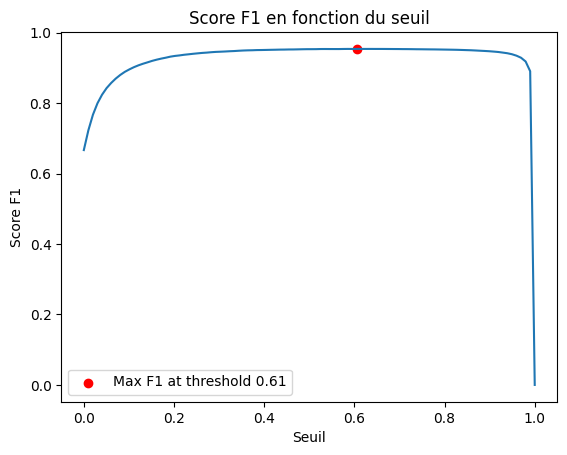

In [106]:
probas_pred = clf.predict_proba(X_test)[:, 1]

# Initialiser les listes pour stocker les résultats
threshold_array = np.linspace(0, 1, 100)
f1_list = []

# Calculer le F1 pour différents seuils
for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (probas_pred > threshold).astype(int)
    # Calcul du f1 pour un seuil donné
    f1_threshold = f1_score(
        y_true=y_test, y_pred=label_pred_threshold
    )

    f1_list.append(f1_threshold)

# Trouver l'indice du maximum de la liste des scores F1
best_threshold_index = np.argmax(f1_list)

# Récupérer le seuil correspondant
best_threshold = threshold_array[best_threshold_index]

# Afficher le graphique
plt.plot(threshold_array, f1_list)
plt.xlabel('Seuil')
plt.ylabel('Score F1')
plt.title('Score F1 en fonction du seuil')
plt.scatter(best_threshold, f1_list[best_threshold_index], color='red', label=f'Max F1 at threshold {best_threshold:.2f}')
plt.legend()
plt.show()

In [107]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_with_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1] > best_threshold).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_with_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché avec le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché avec le seuil optimal: 0.0738537794299876


In [108]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_hide_test, predictions_with_optimal_threshold)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[42240   162]
 [ 3575   149]]


In [109]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_without_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1]).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_without_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché sans le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché sans le seuil optimal: 0.0


## Undersampling

In [110]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
counter = Counter(y_train)
print(counter)

Counter({0: 197877, 1: 17377})


In [111]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy='auto', random_state=42)


X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

/home/work/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [112]:
counter = Counter(y_resampled)
print(counter)

Counter({0: 17377, 1: 17377})


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='f1')

predictions = clf.predict(X_test)

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[1]	training's binary_logloss: 0.677543
[2]	training's binary_logloss: 0.662591


/home/work/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	training's binary_logloss: 0.648213
[4]	training's binary_logloss: 0.634358
[5]	training's binary_logloss: 0.620909
[6]	training's binary_logloss: 0.608042
[7]	training's binary_logloss: 0.595529
[8]	training's binary_logloss: 0.584148
[9]	training's binary_logloss: 0.572275
[10]	training's binary_logloss: 0.560948
[11]	training's binary_logloss: 0.550046
[12]	training's binary_logloss: 0.539493
[13]	training's binary_logloss: 0.529302
[14]	training's binary_logloss: 0.519201
[15]	training's binary_logloss: 0.509622
[16]	training's binary_logloss: 0.500294
[17]	training's binary_logloss: 0.491403
[18]	training's binary_logloss: 0.482766
[19]	training's binary_logloss: 0.474799
[20]	training's binary_logloss: 0.466565
[21]	training's binary_logloss: 0.459049
[22]	training's binary_logloss: 0.451645
[23]	training's binary_logloss: 0.443854
[24]	training's binary_logloss: 0.436306
[25]	training's binary_logloss: 0.429142
[26]	training's binary_logloss: 0.422024
[27]	training's binary_

[202]	training's binary_logloss: 0.0837288
[203]	training's binary_logloss: 0.0834156
[204]	training's binary_logloss: 0.0829047
[205]	training's binary_logloss: 0.0825675
[206]	training's binary_logloss: 0.0822017
[207]	training's binary_logloss: 0.0818977
[208]	training's binary_logloss: 0.0815941
[209]	training's binary_logloss: 0.0810972
[210]	training's binary_logloss: 0.0806767
[211]	training's binary_logloss: 0.0803655
[212]	training's binary_logloss: 0.080019
[213]	training's binary_logloss: 0.0797005
[214]	training's binary_logloss: 0.0793231
[215]	training's binary_logloss: 0.0789976
[216]	training's binary_logloss: 0.0786207
[217]	training's binary_logloss: 0.0783097
[218]	training's binary_logloss: 0.077907
[219]	training's binary_logloss: 0.0776109
[220]	training's binary_logloss: 0.077268
[221]	training's binary_logloss: 0.0769852
[222]	training's binary_logloss: 0.0766449
[223]	training's binary_logloss: 0.0762519
[224]	training's binary_logloss: 0.0759889
[225]	training

[396]	training's binary_logloss: 0.0474679
[397]	training's binary_logloss: 0.0473871
[398]	training's binary_logloss: 0.0473056
[399]	training's binary_logloss: 0.047221
[400]	training's binary_logloss: 0.0471505
[401]	training's binary_logloss: 0.0470673
[402]	training's binary_logloss: 0.046994
[403]	training's binary_logloss: 0.0469113
[404]	training's binary_logloss: 0.0468373
[405]	training's binary_logloss: 0.0467521
[406]	training's binary_logloss: 0.0466551
[407]	training's binary_logloss: 0.0465714
[408]	training's binary_logloss: 0.0464484
[409]	training's binary_logloss: 0.0463605
[410]	training's binary_logloss: 0.046284
[411]	training's binary_logloss: 0.0462061
[412]	training's binary_logloss: 0.0461392
[413]	training's binary_logloss: 0.0460697
[414]	training's binary_logloss: 0.0460014
[415]	training's binary_logloss: 0.0459387
[416]	training's binary_logloss: 0.045857
[417]	training's binary_logloss: 0.0457814
[418]	training's binary_logloss: 0.0457058
[419]	training'

[610]	training's binary_logloss: 0.0354071
[611]	training's binary_logloss: 0.0353739
[612]	training's binary_logloss: 0.0353388
[613]	training's binary_logloss: 0.0353039
[614]	training's binary_logloss: 0.0352561
[615]	training's binary_logloss: 0.0352241
[616]	training's binary_logloss: 0.0351883
[617]	training's binary_logloss: 0.0351542
[618]	training's binary_logloss: 0.0351209
[619]	training's binary_logloss: 0.0350806
[620]	training's binary_logloss: 0.0350452
[621]	training's binary_logloss: 0.0350136
[622]	training's binary_logloss: 0.0349791
[623]	training's binary_logloss: 0.0349428
[624]	training's binary_logloss: 0.0349102
[625]	training's binary_logloss: 0.0348629
[626]	training's binary_logloss: 0.0348243
[627]	training's binary_logloss: 0.0347969
[628]	training's binary_logloss: 0.0347636
[629]	training's binary_logloss: 0.0347246
[630]	training's binary_logloss: 0.0346838
[631]	training's binary_logloss: 0.0346507
[632]	training's binary_logloss: 0.0346181
[633]	train

[804]	training's binary_logloss: 0.0298262
[805]	training's binary_logloss: 0.0298041
[806]	training's binary_logloss: 0.0297804
[807]	training's binary_logloss: 0.029759
[808]	training's binary_logloss: 0.0297416
[809]	training's binary_logloss: 0.0297217
[810]	training's binary_logloss: 0.0296996
[811]	training's binary_logloss: 0.0296745
[812]	training's binary_logloss: 0.0296562
[813]	training's binary_logloss: 0.0296306
[814]	training's binary_logloss: 0.0296072
[815]	training's binary_logloss: 0.0295863
[816]	training's binary_logloss: 0.0295609
[817]	training's binary_logloss: 0.0295405
[818]	training's binary_logloss: 0.0295217
[819]	training's binary_logloss: 0.0294991
[820]	training's binary_logloss: 0.029478
[821]	training's binary_logloss: 0.0294518
[822]	training's binary_logloss: 0.0294304
[823]	training's binary_logloss: 0.0294101
[824]	training's binary_logloss: 0.0293896
[825]	training's binary_logloss: 0.0293691
[826]	training's binary_logloss: 0.0293463
[827]	trainin

[998]	training's binary_logloss: 0.0262447
[999]	training's binary_logloss: 0.026232
[1000]	training's binary_logloss: 0.0262175
[1001]	training's binary_logloss: 0.0262019
[1002]	training's binary_logloss: 0.0261868
[1003]	training's binary_logloss: 0.0261709
[1004]	training's binary_logloss: 0.0261572
[1005]	training's binary_logloss: 0.026143
[1006]	training's binary_logloss: 0.026131
[1007]	training's binary_logloss: 0.0261179
[1008]	training's binary_logloss: 0.0261024
[1009]	training's binary_logloss: 0.0260877
[1010]	training's binary_logloss: 0.0260734
[1011]	training's binary_logloss: 0.0260562
[1012]	training's binary_logloss: 0.0260425
[1013]	training's binary_logloss: 0.026029
[1014]	training's binary_logloss: 0.0260127
[1015]	training's binary_logloss: 0.0259986
[1016]	training's binary_logloss: 0.0259854
[1017]	training's binary_logloss: 0.0259724
[1018]	training's binary_logloss: 0.0259568
[1019]	training's binary_logloss: 0.0259395
[1020]	training's binary_logloss: 0.02

[1192]	training's binary_logloss: 0.0236748
[1193]	training's binary_logloss: 0.0236638
[1194]	training's binary_logloss: 0.0236517
[1195]	training's binary_logloss: 0.023638
[1196]	training's binary_logloss: 0.0236281
[1197]	training's binary_logloss: 0.0236157
[1198]	training's binary_logloss: 0.023607
[1199]	training's binary_logloss: 0.0235976
[1200]	training's binary_logloss: 0.0235854
[1201]	training's binary_logloss: 0.023574
[1202]	training's binary_logloss: 0.023563
[1203]	training's binary_logloss: 0.0235508
[1204]	training's binary_logloss: 0.0235393
[1205]	training's binary_logloss: 0.023529
[1206]	training's binary_logloss: 0.0235177
[1207]	training's binary_logloss: 0.0235057
[1208]	training's binary_logloss: 0.0234947
[1209]	training's binary_logloss: 0.0234844
[1210]	training's binary_logloss: 0.0234732
[1211]	training's binary_logloss: 0.02346
[1212]	training's binary_logloss: 0.0234488
[1213]	training's binary_logloss: 0.0234359
[1214]	training's binary_logloss: 0.023

[1403]	training's binary_logloss: 0.0215442
[1404]	training's binary_logloss: 0.0215341
[1405]	training's binary_logloss: 0.0215263
[1406]	training's binary_logloss: 0.0215171
[1407]	training's binary_logloss: 0.0215095
[1408]	training's binary_logloss: 0.0215005
[1409]	training's binary_logloss: 0.0214878
[1410]	training's binary_logloss: 0.0214793
[1411]	training's binary_logloss: 0.0214702
[1412]	training's binary_logloss: 0.0214622
[1413]	training's binary_logloss: 0.0214538
[1414]	training's binary_logloss: 0.0214446
[1415]	training's binary_logloss: 0.0214346
[1416]	training's binary_logloss: 0.0214265
[1417]	training's binary_logloss: 0.0214179
[1418]	training's binary_logloss: 0.0214112
[1419]	training's binary_logloss: 0.021403
[1420]	training's binary_logloss: 0.0213951
[1421]	training's binary_logloss: 0.0213863
[1422]	training's binary_logloss: 0.0213805
[1423]	training's binary_logloss: 0.0213689
[1424]	training's binary_logloss: 0.0213623
[1425]	training's binary_logloss:

[1600]	training's binary_logloss: 0.0199835
[1601]	training's binary_logloss: 0.0199771
[1602]	training's binary_logloss: 0.0199706
[1603]	training's binary_logloss: 0.0199614
[1604]	training's binary_logloss: 0.019955
[1605]	training's binary_logloss: 0.0199446
[1606]	training's binary_logloss: 0.019937
[1607]	training's binary_logloss: 0.0199289
[1608]	training's binary_logloss: 0.0199215
[1609]	training's binary_logloss: 0.0199163
[1610]	training's binary_logloss: 0.0199076
[1611]	training's binary_logloss: 0.0199002
[1612]	training's binary_logloss: 0.0198928
[1613]	training's binary_logloss: 0.0198862
[1614]	training's binary_logloss: 0.0198791
[1615]	training's binary_logloss: 0.0198695
[1616]	training's binary_logloss: 0.019862
[1617]	training's binary_logloss: 0.0198536
[1618]	training's binary_logloss: 0.0198477
[1619]	training's binary_logloss: 0.0198376
[1620]	training's binary_logloss: 0.0198318
[1621]	training's binary_logloss: 0.0198239
[1622]	training's binary_logloss: 0

[1798]	training's binary_logloss: 0.0186817
[1799]	training's binary_logloss: 0.0186764
[1800]	training's binary_logloss: 0.0186729
[1801]	training's binary_logloss: 0.0186661
[1802]	training's binary_logloss: 0.0186595
[1803]	training's binary_logloss: 0.0186548
[1804]	training's binary_logloss: 0.0186498
[1805]	training's binary_logloss: 0.0186432
[1806]	training's binary_logloss: 0.0186365
[1807]	training's binary_logloss: 0.0186292
[1808]	training's binary_logloss: 0.0186225
[1809]	training's binary_logloss: 0.0186167
[1810]	training's binary_logloss: 0.0186104
[1811]	training's binary_logloss: 0.0186037
[1812]	training's binary_logloss: 0.0185999
[1813]	training's binary_logloss: 0.0185953
[1814]	training's binary_logloss: 0.0185908
[1815]	training's binary_logloss: 0.0185854
[1816]	training's binary_logloss: 0.0185792
[1817]	training's binary_logloss: 0.0185718
[1818]	training's binary_logloss: 0.0185676
[1819]	training's binary_logloss: 0.0185628
[1820]	training's binary_logloss

[1996]	training's binary_logloss: 0.0176147
[1997]	training's binary_logloss: 0.0176087
[1998]	training's binary_logloss: 0.0176049
[1999]	training's binary_logloss: 0.0175993
[2000]	training's binary_logloss: 0.0175938
[2001]	training's binary_logloss: 0.0175886
[2002]	training's binary_logloss: 0.0175841
[2003]	training's binary_logloss: 0.0175803
[2004]	training's binary_logloss: 0.0175756
[2005]	training's binary_logloss: 0.0175694
[2006]	training's binary_logloss: 0.0175658
[2007]	training's binary_logloss: 0.0175603
[2008]	training's binary_logloss: 0.017556
[2009]	training's binary_logloss: 0.0175517
[2010]	training's binary_logloss: 0.0175466
[2011]	training's binary_logloss: 0.0175396
[2012]	training's binary_logloss: 0.0175351
[2013]	training's binary_logloss: 0.0175293
[2014]	training's binary_logloss: 0.0175231
[2015]	training's binary_logloss: 0.0175194
[2016]	training's binary_logloss: 0.0175141
[2017]	training's binary_logloss: 0.0175078
[2018]	training's binary_logloss:

[2228]	training's binary_logloss: 0.0165662
[2229]	training's binary_logloss: 0.0165588
[2230]	training's binary_logloss: 0.0165564
[2231]	training's binary_logloss: 0.0165528
[2232]	training's binary_logloss: 0.016548
[2233]	training's binary_logloss: 0.0165427
[2234]	training's binary_logloss: 0.0165368
[2235]	training's binary_logloss: 0.0165332
[2236]	training's binary_logloss: 0.0165285
[2237]	training's binary_logloss: 0.0165232
[2238]	training's binary_logloss: 0.0165189
[2239]	training's binary_logloss: 0.0165143
[2240]	training's binary_logloss: 0.0165093
[2241]	training's binary_logloss: 0.0165046
[2242]	training's binary_logloss: 0.0165021
[2243]	training's binary_logloss: 0.0164985
[2244]	training's binary_logloss: 0.0164931
[2245]	training's binary_logloss: 0.01649
[2246]	training's binary_logloss: 0.0164843
[2247]	training's binary_logloss: 0.0164789
[2248]	training's binary_logloss: 0.0164751
[2249]	training's binary_logloss: 0.0164707
[2250]	training's binary_logloss: 0

[2449]	training's binary_logloss: 0.0157114
[2450]	training's binary_logloss: 0.0157079
[2451]	training's binary_logloss: 0.0157061
[2452]	training's binary_logloss: 0.0157034
[2453]	training's binary_logloss: 0.0156988
[2454]	training's binary_logloss: 0.0156939
[2455]	training's binary_logloss: 0.0156901
[2456]	training's binary_logloss: 0.0156857
[2457]	training's binary_logloss: 0.0156811
[2458]	training's binary_logloss: 0.0156777
[2459]	training's binary_logloss: 0.0156746
[2460]	training's binary_logloss: 0.0156717
[2461]	training's binary_logloss: 0.0156664
[2462]	training's binary_logloss: 0.0156624
[2463]	training's binary_logloss: 0.0156585
[2464]	training's binary_logloss: 0.0156553
[2465]	training's binary_logloss: 0.0156526
[2466]	training's binary_logloss: 0.0156494
[2467]	training's binary_logloss: 0.0156463
[2468]	training's binary_logloss: 0.0156431
[2469]	training's binary_logloss: 0.0156389
[2470]	training's binary_logloss: 0.0156332
[2471]	training's binary_logloss

[2672]	training's binary_logloss: 0.0149471
[2673]	training's binary_logloss: 0.0149439
[2674]	training's binary_logloss: 0.0149407
[2675]	training's binary_logloss: 0.0149382
[2676]	training's binary_logloss: 0.0149356
[2677]	training's binary_logloss: 0.014933
[2678]	training's binary_logloss: 0.0149305
[2679]	training's binary_logloss: 0.0149288
[2680]	training's binary_logloss: 0.0149259
[2681]	training's binary_logloss: 0.0149235
[2682]	training's binary_logloss: 0.01492
[2683]	training's binary_logloss: 0.0149183
[2684]	training's binary_logloss: 0.0149159
[2685]	training's binary_logloss: 0.0149121
[2686]	training's binary_logloss: 0.0149092
[2687]	training's binary_logloss: 0.0149061
[2688]	training's binary_logloss: 0.0149024
[2689]	training's binary_logloss: 0.0148984
[2690]	training's binary_logloss: 0.0148949
[2691]	training's binary_logloss: 0.0148933
[2692]	training's binary_logloss: 0.0148906
[2693]	training's binary_logloss: 0.0148874
[2694]	training's binary_logloss: 0

[2900]	training's binary_logloss: 0.0142756
[2901]	training's binary_logloss: 0.0142722
[2902]	training's binary_logloss: 0.014269
[2903]	training's binary_logloss: 0.014265
[2904]	training's binary_logloss: 0.0142634
[2905]	training's binary_logloss: 0.0142611
[2906]	training's binary_logloss: 0.0142578
[2907]	training's binary_logloss: 0.0142553
[2908]	training's binary_logloss: 0.0142524
[2909]	training's binary_logloss: 0.0142491
[2910]	training's binary_logloss: 0.014245
[2911]	training's binary_logloss: 0.0142428
[2912]	training's binary_logloss: 0.0142401
[2913]	training's binary_logloss: 0.0142365
[2914]	training's binary_logloss: 0.0142338
[2915]	training's binary_logloss: 0.0142311
[2916]	training's binary_logloss: 0.0142275
[2917]	training's binary_logloss: 0.0142238
[2918]	training's binary_logloss: 0.0142213
[2919]	training's binary_logloss: 0.0142178
[2920]	training's binary_logloss: 0.014216
[2921]	training's binary_logloss: 0.0142138
[2922]	training's binary_logloss: 0.

[3138]	training's binary_logloss: 0.013629
[3139]	training's binary_logloss: 0.0136258
[3140]	training's binary_logloss: 0.0136229
[3141]	training's binary_logloss: 0.0136211
[3142]	training's binary_logloss: 0.0136198
[3143]	training's binary_logloss: 0.0136166
[3144]	training's binary_logloss: 0.0136151
[3145]	training's binary_logloss: 0.0136136
[3146]	training's binary_logloss: 0.0136114
[3147]	training's binary_logloss: 0.0136097
[3148]	training's binary_logloss: 0.0136071
[3149]	training's binary_logloss: 0.0136057
[3150]	training's binary_logloss: 0.013604
[3151]	training's binary_logloss: 0.013601
[3152]	training's binary_logloss: 0.0135989
[3153]	training's binary_logloss: 0.0135972
[3154]	training's binary_logloss: 0.0135936
[3155]	training's binary_logloss: 0.0135919
[3156]	training's binary_logloss: 0.0135884
[3157]	training's binary_logloss: 0.0135852
[3158]	training's binary_logloss: 0.0135817
[3159]	training's binary_logloss: 0.0135785
[3160]	training's binary_logloss: 0

[3377]	training's binary_logloss: 0.0130786
[3378]	training's binary_logloss: 0.0130769
[3379]	training's binary_logloss: 0.0130746
[3380]	training's binary_logloss: 0.0130732
[3381]	training's binary_logloss: 0.0130704
[3382]	training's binary_logloss: 0.0130689
[3383]	training's binary_logloss: 0.0130676
[3384]	training's binary_logloss: 0.0130662
[3385]	training's binary_logloss: 0.0130635
[3386]	training's binary_logloss: 0.0130615
[3387]	training's binary_logloss: 0.0130592
[3388]	training's binary_logloss: 0.013056
[3389]	training's binary_logloss: 0.0130531
[3390]	training's binary_logloss: 0.0130504
[3391]	training's binary_logloss: 0.0130481
[3392]	training's binary_logloss: 0.0130467
[3393]	training's binary_logloss: 0.0130451
[3394]	training's binary_logloss: 0.0130439
[3395]	training's binary_logloss: 0.0130423
[3396]	training's binary_logloss: 0.0130403
[3397]	training's binary_logloss: 0.013039
[3398]	training's binary_logloss: 0.0130375
[3399]	training's binary_logloss: 

[3603]	training's binary_logloss: 0.0126195
[3604]	training's binary_logloss: 0.0126172
[3605]	training's binary_logloss: 0.012616
[3606]	training's binary_logloss: 0.0126139
[3607]	training's binary_logloss: 0.0126112
[3608]	training's binary_logloss: 0.0126091
[3609]	training's binary_logloss: 0.012607
[3610]	training's binary_logloss: 0.0126057
[3611]	training's binary_logloss: 0.0126045
[3612]	training's binary_logloss: 0.0126031
[3613]	training's binary_logloss: 0.0126007
[3614]	training's binary_logloss: 0.0126
[3615]	training's binary_logloss: 0.0125983
[3616]	training's binary_logloss: 0.0125966
[3617]	training's binary_logloss: 0.0125952
[3618]	training's binary_logloss: 0.012593
[3619]	training's binary_logloss: 0.0125898
[3620]	training's binary_logloss: 0.0125871
[3621]	training's binary_logloss: 0.0125846
[3622]	training's binary_logloss: 0.0125821
[3623]	training's binary_logloss: 0.0125795
[3624]	training's binary_logloss: 0.0125777
[3625]	training's binary_logloss: 0.01

[3816]	training's binary_logloss: 0.0122223
[3817]	training's binary_logloss: 0.0122203
[3818]	training's binary_logloss: 0.0122182
[3819]	training's binary_logloss: 0.0122165
[3820]	training's binary_logloss: 0.0122145
[3821]	training's binary_logloss: 0.012212
[3822]	training's binary_logloss: 0.0122106
[3823]	training's binary_logloss: 0.0122083
[3824]	training's binary_logloss: 0.0122077
[3825]	training's binary_logloss: 0.0122057
[3826]	training's binary_logloss: 0.0122035
[3827]	training's binary_logloss: 0.0122021
[3828]	training's binary_logloss: 0.0122002
[3829]	training's binary_logloss: 0.012199
[3830]	training's binary_logloss: 0.0121979
[3831]	training's binary_logloss: 0.0121965
[3832]	training's binary_logloss: 0.0121955
[3833]	training's binary_logloss: 0.0121932
[3834]	training's binary_logloss: 0.0121918
[3835]	training's binary_logloss: 0.0121906
[3836]	training's binary_logloss: 0.0121892
[3837]	training's binary_logloss: 0.0121879
[3838]	training's binary_logloss: 

[4005]	training's binary_logloss: 0.0119032
[4006]	training's binary_logloss: 0.011901
[4007]	training's binary_logloss: 0.0118997
[4008]	training's binary_logloss: 0.0118987
[4009]	training's binary_logloss: 0.0118975
[4010]	training's binary_logloss: 0.0118963
[4011]	training's binary_logloss: 0.0118953
[4012]	training's binary_logloss: 0.0118942
[4013]	training's binary_logloss: 0.0118917
[4014]	training's binary_logloss: 0.0118895
[4015]	training's binary_logloss: 0.0118877
[4016]	training's binary_logloss: 0.011887
[4017]	training's binary_logloss: 0.0118846
[4018]	training's binary_logloss: 0.0118827
[4019]	training's binary_logloss: 0.0118816
[4020]	training's binary_logloss: 0.0118797
[4021]	training's binary_logloss: 0.0118781
[4022]	training's binary_logloss: 0.0118775
[4023]	training's binary_logloss: 0.0118753
[4024]	training's binary_logloss: 0.0118741
[4025]	training's binary_logloss: 0.0118718
[4026]	training's binary_logloss: 0.01187
[4027]	training's binary_logloss: 0.

[4204]	training's binary_logloss: 0.011601
[4205]	training's binary_logloss: 0.0116
[4206]	training's binary_logloss: 0.011599
[4207]	training's binary_logloss: 0.011598
[4208]	training's binary_logloss: 0.0115971
[4209]	training's binary_logloss: 0.0115952
[4210]	training's binary_logloss: 0.011593
[4211]	training's binary_logloss: 0.0115916
[4212]	training's binary_logloss: 0.0115905
[4213]	training's binary_logloss: 0.011589
[4214]	training's binary_logloss: 0.0115871
[4215]	training's binary_logloss: 0.011585
[4216]	training's binary_logloss: 0.0115833
[4217]	training's binary_logloss: 0.0115815
[4218]	training's binary_logloss: 0.0115804
[4219]	training's binary_logloss: 0.0115789
[4220]	training's binary_logloss: 0.0115779
[4221]	training's binary_logloss: 0.0115756
[4222]	training's binary_logloss: 0.0115741
[4223]	training's binary_logloss: 0.0115722
[4224]	training's binary_logloss: 0.01157
[4225]	training's binary_logloss: 0.011568
[4226]	training's binary_logloss: 0.0115674


[4393]	training's binary_logloss: 0.011325
[4394]	training's binary_logloss: 0.0113238
[4395]	training's binary_logloss: 0.0113221
[4396]	training's binary_logloss: 0.0113209
[4397]	training's binary_logloss: 0.0113196
[4398]	training's binary_logloss: 0.0113179
[4399]	training's binary_logloss: 0.0113165
[4400]	training's binary_logloss: 0.0113155
[4401]	training's binary_logloss: 0.0113145
[4402]	training's binary_logloss: 0.0113128
[4403]	training's binary_logloss: 0.0113117
[4404]	training's binary_logloss: 0.0113106
[4405]	training's binary_logloss: 0.0113087
[4406]	training's binary_logloss: 0.0113065
[4407]	training's binary_logloss: 0.0113052
[4408]	training's binary_logloss: 0.0113041
[4409]	training's binary_logloss: 0.0113025
[4410]	training's binary_logloss: 0.0113015
[4411]	training's binary_logloss: 0.0113009
[4412]	training's binary_logloss: 0.0112998
[4413]	training's binary_logloss: 0.0112982
[4414]	training's binary_logloss: 0.0112973
[4415]	training's binary_logloss:

[4583]	training's binary_logloss: 0.0110831
[4584]	training's binary_logloss: 0.0110822
[4585]	training's binary_logloss: 0.0110814
[4586]	training's binary_logloss: 0.0110797
[4587]	training's binary_logloss: 0.0110788
[4588]	training's binary_logloss: 0.0110771
[4589]	training's binary_logloss: 0.0110752
[4590]	training's binary_logloss: 0.0110738
[4591]	training's binary_logloss: 0.0110727
[4592]	training's binary_logloss: 0.0110719
[4593]	training's binary_logloss: 0.011071
[4594]	training's binary_logloss: 0.01107
[4595]	training's binary_logloss: 0.0110694
[4596]	training's binary_logloss: 0.0110685
[4597]	training's binary_logloss: 0.0110676
[4598]	training's binary_logloss: 0.0110667
[4599]	training's binary_logloss: 0.0110658
[4600]	training's binary_logloss: 0.0110647
[4601]	training's binary_logloss: 0.0110637
[4602]	training's binary_logloss: 0.0110617
[4603]	training's binary_logloss: 0.0110602
[4604]	training's binary_logloss: 0.0110581
[4605]	training's binary_logloss: 0

[4783]	training's binary_logloss: 0.0108418
[4784]	training's binary_logloss: 0.0108405
[4785]	training's binary_logloss: 0.0108396
[4786]	training's binary_logloss: 0.0108391
[4787]	training's binary_logloss: 0.0108382
[4788]	training's binary_logloss: 0.0108374
[4789]	training's binary_logloss: 0.0108364
[4790]	training's binary_logloss: 0.0108347
[4791]	training's binary_logloss: 0.0108335
[4792]	training's binary_logloss: 0.0108323
[4793]	training's binary_logloss: 0.0108307
[4794]	training's binary_logloss: 0.0108296
[4795]	training's binary_logloss: 0.0108284
[4796]	training's binary_logloss: 0.0108263
[4797]	training's binary_logloss: 0.010825
[4798]	training's binary_logloss: 0.010824
[4799]	training's binary_logloss: 0.0108225
[4800]	training's binary_logloss: 0.0108219
[4801]	training's binary_logloss: 0.0108211
[4802]	training's binary_logloss: 0.0108206
[4803]	training's binary_logloss: 0.0108198
[4804]	training's binary_logloss: 0.0108188
[4805]	training's binary_logloss: 

[4977]	training's binary_logloss: 0.0106175
[4978]	training's binary_logloss: 0.0106167
[4979]	training's binary_logloss: 0.0106157
[4980]	training's binary_logloss: 0.0106143
[4981]	training's binary_logloss: 0.0106128
[4982]	training's binary_logloss: 0.0106116
[4983]	training's binary_logloss: 0.01061
[4984]	training's binary_logloss: 0.0106081
[4985]	training's binary_logloss: 0.0106076
[4986]	training's binary_logloss: 0.0106063
[4987]	training's binary_logloss: 0.0106048
[4988]	training's binary_logloss: 0.0106033
[4989]	training's binary_logloss: 0.0106023
[4990]	training's binary_logloss: 0.0106015
[4991]	training's binary_logloss: 0.0106008
[4992]	training's binary_logloss: 0.0105998
[4993]	training's binary_logloss: 0.0105982
[4994]	training's binary_logloss: 0.0105966
[4995]	training's binary_logloss: 0.0105955
[4996]	training's binary_logloss: 0.0105941
[4997]	training's binary_logloss: 0.0105927
[4998]	training's binary_logloss: 0.010592
[4999]	training's binary_logloss: 0

[5185]	training's binary_logloss: 0.0103935
[5186]	training's binary_logloss: 0.0103926
[5187]	training's binary_logloss: 0.0103916
[5188]	training's binary_logloss: 0.0103907
[5189]	training's binary_logloss: 0.0103896
[5190]	training's binary_logloss: 0.0103886
[5191]	training's binary_logloss: 0.0103871
[5192]	training's binary_logloss: 0.0103861
[5193]	training's binary_logloss: 0.010385
[5194]	training's binary_logloss: 0.0103836
[5195]	training's binary_logloss: 0.0103824
[5196]	training's binary_logloss: 0.0103802
[5197]	training's binary_logloss: 0.0103798
[5198]	training's binary_logloss: 0.0103788
[5199]	training's binary_logloss: 0.0103783
[5200]	training's binary_logloss: 0.0103779
[5201]	training's binary_logloss: 0.0103772
[5202]	training's binary_logloss: 0.0103765
[5203]	training's binary_logloss: 0.0103753
[5204]	training's binary_logloss: 0.0103742
[5205]	training's binary_logloss: 0.0103734
[5206]	training's binary_logloss: 0.0103726
[5207]	training's binary_logloss:

[5398]	training's binary_logloss: 0.0101773
[5399]	training's binary_logloss: 0.0101757
[5400]	training's binary_logloss: 0.0101747
[5401]	training's binary_logloss: 0.0101739
[5402]	training's binary_logloss: 0.0101728
[5403]	training's binary_logloss: 0.0101713
[5404]	training's binary_logloss: 0.0101704
[5405]	training's binary_logloss: 0.0101694
[5406]	training's binary_logloss: 0.0101678
[5407]	training's binary_logloss: 0.010167
[5408]	training's binary_logloss: 0.0101653
[5409]	training's binary_logloss: 0.0101645
[5410]	training's binary_logloss: 0.0101636
[5411]	training's binary_logloss: 0.0101632
[5412]	training's binary_logloss: 0.010162
[5413]	training's binary_logloss: 0.0101611
[5414]	training's binary_logloss: 0.0101601
[5415]	training's binary_logloss: 0.0101594
[5416]	training's binary_logloss: 0.0101583
[5417]	training's binary_logloss: 0.0101571
[5418]	training's binary_logloss: 0.0101562
[5419]	training's binary_logloss: 0.0101552
[5420]	training's binary_logloss: 

[5612]	training's binary_logloss: 0.00997016
[5613]	training's binary_logloss: 0.0099693
[5614]	training's binary_logloss: 0.00996846
[5615]	training's binary_logloss: 0.00996712
[5616]	training's binary_logloss: 0.00996581
[5617]	training's binary_logloss: 0.00996499
[5618]	training's binary_logloss: 0.00996433
[5619]	training's binary_logloss: 0.00996384
[5620]	training's binary_logloss: 0.00996341
[5621]	training's binary_logloss: 0.00996297
[5622]	training's binary_logloss: 0.00996124
[5623]	training's binary_logloss: 0.00996004
[5624]	training's binary_logloss: 0.00995945
[5625]	training's binary_logloss: 0.00995859
[5626]	training's binary_logloss: 0.00995759
[5627]	training's binary_logloss: 0.00995716
[5628]	training's binary_logloss: 0.00995667
[5629]	training's binary_logloss: 0.00995596
[5630]	training's binary_logloss: 0.00995488
[5631]	training's binary_logloss: 0.00995406
[5632]	training's binary_logloss: 0.00995275
[5633]	training's binary_logloss: 0.00995132
[5634]	trai

[5823]	training's binary_logloss: 0.00978371
[5824]	training's binary_logloss: 0.00978329
[5825]	training's binary_logloss: 0.00978249
[5826]	training's binary_logloss: 0.00978154
[5827]	training's binary_logloss: 0.00978065
[5828]	training's binary_logloss: 0.0097791
[5829]	training's binary_logloss: 0.00977798
[5830]	training's binary_logloss: 0.00977694
[5831]	training's binary_logloss: 0.00977639
[5832]	training's binary_logloss: 0.00977593
[5833]	training's binary_logloss: 0.00977494
[5834]	training's binary_logloss: 0.00977445
[5835]	training's binary_logloss: 0.00977359
[5836]	training's binary_logloss: 0.00977262
[5837]	training's binary_logloss: 0.00977103
[5838]	training's binary_logloss: 0.00977062
[5839]	training's binary_logloss: 0.00976948
[5840]	training's binary_logloss: 0.0097679
[5841]	training's binary_logloss: 0.00976692
[5842]	training's binary_logloss: 0.00976585
[5843]	training's binary_logloss: 0.00976506
[5844]	training's binary_logloss: 0.00976466
[5845]	train

[6020]	training's binary_logloss: 0.00962224
[6021]	training's binary_logloss: 0.00962147
[6022]	training's binary_logloss: 0.0096203
[6023]	training's binary_logloss: 0.00961916
[6024]	training's binary_logloss: 0.00961878
[6025]	training's binary_logloss: 0.00961836
[6026]	training's binary_logloss: 0.00961798
[6027]	training's binary_logloss: 0.00961757
[6028]	training's binary_logloss: 0.00961593
[6029]	training's binary_logloss: 0.00961464
[6030]	training's binary_logloss: 0.00961369
[6031]	training's binary_logloss: 0.00961265
[6032]	training's binary_logloss: 0.00961162
[6033]	training's binary_logloss: 0.00961091
[6034]	training's binary_logloss: 0.0096105
[6035]	training's binary_logloss: 0.00961011
[6036]	training's binary_logloss: 0.00960935
[6037]	training's binary_logloss: 0.00960837
[6038]	training's binary_logloss: 0.00960726
[6039]	training's binary_logloss: 0.00960614
[6040]	training's binary_logloss: 0.00960519
[6041]	training's binary_logloss: 0.00960414
[6042]	train

[6226]	training's binary_logloss: 0.00945681
[6227]	training's binary_logloss: 0.00945643
[6228]	training's binary_logloss: 0.00945604
[6229]	training's binary_logloss: 0.0094549
[6230]	training's binary_logloss: 0.00945404
[6231]	training's binary_logloss: 0.00945331
[6232]	training's binary_logloss: 0.00945294
[6233]	training's binary_logloss: 0.00945195
[6234]	training's binary_logloss: 0.00945098
[6235]	training's binary_logloss: 0.00945008
[6236]	training's binary_logloss: 0.0094493
[6237]	training's binary_logloss: 0.00944873
[6238]	training's binary_logloss: 0.009448
[6239]	training's binary_logloss: 0.00944764
[6240]	training's binary_logloss: 0.00944728
[6241]	training's binary_logloss: 0.00944649
[6242]	training's binary_logloss: 0.0094456
[6243]	training's binary_logloss: 0.00944488
[6244]	training's binary_logloss: 0.00944371
[6245]	training's binary_logloss: 0.00944276
[6246]	training's binary_logloss: 0.009442
[6247]	training's binary_logloss: 0.00944112
[6248]	training's

[6418]	training's binary_logloss: 0.00931174
[6419]	training's binary_logloss: 0.00931046
[6420]	training's binary_logloss: 0.00930973
[6421]	training's binary_logloss: 0.00930889
[6422]	training's binary_logloss: 0.00930799
[6423]	training's binary_logloss: 0.00930763
[6424]	training's binary_logloss: 0.00930725
[6425]	training's binary_logloss: 0.00930689
[6426]	training's binary_logloss: 0.00930651
[6427]	training's binary_logloss: 0.00930615
[6428]	training's binary_logloss: 0.00930502
[6429]	training's binary_logloss: 0.00930464
[6430]	training's binary_logloss: 0.00930364
[6431]	training's binary_logloss: 0.0093028
[6432]	training's binary_logloss: 0.00930197
[6433]	training's binary_logloss: 0.00930136
[6434]	training's binary_logloss: 0.00930046
[6435]	training's binary_logloss: 0.00930009
[6436]	training's binary_logloss: 0.00929922
[6437]	training's binary_logloss: 0.00929843
[6438]	training's binary_logloss: 0.00929767
[6439]	training's binary_logloss: 0.0092973
[6440]	train

[6607]	training's binary_logloss: 0.00917074
[6608]	training's binary_logloss: 0.00917017
[6609]	training's binary_logloss: 0.00916942
[6610]	training's binary_logloss: 0.00916871
[6611]	training's binary_logloss: 0.0091678
[6612]	training's binary_logloss: 0.00916711
[6613]	training's binary_logloss: 0.00916616
[6614]	training's binary_logloss: 0.00916552
[6615]	training's binary_logloss: 0.00916459
[6616]	training's binary_logloss: 0.00916361
[6617]	training's binary_logloss: 0.00916279
[6618]	training's binary_logloss: 0.00916244
[6619]	training's binary_logloss: 0.00916218
[6620]	training's binary_logloss: 0.00916146
[6621]	training's binary_logloss: 0.00916111
[6622]	training's binary_logloss: 0.00916074
[6623]	training's binary_logloss: 0.00916003
[6624]	training's binary_logloss: 0.00915967
[6625]	training's binary_logloss: 0.00915942
[6626]	training's binary_logloss: 0.00915906
[6627]	training's binary_logloss: 0.0091587
[6628]	training's binary_logloss: 0.00915792
[6629]	train

[6825]	training's binary_logloss: 0.00902707
[6826]	training's binary_logloss: 0.00902641
[6827]	training's binary_logloss: 0.00902611
[6828]	training's binary_logloss: 0.00902508
[6829]	training's binary_logloss: 0.00902401
[6830]	training's binary_logloss: 0.00902307
[6831]	training's binary_logloss: 0.00902223
[6832]	training's binary_logloss: 0.00902144
[6833]	training's binary_logloss: 0.00902102
[6834]	training's binary_logloss: 0.00902024
[6835]	training's binary_logloss: 0.00901927
[6836]	training's binary_logloss: 0.00901887
[6837]	training's binary_logloss: 0.0090185
[6838]	training's binary_logloss: 0.00901816
[6839]	training's binary_logloss: 0.00901791
[6840]	training's binary_logloss: 0.00901752
[6841]	training's binary_logloss: 0.00901719
[6842]	training's binary_logloss: 0.00901694
[6843]	training's binary_logloss: 0.00901661
[6844]	training's binary_logloss: 0.00901636
[6845]	training's binary_logloss: 0.00901549
[6846]	training's binary_logloss: 0.00901474
[6847]	trai

[7042]	training's binary_logloss: 0.00888507
[7043]	training's binary_logloss: 0.00888432
[7044]	training's binary_logloss: 0.00888319
[7045]	training's binary_logloss: 0.00888245
[7046]	training's binary_logloss: 0.00888169
[7047]	training's binary_logloss: 0.00888098
[7048]	training's binary_logloss: 0.00888066
[7049]	training's binary_logloss: 0.00888033
[7050]	training's binary_logloss: 0.00888009
[7051]	training's binary_logloss: 0.00887928
[7052]	training's binary_logloss: 0.00887854
[7053]	training's binary_logloss: 0.00887816
[7054]	training's binary_logloss: 0.00887748
[7055]	training's binary_logloss: 0.00887671
[7056]	training's binary_logloss: 0.00887602
[7057]	training's binary_logloss: 0.00887527
[7058]	training's binary_logloss: 0.00887456
[7059]	training's binary_logloss: 0.00887387
[7060]	training's binary_logloss: 0.00887313
[7061]	training's binary_logloss: 0.00887217
[7062]	training's binary_logloss: 0.00887136
[7063]	training's binary_logloss: 0.00887059
[7064]	tra

[7264]	training's binary_logloss: 0.00875462
[7265]	training's binary_logloss: 0.00875392
[7266]	training's binary_logloss: 0.00875297
[7267]	training's binary_logloss: 0.00875201
[7268]	training's binary_logloss: 0.00875131
[7269]	training's binary_logloss: 0.00875104
[7270]	training's binary_logloss: 0.00875027
[7271]	training's binary_logloss: 0.00874997
[7272]	training's binary_logloss: 0.00874921
[7273]	training's binary_logloss: 0.00874843
[7274]	training's binary_logloss: 0.00874799
[7275]	training's binary_logloss: 0.00874766
[7276]	training's binary_logloss: 0.00874731
[7277]	training's binary_logloss: 0.00874702
[7278]	training's binary_logloss: 0.00874669
[7279]	training's binary_logloss: 0.0087464
[7280]	training's binary_logloss: 0.00874616
[7281]	training's binary_logloss: 0.00874584
[7282]	training's binary_logloss: 0.0087451
[7283]	training's binary_logloss: 0.00874456
[7284]	training's binary_logloss: 0.0087442
[7285]	training's binary_logloss: 0.00874353
[7286]	traini

[7472]	training's binary_logloss: 0.00863713
[7473]	training's binary_logloss: 0.00863679
[7474]	training's binary_logloss: 0.00863596
[7475]	training's binary_logloss: 0.00863526
[7476]	training's binary_logloss: 0.00863469
[7477]	training's binary_logloss: 0.00863383
[7478]	training's binary_logloss: 0.00863303
[7479]	training's binary_logloss: 0.00863237
[7480]	training's binary_logloss: 0.00863151
[7481]	training's binary_logloss: 0.00863077
[7482]	training's binary_logloss: 0.00862995
[7483]	training's binary_logloss: 0.00862926
[7484]	training's binary_logloss: 0.00862871
[7485]	training's binary_logloss: 0.00862802
[7486]	training's binary_logloss: 0.0086273
[7487]	training's binary_logloss: 0.00862658
[7488]	training's binary_logloss: 0.00862629
[7489]	training's binary_logloss: 0.00862598
[7490]	training's binary_logloss: 0.00862569
[7491]	training's binary_logloss: 0.00862547
[7492]	training's binary_logloss: 0.00862463
[7493]	training's binary_logloss: 0.00862395
[7494]	trai

[7676]	training's binary_logloss: 0.00852632
[7677]	training's binary_logloss: 0.00852611
[7678]	training's binary_logloss: 0.00852526
[7679]	training's binary_logloss: 0.00852469
[7680]	training's binary_logloss: 0.00852386
[7681]	training's binary_logloss: 0.00852331
[7682]	training's binary_logloss: 0.00852301
[7683]	training's binary_logloss: 0.00852233
[7684]	training's binary_logloss: 0.00852118
[7685]	training's binary_logloss: 0.00852087
[7686]	training's binary_logloss: 0.00852065
[7687]	training's binary_logloss: 0.00852045
[7688]	training's binary_logloss: 0.00851973
[7689]	training's binary_logloss: 0.00851934
[7690]	training's binary_logloss: 0.00851868
[7691]	training's binary_logloss: 0.00851807
[7692]	training's binary_logloss: 0.00851777
[7693]	training's binary_logloss: 0.00851756
[7694]	training's binary_logloss: 0.00851734
[7695]	training's binary_logloss: 0.00851713
[7696]	training's binary_logloss: 0.00851682
[7697]	training's binary_logloss: 0.00851662
[7698]	tra

[7884]	training's binary_logloss: 0.00841299
[7885]	training's binary_logloss: 0.00841279
[7886]	training's binary_logloss: 0.0084125
[7887]	training's binary_logloss: 0.00841188
[7888]	training's binary_logloss: 0.00841131
[7889]	training's binary_logloss: 0.00841095
[7890]	training's binary_logloss: 0.00841075
[7891]	training's binary_logloss: 0.00841054
[7892]	training's binary_logloss: 0.00841034
[7893]	training's binary_logloss: 0.00841004
[7894]	training's binary_logloss: 0.00840919
[7895]	training's binary_logloss: 0.00840899
[7896]	training's binary_logloss: 0.00840877
[7897]	training's binary_logloss: 0.00840857
[7898]	training's binary_logloss: 0.00840835
[7899]	training's binary_logloss: 0.00840806
[7900]	training's binary_logloss: 0.00840739
[7901]	training's binary_logloss: 0.00840719
[7902]	training's binary_logloss: 0.00840675
[7903]	training's binary_logloss: 0.0084061
[7904]	training's binary_logloss: 0.00840555
[7905]	training's binary_logloss: 0.00840516
[7906]	train

[8090]	training's binary_logloss: 0.00831382
[8091]	training's binary_logloss: 0.00831363
[8092]	training's binary_logloss: 0.008313
[8093]	training's binary_logloss: 0.00831272
[8094]	training's binary_logloss: 0.00831251
[8095]	training's binary_logloss: 0.00831231
[8096]	training's binary_logloss: 0.00831185
[8097]	training's binary_logloss: 0.00831156
[8098]	training's binary_logloss: 0.00831137
[8099]	training's binary_logloss: 0.00831116
[8100]	training's binary_logloss: 0.00831096
[8101]	training's binary_logloss: 0.00831068
[8102]	training's binary_logloss: 0.00831015
[8103]	training's binary_logloss: 0.0083098
[8104]	training's binary_logloss: 0.0083096
[8105]	training's binary_logloss: 0.00830939
[8106]	training's binary_logloss: 0.0083092
[8107]	training's binary_logloss: 0.00830892
[8108]	training's binary_logloss: 0.00830872
[8109]	training's binary_logloss: 0.00830851
[8110]	training's binary_logloss: 0.00830782
[8111]	training's binary_logloss: 0.00830745
[8112]	training

[8315]	training's binary_logloss: 0.00821543
[8316]	training's binary_logloss: 0.00821524
[8317]	training's binary_logloss: 0.00821497
[8318]	training's binary_logloss: 0.00821457
[8319]	training's binary_logloss: 0.00821416
[8320]	training's binary_logloss: 0.00821376
[8321]	training's binary_logloss: 0.00821358
[8322]	training's binary_logloss: 0.00821337
[8323]	training's binary_logloss: 0.00821318
[8324]	training's binary_logloss: 0.00821291
[8325]	training's binary_logloss: 0.00821273
[8326]	training's binary_logloss: 0.0082122
[8327]	training's binary_logloss: 0.008212
[8328]	training's binary_logloss: 0.00821149
[8329]	training's binary_logloss: 0.00821115
[8330]	training's binary_logloss: 0.00821078
[8331]	training's binary_logloss: 0.00820981
[8332]	training's binary_logloss: 0.0082095
[8333]	training's binary_logloss: 0.0082087
[8334]	training's binary_logloss: 0.00820811
[8335]	training's binary_logloss: 0.00820743
[8336]	training's binary_logloss: 0.00820677
[8337]	training

[8540]	training's binary_logloss: 0.00811586
[8541]	training's binary_logloss: 0.00811544
[8542]	training's binary_logloss: 0.00811508
[8543]	training's binary_logloss: 0.00811478
[8544]	training's binary_logloss: 0.00811406
[8545]	training's binary_logloss: 0.00811376
[8546]	training's binary_logloss: 0.0081132
[8547]	training's binary_logloss: 0.0081127
[8548]	training's binary_logloss: 0.00811242
[8549]	training's binary_logloss: 0.00811176
[8550]	training's binary_logloss: 0.00811157
[8551]	training's binary_logloss: 0.00811138
[8552]	training's binary_logloss: 0.00811108
[8553]	training's binary_logloss: 0.00811075
[8554]	training's binary_logloss: 0.00811001
[8555]	training's binary_logloss: 0.00810965
[8556]	training's binary_logloss: 0.00810946
[8557]	training's binary_logloss: 0.00810882
[8558]	training's binary_logloss: 0.00810797
[8559]	training's binary_logloss: 0.00810772
[8560]	training's binary_logloss: 0.00810742
[8561]	training's binary_logloss: 0.00810706
[8562]	train

[8771]	training's binary_logloss: 0.00801454
[8772]	training's binary_logloss: 0.00801402
[8773]	training's binary_logloss: 0.00801383
[8774]	training's binary_logloss: 0.00801365
[8775]	training's binary_logloss: 0.00801293
[8776]	training's binary_logloss: 0.00801205
[8777]	training's binary_logloss: 0.00801176
[8778]	training's binary_logloss: 0.00801157
[8779]	training's binary_logloss: 0.00801139
[8780]	training's binary_logloss: 0.00801119
[8781]	training's binary_logloss: 0.00801101
[8782]	training's binary_logloss: 0.00801083
[8783]	training's binary_logloss: 0.00801064
[8784]	training's binary_logloss: 0.00801045
[8785]	training's binary_logloss: 0.00801027
[8786]	training's binary_logloss: 0.00801009
[8787]	training's binary_logloss: 0.0080099
[8788]	training's binary_logloss: 0.00800971
[8789]	training's binary_logloss: 0.00800953
[8790]	training's binary_logloss: 0.00800935
[8791]	training's binary_logloss: 0.00800916
[8792]	training's binary_logloss: 0.00800897
[8793]	trai

[9009]	training's binary_logloss: 0.00791194
[9010]	training's binary_logloss: 0.00791161
[9011]	training's binary_logloss: 0.00791135
[9012]	training's binary_logloss: 0.00791103
[9013]	training's binary_logloss: 0.00791073
[9014]	training's binary_logloss: 0.00791017
[9015]	training's binary_logloss: 0.00790989
[9016]	training's binary_logloss: 0.0079094
[9017]	training's binary_logloss: 0.00790912
[9018]	training's binary_logloss: 0.00790859
[9019]	training's binary_logloss: 0.00790805
[9020]	training's binary_logloss: 0.00790767
[9021]	training's binary_logloss: 0.00790734
[9022]	training's binary_logloss: 0.00790704
[9023]	training's binary_logloss: 0.00790672
[9024]	training's binary_logloss: 0.00790653
[9025]	training's binary_logloss: 0.00790636
[9026]	training's binary_logloss: 0.0079057
[9027]	training's binary_logloss: 0.00790533
[9028]	training's binary_logloss: 0.00790486
[9029]	training's binary_logloss: 0.00790434
[9030]	training's binary_logloss: 0.0079038
[9031]	traini

[9238]	training's binary_logloss: 0.00781746
[9239]	training's binary_logloss: 0.00781715
[9240]	training's binary_logloss: 0.00781634
[9241]	training's binary_logloss: 0.00781589
[9242]	training's binary_logloss: 0.00781555
[9243]	training's binary_logloss: 0.00781521
[9244]	training's binary_logloss: 0.00781504
[9245]	training's binary_logloss: 0.00781486
[9246]	training's binary_logloss: 0.00781469
[9247]	training's binary_logloss: 0.00781412
[9248]	training's binary_logloss: 0.00781393
[9249]	training's binary_logloss: 0.00781376
[9250]	training's binary_logloss: 0.00781358
[9251]	training's binary_logloss: 0.00781341
[9252]	training's binary_logloss: 0.00781323
[9253]	training's binary_logloss: 0.00781263
[9254]	training's binary_logloss: 0.00781246
[9255]	training's binary_logloss: 0.00781227
[9256]	training's binary_logloss: 0.0078115
[9257]	training's binary_logloss: 0.00781121
[9258]	training's binary_logloss: 0.00781095
[9259]	training's binary_logloss: 0.00781058
[9260]	trai

[9472]	training's binary_logloss: 0.00772388
[9473]	training's binary_logloss: 0.00772336
[9474]	training's binary_logloss: 0.00772281
[9475]	training's binary_logloss: 0.00772254
[9476]	training's binary_logloss: 0.00772229
[9477]	training's binary_logloss: 0.00772133
[9478]	training's binary_logloss: 0.00772071
[9479]	training's binary_logloss: 0.00772041
[9480]	training's binary_logloss: 0.00771988
[9481]	training's binary_logloss: 0.00771958
[9482]	training's binary_logloss: 0.00771929
[9483]	training's binary_logloss: 0.00771912
[9484]	training's binary_logloss: 0.00771895
[9485]	training's binary_logloss: 0.00771877
[9486]	training's binary_logloss: 0.00771832
[9487]	training's binary_logloss: 0.00771816
[9488]	training's binary_logloss: 0.00771798
[9489]	training's binary_logloss: 0.00771782
[9490]	training's binary_logloss: 0.00771764
[9491]	training's binary_logloss: 0.00771698
[9492]	training's binary_logloss: 0.00771681
[9493]	training's binary_logloss: 0.00771663
[9494]	tra

[9715]	training's binary_logloss: 0.00763234
[9716]	training's binary_logloss: 0.00763179
[9717]	training's binary_logloss: 0.00763123
[9718]	training's binary_logloss: 0.00763059
[9719]	training's binary_logloss: 0.00763026
[9720]	training's binary_logloss: 0.0076295
[9721]	training's binary_logloss: 0.00762918
[9722]	training's binary_logloss: 0.00762894
[9723]	training's binary_logloss: 0.00762833
[9724]	training's binary_logloss: 0.00762804
[9725]	training's binary_logloss: 0.00762773
[9726]	training's binary_logloss: 0.00762713
[9727]	training's binary_logloss: 0.00762685
[9728]	training's binary_logloss: 0.00762657
[9729]	training's binary_logloss: 0.00762626
[9730]	training's binary_logloss: 0.00762571
[9731]	training's binary_logloss: 0.00762519
[9732]	training's binary_logloss: 0.00762482
[9733]	training's binary_logloss: 0.00762449
[9734]	training's binary_logloss: 0.00762395
[9735]	training's binary_logloss: 0.0076233
[9736]	training's binary_logloss: 0.00762303
[9737]	train

[9946]	training's binary_logloss: 0.00755097
[9947]	training's binary_logloss: 0.00755056
[9948]	training's binary_logloss: 0.00754981
[9949]	training's binary_logloss: 0.00754958
[9950]	training's binary_logloss: 0.00754929
[9951]	training's binary_logloss: 0.007549
[9952]	training's binary_logloss: 0.00754873
[9953]	training's binary_logloss: 0.00754821
[9954]	training's binary_logloss: 0.00754794
[9955]	training's binary_logloss: 0.00754732
[9956]	training's binary_logloss: 0.00754705
[9957]	training's binary_logloss: 0.00754677
[9958]	training's binary_logloss: 0.00754627
[9959]	training's binary_logloss: 0.00754598
[9960]	training's binary_logloss: 0.0075458
[9961]	training's binary_logloss: 0.00754564
[9962]	training's binary_logloss: 0.00754547
[9963]	training's binary_logloss: 0.00754498
[9964]	training's binary_logloss: 0.00754444
[9965]	training's binary_logloss: 0.00754428
[9966]	training's binary_logloss: 0.00754377
[9967]	training's binary_logloss: 0.00754354
[9968]	traini

In [114]:
f1 = f1_score(y_test, predictions)
print(f"Score F1 sur l'ensemble de test: {f1}")

Score F1 sur l'ensemble de test: 0.9831235697940505


In [115]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[3396   80]
 [  38 3437]]


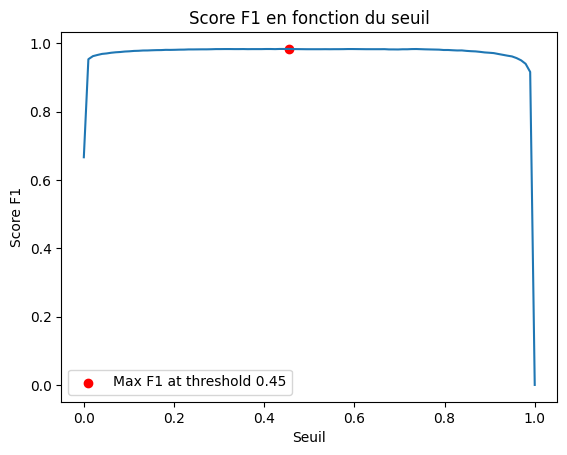

In [116]:
probas_pred = clf.predict_proba(X_test)[:, 1]

# Initialiser les listes pour stocker les résultats
threshold_array = np.linspace(0, 1, 100)
f1_list = []

# Calculer le F1 pour différents seuils
for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (probas_pred > threshold).astype(int)
    # Calcul du f1 pour un seuil donné
    f1_threshold = f1_score(
        y_true=y_test, y_pred=label_pred_threshold
    )

    f1_list.append(f1_threshold)

# Trouver l'indice du maximum de la liste des scores F1
best_threshold_index = np.argmax(f1_list)

# Récupérer le seuil correspondant
best_threshold = threshold_array[best_threshold_index]

# Afficher le graphique
plt.plot(threshold_array, f1_list)
plt.xlabel('Seuil')
plt.ylabel('Score F1')
plt.title('Score F1 en fonction du seuil')
plt.scatter(best_threshold, f1_list[best_threshold_index], color='red', label=f'Max F1 at threshold {best_threshold:.2f}')
plt.legend()
plt.show()

# Utiliser le seuil optimal pour les prédictions
optimal_predictions = (probas_pred > best_threshold).astype(int)

In [117]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_with_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1] > best_threshold).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_with_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché avec le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché avec le seuil optimal: 0.1516236572416348


In [118]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_hide_test, predictions_with_optimal_threshold)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[ 1216 41186]
 [   40  3684]]


In [119]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_without_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1]).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_without_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché sans le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché sans le seuil optimal: 0.0


## Class weight

In [120]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

In [121]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
class_weights = get_class_weights(y_train)
print(class_weights)

{0: 1.0, 1: 11.39}


In [122]:


# Initialiser le modèle avec les poids de classe
clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    class_weight='balanced',
    is_unbalance= True
)

# Entraîner le modèle
clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='f1')

# Prédire sur l'ensemble de test
predictions = clf.predict(X_test)



[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/work/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.691904
[2]	training's binary_logloss: 0.690916
[3]	training's binary_logloss: 0.690193
[4]	training's binary_logloss: 0.689736
[5]	training's binary_logloss: 0.689477
[6]	training's binary_logloss: 0.689437
[7]	training's binary_logloss: 0.689601
[8]	training's binary_logloss: 0.68994
[9]	training's binary_logloss: 0.690466
[10]	training's binary_logloss: 0.691171
[11]	training's binary_logloss: 0.692023
[12]	training's binary_logloss: 0.693
[13]	training's binary_logloss: 0.694323
[14]	training's binary_logloss: 0.695777
[15]	training's binary_logloss: 0.697182
[16]	training's binary_logloss: 0.698655
[17]	training's binary_logloss: 0.700239
[18]	training's binary_logloss: 0.701958
[19]	training's binary_logloss: 0.703756
[20]	training's binary_logloss: 0.705647
[21]	training's binary_logloss: 0.707762
[22]	training's binary_logloss: 0.709841
[23]	training's binary_logloss: 0.71201
[24]	training's binary_logloss: 0.714233
[25]	training's binary_logloss

[204]	training's binary_logloss: 1.01983
[205]	training's binary_logloss: 1.01987
[206]	training's binary_logloss: 1.01992
[207]	training's binary_logloss: 1.01993
[208]	training's binary_logloss: 1.01991
[209]	training's binary_logloss: 1.0199
[210]	training's binary_logloss: 1.01997
[211]	training's binary_logloss: 1.01996
[212]	training's binary_logloss: 1.01996
[213]	training's binary_logloss: 1.01992
[214]	training's binary_logloss: 1.01992
[215]	training's binary_logloss: 1.01985
[216]	training's binary_logloss: 1.01975
[217]	training's binary_logloss: 1.01964
[218]	training's binary_logloss: 1.01959
[219]	training's binary_logloss: 1.01947
[220]	training's binary_logloss: 1.01935
[221]	training's binary_logloss: 1.01928
[222]	training's binary_logloss: 1.01926
[223]	training's binary_logloss: 1.01919
[224]	training's binary_logloss: 1.01909
[225]	training's binary_logloss: 1.01883
[226]	training's binary_logloss: 1.01866
[227]	training's binary_logloss: 1.01857
[228]	training's 

[404]	training's binary_logloss: 0.964899
[405]	training's binary_logloss: 0.964593
[406]	training's binary_logloss: 0.964292
[407]	training's binary_logloss: 0.963928
[408]	training's binary_logloss: 0.963599
[409]	training's binary_logloss: 0.9633
[410]	training's binary_logloss: 0.962988
[411]	training's binary_logloss: 0.962715
[412]	training's binary_logloss: 0.962375
[413]	training's binary_logloss: 0.962096
[414]	training's binary_logloss: 0.961714
[415]	training's binary_logloss: 0.961235
[416]	training's binary_logloss: 0.960976
[417]	training's binary_logloss: 0.960632
[418]	training's binary_logloss: 0.960316
[419]	training's binary_logloss: 0.959993
[420]	training's binary_logloss: 0.959702
[421]	training's binary_logloss: 0.95927
[422]	training's binary_logloss: 0.958973
[423]	training's binary_logloss: 0.958674
[424]	training's binary_logloss: 0.958264
[425]	training's binary_logloss: 0.957974
[426]	training's binary_logloss: 0.957657
[427]	training's binary_logloss: 0.95

[600]	training's binary_logloss: 0.909501
[601]	training's binary_logloss: 0.909236
[602]	training's binary_logloss: 0.908893
[603]	training's binary_logloss: 0.908673
[604]	training's binary_logloss: 0.908457
[605]	training's binary_logloss: 0.908213
[606]	training's binary_logloss: 0.907955
[607]	training's binary_logloss: 0.907751
[608]	training's binary_logloss: 0.907554
[609]	training's binary_logloss: 0.907295
[610]	training's binary_logloss: 0.90708
[611]	training's binary_logloss: 0.906873
[612]	training's binary_logloss: 0.906664
[613]	training's binary_logloss: 0.906418
[614]	training's binary_logloss: 0.906179
[615]	training's binary_logloss: 0.905946
[616]	training's binary_logloss: 0.905724
[617]	training's binary_logloss: 0.905545
[618]	training's binary_logloss: 0.90532
[619]	training's binary_logloss: 0.905108
[620]	training's binary_logloss: 0.904889
[621]	training's binary_logloss: 0.904662
[622]	training's binary_logloss: 0.904395
[623]	training's binary_logloss: 0.9

[796]	training's binary_logloss: 0.867858
[797]	training's binary_logloss: 0.867668
[798]	training's binary_logloss: 0.867474
[799]	training's binary_logloss: 0.867232
[800]	training's binary_logloss: 0.867008
[801]	training's binary_logloss: 0.866761
[802]	training's binary_logloss: 0.866598
[803]	training's binary_logloss: 0.866458
[804]	training's binary_logloss: 0.86627
[805]	training's binary_logloss: 0.866091
[806]	training's binary_logloss: 0.86594
[807]	training's binary_logloss: 0.865765
[808]	training's binary_logloss: 0.865581
[809]	training's binary_logloss: 0.865414
[810]	training's binary_logloss: 0.865227
[811]	training's binary_logloss: 0.865057
[812]	training's binary_logloss: 0.864841
[813]	training's binary_logloss: 0.864637
[814]	training's binary_logloss: 0.86445
[815]	training's binary_logloss: 0.864238
[816]	training's binary_logloss: 0.864053
[817]	training's binary_logloss: 0.863859
[818]	training's binary_logloss: 0.863674
[819]	training's binary_logloss: 0.86

[996]	training's binary_logloss: 0.832157
[997]	training's binary_logloss: 0.832017
[998]	training's binary_logloss: 0.831811
[999]	training's binary_logloss: 0.831676
[1000]	training's binary_logloss: 0.831533
[1001]	training's binary_logloss: 0.831359
[1002]	training's binary_logloss: 0.831206
[1003]	training's binary_logloss: 0.831046
[1004]	training's binary_logloss: 0.830866
[1005]	training's binary_logloss: 0.830709
[1006]	training's binary_logloss: 0.830548
[1007]	training's binary_logloss: 0.830366
[1008]	training's binary_logloss: 0.830205
[1009]	training's binary_logloss: 0.83002
[1010]	training's binary_logloss: 0.829875
[1011]	training's binary_logloss: 0.829667
[1012]	training's binary_logloss: 0.829473
[1013]	training's binary_logloss: 0.829316
[1014]	training's binary_logloss: 0.829148
[1015]	training's binary_logloss: 0.829007
[1016]	training's binary_logloss: 0.828819
[1017]	training's binary_logloss: 0.828639
[1018]	training's binary_logloss: 0.828447
[1019]	training'

[1189]	training's binary_logloss: 0.800822
[1190]	training's binary_logloss: 0.800717
[1191]	training's binary_logloss: 0.800588
[1192]	training's binary_logloss: 0.800416
[1193]	training's binary_logloss: 0.80029
[1194]	training's binary_logloss: 0.800132
[1195]	training's binary_logloss: 0.799963
[1196]	training's binary_logloss: 0.799782
[1197]	training's binary_logloss: 0.799541
[1198]	training's binary_logloss: 0.799437
[1199]	training's binary_logloss: 0.79932
[1200]	training's binary_logloss: 0.799221
[1201]	training's binary_logloss: 0.799052
[1202]	training's binary_logloss: 0.798904
[1203]	training's binary_logloss: 0.798785
[1204]	training's binary_logloss: 0.798616
[1205]	training's binary_logloss: 0.798454
[1206]	training's binary_logloss: 0.798297
[1207]	training's binary_logloss: 0.798145
[1208]	training's binary_logloss: 0.79802
[1209]	training's binary_logloss: 0.797857
[1210]	training's binary_logloss: 0.79773
[1211]	training's binary_logloss: 0.797573
[1212]	training

[1382]	training's binary_logloss: 0.773333
[1383]	training's binary_logloss: 0.773164
[1384]	training's binary_logloss: 0.773037
[1385]	training's binary_logloss: 0.77291
[1386]	training's binary_logloss: 0.772794
[1387]	training's binary_logloss: 0.772659
[1388]	training's binary_logloss: 0.772489
[1389]	training's binary_logloss: 0.772372
[1390]	training's binary_logloss: 0.772236
[1391]	training's binary_logloss: 0.772111
[1392]	training's binary_logloss: 0.771958
[1393]	training's binary_logloss: 0.771817
[1394]	training's binary_logloss: 0.771695
[1395]	training's binary_logloss: 0.771547
[1396]	training's binary_logloss: 0.771413
[1397]	training's binary_logloss: 0.771265
[1398]	training's binary_logloss: 0.771139
[1399]	training's binary_logloss: 0.770991
[1400]	training's binary_logloss: 0.770842
[1401]	training's binary_logloss: 0.770694
[1402]	training's binary_logloss: 0.770545
[1403]	training's binary_logloss: 0.770449
[1404]	training's binary_logloss: 0.770327
[1405]	train

[1577]	training's binary_logloss: 0.747871
[1578]	training's binary_logloss: 0.747778
[1579]	training's binary_logloss: 0.747665
[1580]	training's binary_logloss: 0.747554
[1581]	training's binary_logloss: 0.747447
[1582]	training's binary_logloss: 0.747325
[1583]	training's binary_logloss: 0.747228
[1584]	training's binary_logloss: 0.747109
[1585]	training's binary_logloss: 0.746962
[1586]	training's binary_logloss: 0.746847
[1587]	training's binary_logloss: 0.746688
[1588]	training's binary_logloss: 0.746571
[1589]	training's binary_logloss: 0.746467
[1590]	training's binary_logloss: 0.746326
[1591]	training's binary_logloss: 0.746145
[1592]	training's binary_logloss: 0.746008
[1593]	training's binary_logloss: 0.74589
[1594]	training's binary_logloss: 0.745802
[1595]	training's binary_logloss: 0.745658
[1596]	training's binary_logloss: 0.745482
[1597]	training's binary_logloss: 0.745391
[1598]	training's binary_logloss: 0.745246
[1599]	training's binary_logloss: 0.74514
[1600]	traini

[1771]	training's binary_logloss: 0.72428
[1772]	training's binary_logloss: 0.724153
[1773]	training's binary_logloss: 0.724041
[1774]	training's binary_logloss: 0.723915
[1775]	training's binary_logloss: 0.723814
[1776]	training's binary_logloss: 0.723684
[1777]	training's binary_logloss: 0.723573
[1778]	training's binary_logloss: 0.723442
[1779]	training's binary_logloss: 0.723333
[1780]	training's binary_logloss: 0.723248
[1781]	training's binary_logloss: 0.723156
[1782]	training's binary_logloss: 0.723055
[1783]	training's binary_logloss: 0.722937
[1784]	training's binary_logloss: 0.722818
[1785]	training's binary_logloss: 0.722706
[1786]	training's binary_logloss: 0.722602
[1787]	training's binary_logloss: 0.722466
[1788]	training's binary_logloss: 0.722351
[1789]	training's binary_logloss: 0.722196
[1790]	training's binary_logloss: 0.722108
[1791]	training's binary_logloss: 0.722006
[1792]	training's binary_logloss: 0.721887
[1793]	training's binary_logloss: 0.72175
[1794]	traini

[1969]	training's binary_logloss: 0.702417
[1970]	training's binary_logloss: 0.702333
[1971]	training's binary_logloss: 0.702204
[1972]	training's binary_logloss: 0.702119
[1973]	training's binary_logloss: 0.702005
[1974]	training's binary_logloss: 0.701914
[1975]	training's binary_logloss: 0.701803
[1976]	training's binary_logloss: 0.701719
[1977]	training's binary_logloss: 0.701564
[1978]	training's binary_logloss: 0.701488
[1979]	training's binary_logloss: 0.701396
[1980]	training's binary_logloss: 0.701278
[1981]	training's binary_logloss: 0.70118
[1982]	training's binary_logloss: 0.701049
[1983]	training's binary_logloss: 0.700936
[1984]	training's binary_logloss: 0.700812
[1985]	training's binary_logloss: 0.700731
[1986]	training's binary_logloss: 0.700624
[1987]	training's binary_logloss: 0.700504
[1988]	training's binary_logloss: 0.70041
[1989]	training's binary_logloss: 0.70033
[1990]	training's binary_logloss: 0.700251
[1991]	training's binary_logloss: 0.700131
[1992]	trainin

[2165]	training's binary_logloss: 0.682117
[2166]	training's binary_logloss: 0.682026
[2167]	training's binary_logloss: 0.681939
[2168]	training's binary_logloss: 0.681848
[2169]	training's binary_logloss: 0.681755
[2170]	training's binary_logloss: 0.681671
[2171]	training's binary_logloss: 0.681577
[2172]	training's binary_logloss: 0.681458
[2173]	training's binary_logloss: 0.681355
[2174]	training's binary_logloss: 0.68126
[2175]	training's binary_logloss: 0.681175
[2176]	training's binary_logloss: 0.681069
[2177]	training's binary_logloss: 0.680985
[2178]	training's binary_logloss: 0.680868
[2179]	training's binary_logloss: 0.680773
[2180]	training's binary_logloss: 0.680695
[2181]	training's binary_logloss: 0.680583
[2182]	training's binary_logloss: 0.680482
[2183]	training's binary_logloss: 0.680418
[2184]	training's binary_logloss: 0.680314
[2185]	training's binary_logloss: 0.680232
[2186]	training's binary_logloss: 0.680062
[2187]	training's binary_logloss: 0.679967
[2188]	train

[2361]	training's binary_logloss: 0.662703
[2362]	training's binary_logloss: 0.6626
[2363]	training's binary_logloss: 0.662496
[2364]	training's binary_logloss: 0.66241
[2365]	training's binary_logloss: 0.662307
[2366]	training's binary_logloss: 0.662142
[2367]	training's binary_logloss: 0.66205
[2368]	training's binary_logloss: 0.66197
[2369]	training's binary_logloss: 0.661865
[2370]	training's binary_logloss: 0.661735
[2371]	training's binary_logloss: 0.661643
[2372]	training's binary_logloss: 0.661569
[2373]	training's binary_logloss: 0.661475
[2374]	training's binary_logloss: 0.661367
[2375]	training's binary_logloss: 0.661287
[2376]	training's binary_logloss: 0.66122
[2377]	training's binary_logloss: 0.661138
[2378]	training's binary_logloss: 0.661033
[2379]	training's binary_logloss: 0.660936
[2380]	training's binary_logloss: 0.660852
[2381]	training's binary_logloss: 0.660777
[2382]	training's binary_logloss: 0.660652
[2383]	training's binary_logloss: 0.660547
[2384]	training's

[2556]	training's binary_logloss: 0.644086
[2557]	training's binary_logloss: 0.644015
[2558]	training's binary_logloss: 0.643892
[2559]	training's binary_logloss: 0.643822
[2560]	training's binary_logloss: 0.643727
[2561]	training's binary_logloss: 0.643641
[2562]	training's binary_logloss: 0.643572
[2563]	training's binary_logloss: 0.643451
[2564]	training's binary_logloss: 0.643344
[2565]	training's binary_logloss: 0.64323
[2566]	training's binary_logloss: 0.643148
[2567]	training's binary_logloss: 0.643078
[2568]	training's binary_logloss: 0.642978
[2569]	training's binary_logloss: 0.642894
[2570]	training's binary_logloss: 0.642809
[2571]	training's binary_logloss: 0.642722
[2572]	training's binary_logloss: 0.64261
[2573]	training's binary_logloss: 0.642527
[2574]	training's binary_logloss: 0.642447
[2575]	training's binary_logloss: 0.642387
[2576]	training's binary_logloss: 0.642296
[2577]	training's binary_logloss: 0.642191
[2578]	training's binary_logloss: 0.642098
[2579]	traini

[2754]	training's binary_logloss: 0.62617
[2755]	training's binary_logloss: 0.626079
[2756]	training's binary_logloss: 0.626024
[2757]	training's binary_logloss: 0.625963
[2758]	training's binary_logloss: 0.625869
[2759]	training's binary_logloss: 0.625775
[2760]	training's binary_logloss: 0.625677
[2761]	training's binary_logloss: 0.625592
[2762]	training's binary_logloss: 0.625504
[2763]	training's binary_logloss: 0.625421
[2764]	training's binary_logloss: 0.625355
[2765]	training's binary_logloss: 0.625237
[2766]	training's binary_logloss: 0.625166
[2767]	training's binary_logloss: 0.625089
[2768]	training's binary_logloss: 0.624972
[2769]	training's binary_logloss: 0.624874
[2770]	training's binary_logloss: 0.624781
[2771]	training's binary_logloss: 0.624711
[2772]	training's binary_logloss: 0.624648
[2773]	training's binary_logloss: 0.62456
[2774]	training's binary_logloss: 0.624483
[2775]	training's binary_logloss: 0.624388
[2776]	training's binary_logloss: 0.62427
[2777]	trainin

[2948]	training's binary_logloss: 0.609718
[2949]	training's binary_logloss: 0.609616
[2950]	training's binary_logloss: 0.609493
[2951]	training's binary_logloss: 0.609393
[2952]	training's binary_logloss: 0.609334
[2953]	training's binary_logloss: 0.609251
[2954]	training's binary_logloss: 0.60914
[2955]	training's binary_logloss: 0.609078
[2956]	training's binary_logloss: 0.608992
[2957]	training's binary_logloss: 0.608914
[2958]	training's binary_logloss: 0.608821
[2959]	training's binary_logloss: 0.608755
[2960]	training's binary_logloss: 0.608694
[2961]	training's binary_logloss: 0.608605
[2962]	training's binary_logloss: 0.608535
[2963]	training's binary_logloss: 0.608467
[2964]	training's binary_logloss: 0.6084
[2965]	training's binary_logloss: 0.608315
[2966]	training's binary_logloss: 0.608248
[2967]	training's binary_logloss: 0.608154
[2968]	training's binary_logloss: 0.608046
[2969]	training's binary_logloss: 0.607957
[2970]	training's binary_logloss: 0.607874
[2971]	trainin

[3145]	training's binary_logloss: 0.593596
[3146]	training's binary_logloss: 0.593533
[3147]	training's binary_logloss: 0.593437
[3148]	training's binary_logloss: 0.59334
[3149]	training's binary_logloss: 0.593258
[3150]	training's binary_logloss: 0.593185
[3151]	training's binary_logloss: 0.593114
[3152]	training's binary_logloss: 0.593066
[3153]	training's binary_logloss: 0.592999
[3154]	training's binary_logloss: 0.59292
[3155]	training's binary_logloss: 0.592839
[3156]	training's binary_logloss: 0.59278
[3157]	training's binary_logloss: 0.592706
[3158]	training's binary_logloss: 0.592618
[3159]	training's binary_logloss: 0.592567
[3160]	training's binary_logloss: 0.592497
[3161]	training's binary_logloss: 0.592412
[3162]	training's binary_logloss: 0.592346
[3163]	training's binary_logloss: 0.592269
[3164]	training's binary_logloss: 0.592202
[3165]	training's binary_logloss: 0.592144
[3166]	training's binary_logloss: 0.592069
[3167]	training's binary_logloss: 0.591977
[3168]	trainin

[3338]	training's binary_logloss: 0.578972
[3339]	training's binary_logloss: 0.578922
[3340]	training's binary_logloss: 0.578855
[3341]	training's binary_logloss: 0.578778
[3342]	training's binary_logloss: 0.578671
[3343]	training's binary_logloss: 0.578593
[3344]	training's binary_logloss: 0.578501
[3345]	training's binary_logloss: 0.578419
[3346]	training's binary_logloss: 0.578333
[3347]	training's binary_logloss: 0.578228
[3348]	training's binary_logloss: 0.578166
[3349]	training's binary_logloss: 0.578084
[3350]	training's binary_logloss: 0.578021
[3351]	training's binary_logloss: 0.577941
[3352]	training's binary_logloss: 0.577868
[3353]	training's binary_logloss: 0.577816
[3354]	training's binary_logloss: 0.577749
[3355]	training's binary_logloss: 0.577673
[3356]	training's binary_logloss: 0.57761
[3357]	training's binary_logloss: 0.57753
[3358]	training's binary_logloss: 0.577456
[3359]	training's binary_logloss: 0.577376
[3360]	training's binary_logloss: 0.577294
[3361]	traini

[3536]	training's binary_logloss: 0.564667
[3537]	training's binary_logloss: 0.564595
[3538]	training's binary_logloss: 0.564537
[3539]	training's binary_logloss: 0.564434
[3540]	training's binary_logloss: 0.564385
[3541]	training's binary_logloss: 0.564337
[3542]	training's binary_logloss: 0.564278
[3543]	training's binary_logloss: 0.56422
[3544]	training's binary_logloss: 0.56416
[3545]	training's binary_logloss: 0.564068
[3546]	training's binary_logloss: 0.563996
[3547]	training's binary_logloss: 0.563927
[3548]	training's binary_logloss: 0.563848
[3549]	training's binary_logloss: 0.563798
[3550]	training's binary_logloss: 0.563726
[3551]	training's binary_logloss: 0.563641
[3552]	training's binary_logloss: 0.563573
[3553]	training's binary_logloss: 0.56348
[3554]	training's binary_logloss: 0.563411
[3555]	training's binary_logloss: 0.563307
[3556]	training's binary_logloss: 0.563231
[3557]	training's binary_logloss: 0.563182
[3558]	training's binary_logloss: 0.563113
[3559]	trainin

[3732]	training's binary_logloss: 0.550865
[3733]	training's binary_logloss: 0.550821
[3734]	training's binary_logloss: 0.55077
[3735]	training's binary_logloss: 0.550714
[3736]	training's binary_logloss: 0.550629
[3737]	training's binary_logloss: 0.550558
[3738]	training's binary_logloss: 0.550468
[3739]	training's binary_logloss: 0.550402
[3740]	training's binary_logloss: 0.550339
[3741]	training's binary_logloss: 0.550256
[3742]	training's binary_logloss: 0.550179
[3743]	training's binary_logloss: 0.550111
[3744]	training's binary_logloss: 0.550039
[3745]	training's binary_logloss: 0.549999
[3746]	training's binary_logloss: 0.54993
[3747]	training's binary_logloss: 0.549874
[3748]	training's binary_logloss: 0.549798
[3749]	training's binary_logloss: 0.549752
[3750]	training's binary_logloss: 0.549672
[3751]	training's binary_logloss: 0.549577
[3752]	training's binary_logloss: 0.549515
[3753]	training's binary_logloss: 0.549455
[3754]	training's binary_logloss: 0.549397
[3755]	traini

[3928]	training's binary_logloss: 0.537775
[3929]	training's binary_logloss: 0.537695
[3930]	training's binary_logloss: 0.537635
[3931]	training's binary_logloss: 0.537586
[3932]	training's binary_logloss: 0.537525
[3933]	training's binary_logloss: 0.537447
[3934]	training's binary_logloss: 0.537406
[3935]	training's binary_logloss: 0.537339
[3936]	training's binary_logloss: 0.537274
[3937]	training's binary_logloss: 0.537193
[3938]	training's binary_logloss: 0.537132
[3939]	training's binary_logloss: 0.537081
[3940]	training's binary_logloss: 0.53701
[3941]	training's binary_logloss: 0.53694
[3942]	training's binary_logloss: 0.536881
[3943]	training's binary_logloss: 0.536831
[3944]	training's binary_logloss: 0.536777
[3945]	training's binary_logloss: 0.536734
[3946]	training's binary_logloss: 0.536691
[3947]	training's binary_logloss: 0.536626
[3948]	training's binary_logloss: 0.536543
[3949]	training's binary_logloss: 0.536475
[3950]	training's binary_logloss: 0.536415
[3951]	traini

[4120]	training's binary_logloss: 0.525341
[4121]	training's binary_logloss: 0.525269
[4122]	training's binary_logloss: 0.525211
[4123]	training's binary_logloss: 0.525151
[4124]	training's binary_logloss: 0.525053
[4125]	training's binary_logloss: 0.524989
[4126]	training's binary_logloss: 0.524937
[4127]	training's binary_logloss: 0.524875
[4128]	training's binary_logloss: 0.524835
[4129]	training's binary_logloss: 0.524771
[4130]	training's binary_logloss: 0.524674
[4131]	training's binary_logloss: 0.524618
[4132]	training's binary_logloss: 0.524567
[4133]	training's binary_logloss: 0.524494
[4134]	training's binary_logloss: 0.524423
[4135]	training's binary_logloss: 0.52435
[4136]	training's binary_logloss: 0.524286
[4137]	training's binary_logloss: 0.524227
[4138]	training's binary_logloss: 0.524146
[4139]	training's binary_logloss: 0.524034
[4140]	training's binary_logloss: 0.523976
[4141]	training's binary_logloss: 0.523908
[4142]	training's binary_logloss: 0.523846
[4143]	train

[4311]	training's binary_logloss: 0.513296
[4312]	training's binary_logloss: 0.513245
[4313]	training's binary_logloss: 0.513171
[4314]	training's binary_logloss: 0.513127
[4315]	training's binary_logloss: 0.513061
[4316]	training's binary_logloss: 0.513016
[4317]	training's binary_logloss: 0.512971
[4318]	training's binary_logloss: 0.512886
[4319]	training's binary_logloss: 0.512827
[4320]	training's binary_logloss: 0.512765
[4321]	training's binary_logloss: 0.512714
[4322]	training's binary_logloss: 0.512648
[4323]	training's binary_logloss: 0.512589
[4324]	training's binary_logloss: 0.512532
[4325]	training's binary_logloss: 0.512458
[4326]	training's binary_logloss: 0.512411
[4327]	training's binary_logloss: 0.512361
[4328]	training's binary_logloss: 0.51229
[4329]	training's binary_logloss: 0.512244
[4330]	training's binary_logloss: 0.512192
[4331]	training's binary_logloss: 0.512128
[4332]	training's binary_logloss: 0.512072
[4333]	training's binary_logloss: 0.512027
[4334]	train

[4502]	training's binary_logloss: 0.501848
[4503]	training's binary_logloss: 0.50176
[4504]	training's binary_logloss: 0.50171
[4505]	training's binary_logloss: 0.501665
[4506]	training's binary_logloss: 0.501576
[4507]	training's binary_logloss: 0.501506
[4508]	training's binary_logloss: 0.501453
[4509]	training's binary_logloss: 0.501387
[4510]	training's binary_logloss: 0.501309
[4511]	training's binary_logloss: 0.501259
[4512]	training's binary_logloss: 0.501217
[4513]	training's binary_logloss: 0.501162
[4514]	training's binary_logloss: 0.501115
[4515]	training's binary_logloss: 0.501057
[4516]	training's binary_logloss: 0.500967
[4517]	training's binary_logloss: 0.500922
[4518]	training's binary_logloss: 0.50084
[4519]	training's binary_logloss: 0.500778
[4520]	training's binary_logloss: 0.50073
[4521]	training's binary_logloss: 0.500673
[4522]	training's binary_logloss: 0.500619
[4523]	training's binary_logloss: 0.500578
[4524]	training's binary_logloss: 0.500523
[4525]	training

[4695]	training's binary_logloss: 0.490914
[4696]	training's binary_logloss: 0.490873
[4697]	training's binary_logloss: 0.490816
[4698]	training's binary_logloss: 0.49076
[4699]	training's binary_logloss: 0.490711
[4700]	training's binary_logloss: 0.49063
[4701]	training's binary_logloss: 0.490588
[4702]	training's binary_logloss: 0.490537
[4703]	training's binary_logloss: 0.490498
[4704]	training's binary_logloss: 0.490453
[4705]	training's binary_logloss: 0.490394
[4706]	training's binary_logloss: 0.490334
[4707]	training's binary_logloss: 0.490299
[4708]	training's binary_logloss: 0.490257
[4709]	training's binary_logloss: 0.490185
[4710]	training's binary_logloss: 0.490116
[4711]	training's binary_logloss: 0.490033
[4712]	training's binary_logloss: 0.489966
[4713]	training's binary_logloss: 0.489909
[4714]	training's binary_logloss: 0.489823
[4715]	training's binary_logloss: 0.489782
[4716]	training's binary_logloss: 0.489727
[4717]	training's binary_logloss: 0.489657
[4718]	traini

[4892]	training's binary_logloss: 0.480073
[4893]	training's binary_logloss: 0.480028
[4894]	training's binary_logloss: 0.479982
[4895]	training's binary_logloss: 0.479925
[4896]	training's binary_logloss: 0.479875
[4897]	training's binary_logloss: 0.479813
[4898]	training's binary_logloss: 0.479764
[4899]	training's binary_logloss: 0.479727
[4900]	training's binary_logloss: 0.479685
[4901]	training's binary_logloss: 0.479633
[4902]	training's binary_logloss: 0.479577
[4903]	training's binary_logloss: 0.479535
[4904]	training's binary_logloss: 0.479473
[4905]	training's binary_logloss: 0.479408
[4906]	training's binary_logloss: 0.479359
[4907]	training's binary_logloss: 0.479312
[4908]	training's binary_logloss: 0.479261
[4909]	training's binary_logloss: 0.479209
[4910]	training's binary_logloss: 0.479189
[4911]	training's binary_logloss: 0.479125
[4912]	training's binary_logloss: 0.479066
[4913]	training's binary_logloss: 0.478995
[4914]	training's binary_logloss: 0.478916
[4915]	trai

[5085]	training's binary_logloss: 0.46989
[5086]	training's binary_logloss: 0.469858
[5087]	training's binary_logloss: 0.469808
[5088]	training's binary_logloss: 0.469751
[5089]	training's binary_logloss: 0.469697
[5090]	training's binary_logloss: 0.469631
[5091]	training's binary_logloss: 0.469578
[5092]	training's binary_logloss: 0.469543
[5093]	training's binary_logloss: 0.469477
[5094]	training's binary_logloss: 0.469413
[5095]	training's binary_logloss: 0.469342
[5096]	training's binary_logloss: 0.469292
[5097]	training's binary_logloss: 0.469247
[5098]	training's binary_logloss: 0.469205
[5099]	training's binary_logloss: 0.46916
[5100]	training's binary_logloss: 0.469101
[5101]	training's binary_logloss: 0.469028
[5102]	training's binary_logloss: 0.468973
[5103]	training's binary_logloss: 0.468922
[5104]	training's binary_logloss: 0.468852
[5105]	training's binary_logloss: 0.468813
[5106]	training's binary_logloss: 0.468758
[5107]	training's binary_logloss: 0.468714
[5108]	traini

[5280]	training's binary_logloss: 0.45966
[5281]	training's binary_logloss: 0.459625
[5282]	training's binary_logloss: 0.459586
[5283]	training's binary_logloss: 0.459509
[5284]	training's binary_logloss: 0.459469
[5285]	training's binary_logloss: 0.459435
[5286]	training's binary_logloss: 0.459375
[5287]	training's binary_logloss: 0.459334
[5288]	training's binary_logloss: 0.459261
[5289]	training's binary_logloss: 0.459212
[5290]	training's binary_logloss: 0.459171
[5291]	training's binary_logloss: 0.459122
[5292]	training's binary_logloss: 0.459053
[5293]	training's binary_logloss: 0.458996
[5294]	training's binary_logloss: 0.458951
[5295]	training's binary_logloss: 0.458909
[5296]	training's binary_logloss: 0.458852
[5297]	training's binary_logloss: 0.458808
[5298]	training's binary_logloss: 0.458773
[5299]	training's binary_logloss: 0.458728
[5300]	training's binary_logloss: 0.458678
[5301]	training's binary_logloss: 0.458623
[5302]	training's binary_logloss: 0.458557
[5303]	train

[5471]	training's binary_logloss: 0.450193
[5472]	training's binary_logloss: 0.450132
[5473]	training's binary_logloss: 0.450082
[5474]	training's binary_logloss: 0.450034
[5475]	training's binary_logloss: 0.450001
[5476]	training's binary_logloss: 0.449957
[5477]	training's binary_logloss: 0.449919
[5478]	training's binary_logloss: 0.449871
[5479]	training's binary_logloss: 0.449823
[5480]	training's binary_logloss: 0.449778
[5481]	training's binary_logloss: 0.449734
[5482]	training's binary_logloss: 0.449681
[5483]	training's binary_logloss: 0.449615
[5484]	training's binary_logloss: 0.449573
[5485]	training's binary_logloss: 0.449532
[5486]	training's binary_logloss: 0.449472
[5487]	training's binary_logloss: 0.449407
[5488]	training's binary_logloss: 0.449361
[5489]	training's binary_logloss: 0.449319
[5490]	training's binary_logloss: 0.449279
[5491]	training's binary_logloss: 0.449227
[5492]	training's binary_logloss: 0.449174
[5493]	training's binary_logloss: 0.449135
[5494]	trai

[5664]	training's binary_logloss: 0.440712
[5665]	training's binary_logloss: 0.440651
[5666]	training's binary_logloss: 0.440622
[5667]	training's binary_logloss: 0.440564
[5668]	training's binary_logloss: 0.440518
[5669]	training's binary_logloss: 0.44048
[5670]	training's binary_logloss: 0.440415
[5671]	training's binary_logloss: 0.440368
[5672]	training's binary_logloss: 0.440331
[5673]	training's binary_logloss: 0.440293
[5674]	training's binary_logloss: 0.44025
[5675]	training's binary_logloss: 0.440202
[5676]	training's binary_logloss: 0.440147
[5677]	training's binary_logloss: 0.440085
[5678]	training's binary_logloss: 0.440033
[5679]	training's binary_logloss: 0.439992
[5680]	training's binary_logloss: 0.439942
[5681]	training's binary_logloss: 0.439891
[5682]	training's binary_logloss: 0.439851
[5683]	training's binary_logloss: 0.439788
[5684]	training's binary_logloss: 0.439743
[5685]	training's binary_logloss: 0.439698
[5686]	training's binary_logloss: 0.439657
[5687]	traini

[5858]	training's binary_logloss: 0.431395
[5859]	training's binary_logloss: 0.431348
[5860]	training's binary_logloss: 0.431303
[5861]	training's binary_logloss: 0.431268
[5862]	training's binary_logloss: 0.431205
[5863]	training's binary_logloss: 0.431176
[5864]	training's binary_logloss: 0.431132
[5865]	training's binary_logloss: 0.43108
[5866]	training's binary_logloss: 0.43104
[5867]	training's binary_logloss: 0.430978
[5868]	training's binary_logloss: 0.430931
[5869]	training's binary_logloss: 0.430869
[5870]	training's binary_logloss: 0.430822
[5871]	training's binary_logloss: 0.430789
[5872]	training's binary_logloss: 0.43074
[5873]	training's binary_logloss: 0.430707
[5874]	training's binary_logloss: 0.430671
[5875]	training's binary_logloss: 0.430616
[5876]	training's binary_logloss: 0.43056
[5877]	training's binary_logloss: 0.430511
[5878]	training's binary_logloss: 0.430423
[5879]	training's binary_logloss: 0.430385
[5880]	training's binary_logloss: 0.430345
[5881]	training

[6055]	training's binary_logloss: 0.422237
[6056]	training's binary_logloss: 0.422182
[6057]	training's binary_logloss: 0.422152
[6058]	training's binary_logloss: 0.422103
[6059]	training's binary_logloss: 0.422055
[6060]	training's binary_logloss: 0.422018
[6061]	training's binary_logloss: 0.421979
[6062]	training's binary_logloss: 0.421941
[6063]	training's binary_logloss: 0.421895
[6064]	training's binary_logloss: 0.421856
[6065]	training's binary_logloss: 0.421822
[6066]	training's binary_logloss: 0.421744
[6067]	training's binary_logloss: 0.421693
[6068]	training's binary_logloss: 0.421651
[6069]	training's binary_logloss: 0.421614
[6070]	training's binary_logloss: 0.421578
[6071]	training's binary_logloss: 0.421526
[6072]	training's binary_logloss: 0.42147
[6073]	training's binary_logloss: 0.421439
[6074]	training's binary_logloss: 0.421403
[6075]	training's binary_logloss: 0.421371
[6076]	training's binary_logloss: 0.421324
[6077]	training's binary_logloss: 0.421275
[6078]	train

[6252]	training's binary_logloss: 0.413592
[6253]	training's binary_logloss: 0.413552
[6254]	training's binary_logloss: 0.413496
[6255]	training's binary_logloss: 0.413451
[6256]	training's binary_logloss: 0.413396
[6257]	training's binary_logloss: 0.413362
[6258]	training's binary_logloss: 0.413327
[6259]	training's binary_logloss: 0.413285
[6260]	training's binary_logloss: 0.41324
[6261]	training's binary_logloss: 0.413191
[6262]	training's binary_logloss: 0.413162
[6263]	training's binary_logloss: 0.413119
[6264]	training's binary_logloss: 0.413052
[6265]	training's binary_logloss: 0.413001
[6266]	training's binary_logloss: 0.412964
[6267]	training's binary_logloss: 0.412918
[6268]	training's binary_logloss: 0.412881
[6269]	training's binary_logloss: 0.412828
[6270]	training's binary_logloss: 0.412771
[6271]	training's binary_logloss: 0.412739
[6272]	training's binary_logloss: 0.412682
[6273]	training's binary_logloss: 0.412633
[6274]	training's binary_logloss: 0.412596
[6275]	train

[6449]	training's binary_logloss: 0.405027
[6450]	training's binary_logloss: 0.404997
[6451]	training's binary_logloss: 0.404964
[6452]	training's binary_logloss: 0.404925
[6453]	training's binary_logloss: 0.404884
[6454]	training's binary_logloss: 0.404855
[6455]	training's binary_logloss: 0.404809
[6456]	training's binary_logloss: 0.404764
[6457]	training's binary_logloss: 0.404725
[6458]	training's binary_logloss: 0.404676
[6459]	training's binary_logloss: 0.404625
[6460]	training's binary_logloss: 0.404589
[6461]	training's binary_logloss: 0.404542
[6462]	training's binary_logloss: 0.404487
[6463]	training's binary_logloss: 0.404442
[6464]	training's binary_logloss: 0.404413
[6465]	training's binary_logloss: 0.404371
[6466]	training's binary_logloss: 0.404337
[6467]	training's binary_logloss: 0.404287
[6468]	training's binary_logloss: 0.404254
[6469]	training's binary_logloss: 0.404214
[6470]	training's binary_logloss: 0.404187
[6471]	training's binary_logloss: 0.404138
[6472]	trai

[6648]	training's binary_logloss: 0.396652
[6649]	training's binary_logloss: 0.396587
[6650]	training's binary_logloss: 0.396558
[6651]	training's binary_logloss: 0.396504
[6652]	training's binary_logloss: 0.396464
[6653]	training's binary_logloss: 0.39642
[6654]	training's binary_logloss: 0.396381
[6655]	training's binary_logloss: 0.396319
[6656]	training's binary_logloss: 0.396279
[6657]	training's binary_logloss: 0.396227
[6658]	training's binary_logloss: 0.396189
[6659]	training's binary_logloss: 0.39615
[6660]	training's binary_logloss: 0.396109
[6661]	training's binary_logloss: 0.396067
[6662]	training's binary_logloss: 0.396022
[6663]	training's binary_logloss: 0.395984
[6664]	training's binary_logloss: 0.395937
[6665]	training's binary_logloss: 0.395906
[6666]	training's binary_logloss: 0.395858
[6667]	training's binary_logloss: 0.395825
[6668]	training's binary_logloss: 0.395796
[6669]	training's binary_logloss: 0.395769
[6670]	training's binary_logloss: 0.395735
[6671]	traini

[6847]	training's binary_logloss: 0.388498
[6848]	training's binary_logloss: 0.388459
[6849]	training's binary_logloss: 0.388421
[6850]	training's binary_logloss: 0.388385
[6851]	training's binary_logloss: 0.388342
[6852]	training's binary_logloss: 0.38831
[6853]	training's binary_logloss: 0.388279
[6854]	training's binary_logloss: 0.388244
[6855]	training's binary_logloss: 0.388204
[6856]	training's binary_logloss: 0.38816
[6857]	training's binary_logloss: 0.388106
[6858]	training's binary_logloss: 0.38806
[6859]	training's binary_logloss: 0.388009
[6860]	training's binary_logloss: 0.387965
[6861]	training's binary_logloss: 0.387915
[6862]	training's binary_logloss: 0.38787
[6863]	training's binary_logloss: 0.387831
[6864]	training's binary_logloss: 0.387802
[6865]	training's binary_logloss: 0.38777
[6866]	training's binary_logloss: 0.387735
[6867]	training's binary_logloss: 0.387693
[6868]	training's binary_logloss: 0.387644
[6869]	training's binary_logloss: 0.387608
[6870]	training'

[7043]	training's binary_logloss: 0.380637
[7044]	training's binary_logloss: 0.380609
[7045]	training's binary_logloss: 0.380576
[7046]	training's binary_logloss: 0.380538
[7047]	training's binary_logloss: 0.380487
[7048]	training's binary_logloss: 0.380437
[7049]	training's binary_logloss: 0.380406
[7050]	training's binary_logloss: 0.380365
[7051]	training's binary_logloss: 0.380337
[7052]	training's binary_logloss: 0.380289
[7053]	training's binary_logloss: 0.380244
[7054]	training's binary_logloss: 0.380202
[7055]	training's binary_logloss: 0.380172
[7056]	training's binary_logloss: 0.380127
[7057]	training's binary_logloss: 0.380069
[7058]	training's binary_logloss: 0.380027
[7059]	training's binary_logloss: 0.379973
[7060]	training's binary_logloss: 0.379931
[7061]	training's binary_logloss: 0.379897
[7062]	training's binary_logloss: 0.379826
[7063]	training's binary_logloss: 0.379789
[7064]	training's binary_logloss: 0.37975
[7065]	training's binary_logloss: 0.379687
[7066]	train

[7238]	training's binary_logloss: 0.373049
[7239]	training's binary_logloss: 0.373012
[7240]	training's binary_logloss: 0.372981
[7241]	training's binary_logloss: 0.372931
[7242]	training's binary_logloss: 0.372894
[7243]	training's binary_logloss: 0.372848
[7244]	training's binary_logloss: 0.372801
[7245]	training's binary_logloss: 0.372751
[7246]	training's binary_logloss: 0.372709
[7247]	training's binary_logloss: 0.372668
[7248]	training's binary_logloss: 0.372635
[7249]	training's binary_logloss: 0.372601
[7250]	training's binary_logloss: 0.372577
[7251]	training's binary_logloss: 0.372545
[7252]	training's binary_logloss: 0.372514
[7253]	training's binary_logloss: 0.372483
[7254]	training's binary_logloss: 0.372442
[7255]	training's binary_logloss: 0.372415
[7256]	training's binary_logloss: 0.372371
[7257]	training's binary_logloss: 0.372336
[7258]	training's binary_logloss: 0.372288
[7259]	training's binary_logloss: 0.372247
[7260]	training's binary_logloss: 0.372208
[7261]	trai

[7431]	training's binary_logloss: 0.365768
[7432]	training's binary_logloss: 0.365739
[7433]	training's binary_logloss: 0.365707
[7434]	training's binary_logloss: 0.365674
[7435]	training's binary_logloss: 0.365651
[7436]	training's binary_logloss: 0.365606
[7437]	training's binary_logloss: 0.365561
[7438]	training's binary_logloss: 0.365527
[7439]	training's binary_logloss: 0.365499
[7440]	training's binary_logloss: 0.365455
[7441]	training's binary_logloss: 0.365427
[7442]	training's binary_logloss: 0.365382
[7443]	training's binary_logloss: 0.365341
[7444]	training's binary_logloss: 0.365318
[7445]	training's binary_logloss: 0.365274
[7446]	training's binary_logloss: 0.365215
[7447]	training's binary_logloss: 0.365181
[7448]	training's binary_logloss: 0.365141
[7449]	training's binary_logloss: 0.36511
[7450]	training's binary_logloss: 0.365078
[7451]	training's binary_logloss: 0.365044
[7452]	training's binary_logloss: 0.365005
[7453]	training's binary_logloss: 0.36496
[7454]	traini

[7626]	training's binary_logloss: 0.358617
[7627]	training's binary_logloss: 0.358588
[7628]	training's binary_logloss: 0.358559
[7629]	training's binary_logloss: 0.35853
[7630]	training's binary_logloss: 0.358494
[7631]	training's binary_logloss: 0.358448
[7632]	training's binary_logloss: 0.358393
[7633]	training's binary_logloss: 0.358363
[7634]	training's binary_logloss: 0.358314
[7635]	training's binary_logloss: 0.358263
[7636]	training's binary_logloss: 0.358238
[7637]	training's binary_logloss: 0.358195
[7638]	training's binary_logloss: 0.358171
[7639]	training's binary_logloss: 0.358126
[7640]	training's binary_logloss: 0.358082
[7641]	training's binary_logloss: 0.358034
[7642]	training's binary_logloss: 0.358021
[7643]	training's binary_logloss: 0.357992
[7644]	training's binary_logloss: 0.35794
[7645]	training's binary_logloss: 0.35791
[7646]	training's binary_logloss: 0.357865
[7647]	training's binary_logloss: 0.357833
[7648]	training's binary_logloss: 0.357802
[7649]	trainin

[7820]	training's binary_logloss: 0.35176
[7821]	training's binary_logloss: 0.351722
[7822]	training's binary_logloss: 0.351678
[7823]	training's binary_logloss: 0.35164
[7824]	training's binary_logloss: 0.351587
[7825]	training's binary_logloss: 0.351551
[7826]	training's binary_logloss: 0.351513
[7827]	training's binary_logloss: 0.351484
[7828]	training's binary_logloss: 0.351446
[7829]	training's binary_logloss: 0.351416
[7830]	training's binary_logloss: 0.351386
[7831]	training's binary_logloss: 0.351349
[7832]	training's binary_logloss: 0.35132
[7833]	training's binary_logloss: 0.351279
[7834]	training's binary_logloss: 0.351254
[7835]	training's binary_logloss: 0.351219
[7836]	training's binary_logloss: 0.351184
[7837]	training's binary_logloss: 0.351161
[7838]	training's binary_logloss: 0.351139
[7839]	training's binary_logloss: 0.351117
[7840]	training's binary_logloss: 0.351062
[7841]	training's binary_logloss: 0.351021
[7842]	training's binary_logloss: 0.350991
[7843]	trainin

[8015]	training's binary_logloss: 0.344978
[8016]	training's binary_logloss: 0.344939
[8017]	training's binary_logloss: 0.3449
[8018]	training's binary_logloss: 0.34487
[8019]	training's binary_logloss: 0.344831
[8020]	training's binary_logloss: 0.344803
[8021]	training's binary_logloss: 0.34478
[8022]	training's binary_logloss: 0.344737
[8023]	training's binary_logloss: 0.344711
[8024]	training's binary_logloss: 0.344686
[8025]	training's binary_logloss: 0.344653
[8026]	training's binary_logloss: 0.344631
[8027]	training's binary_logloss: 0.344584
[8028]	training's binary_logloss: 0.34456
[8029]	training's binary_logloss: 0.344527
[8030]	training's binary_logloss: 0.344491
[8031]	training's binary_logloss: 0.344459
[8032]	training's binary_logloss: 0.344416
[8033]	training's binary_logloss: 0.34439
[8034]	training's binary_logloss: 0.344346
[8035]	training's binary_logloss: 0.344308
[8036]	training's binary_logloss: 0.34427
[8037]	training's binary_logloss: 0.344241
[8038]	training's 

[8207]	training's binary_logloss: 0.338433
[8208]	training's binary_logloss: 0.338402
[8209]	training's binary_logloss: 0.338375
[8210]	training's binary_logloss: 0.338334
[8211]	training's binary_logloss: 0.338284
[8212]	training's binary_logloss: 0.338259
[8213]	training's binary_logloss: 0.338227
[8214]	training's binary_logloss: 0.338201
[8215]	training's binary_logloss: 0.338149
[8216]	training's binary_logloss: 0.338125
[8217]	training's binary_logloss: 0.338079
[8218]	training's binary_logloss: 0.338049
[8219]	training's binary_logloss: 0.338022
[8220]	training's binary_logloss: 0.337972
[8221]	training's binary_logloss: 0.337931
[8222]	training's binary_logloss: 0.337893
[8223]	training's binary_logloss: 0.337852
[8224]	training's binary_logloss: 0.337821
[8225]	training's binary_logloss: 0.337794
[8226]	training's binary_logloss: 0.337767
[8227]	training's binary_logloss: 0.337735
[8228]	training's binary_logloss: 0.337708
[8229]	training's binary_logloss: 0.337674
[8230]	trai

[8399]	training's binary_logloss: 0.331881
[8400]	training's binary_logloss: 0.331851
[8401]	training's binary_logloss: 0.331826
[8402]	training's binary_logloss: 0.331785
[8403]	training's binary_logloss: 0.331748
[8404]	training's binary_logloss: 0.331712
[8405]	training's binary_logloss: 0.331681
[8406]	training's binary_logloss: 0.33165
[8407]	training's binary_logloss: 0.331618
[8408]	training's binary_logloss: 0.33159
[8409]	training's binary_logloss: 0.33155
[8410]	training's binary_logloss: 0.331522
[8411]	training's binary_logloss: 0.331489
[8412]	training's binary_logloss: 0.331462
[8413]	training's binary_logloss: 0.331432
[8414]	training's binary_logloss: 0.331398
[8415]	training's binary_logloss: 0.331364
[8416]	training's binary_logloss: 0.331335
[8417]	training's binary_logloss: 0.331295
[8418]	training's binary_logloss: 0.331265
[8419]	training's binary_logloss: 0.331238
[8420]	training's binary_logloss: 0.331202
[8421]	training's binary_logloss: 0.331177
[8422]	trainin

[8594]	training's binary_logloss: 0.325684
[8595]	training's binary_logloss: 0.325645
[8596]	training's binary_logloss: 0.325612
[8597]	training's binary_logloss: 0.325573
[8598]	training's binary_logloss: 0.325548
[8599]	training's binary_logloss: 0.3255
[8600]	training's binary_logloss: 0.325474
[8601]	training's binary_logloss: 0.325432
[8602]	training's binary_logloss: 0.325409
[8603]	training's binary_logloss: 0.325377
[8604]	training's binary_logloss: 0.325345
[8605]	training's binary_logloss: 0.325308
[8606]	training's binary_logloss: 0.325279
[8607]	training's binary_logloss: 0.325252
[8608]	training's binary_logloss: 0.325213
[8609]	training's binary_logloss: 0.325186
[8610]	training's binary_logloss: 0.325161
[8611]	training's binary_logloss: 0.32513
[8612]	training's binary_logloss: 0.325105
[8613]	training's binary_logloss: 0.32507
[8614]	training's binary_logloss: 0.32503
[8615]	training's binary_logloss: 0.325005
[8616]	training's binary_logloss: 0.324963
[8617]	training'

[8790]	training's binary_logloss: 0.319604
[8791]	training's binary_logloss: 0.319575
[8792]	training's binary_logloss: 0.319548
[8793]	training's binary_logloss: 0.319518
[8794]	training's binary_logloss: 0.319491
[8795]	training's binary_logloss: 0.319459
[8796]	training's binary_logloss: 0.31942
[8797]	training's binary_logloss: 0.319385
[8798]	training's binary_logloss: 0.319355
[8799]	training's binary_logloss: 0.319321
[8800]	training's binary_logloss: 0.319293
[8801]	training's binary_logloss: 0.319268
[8802]	training's binary_logloss: 0.319242
[8803]	training's binary_logloss: 0.319209
[8804]	training's binary_logloss: 0.319174
[8805]	training's binary_logloss: 0.319146
[8806]	training's binary_logloss: 0.31912
[8807]	training's binary_logloss: 0.319089
[8808]	training's binary_logloss: 0.319061
[8809]	training's binary_logloss: 0.319039
[8810]	training's binary_logloss: 0.319007
[8811]	training's binary_logloss: 0.31897
[8812]	training's binary_logloss: 0.318945
[8813]	trainin

[8986]	training's binary_logloss: 0.313659
[8987]	training's binary_logloss: 0.313632
[8988]	training's binary_logloss: 0.313603
[8989]	training's binary_logloss: 0.313572
[8990]	training's binary_logloss: 0.313553
[8991]	training's binary_logloss: 0.313519
[8992]	training's binary_logloss: 0.313476
[8993]	training's binary_logloss: 0.313434
[8994]	training's binary_logloss: 0.313395
[8995]	training's binary_logloss: 0.313371
[8996]	training's binary_logloss: 0.313335
[8997]	training's binary_logloss: 0.313313
[8998]	training's binary_logloss: 0.313277
[8999]	training's binary_logloss: 0.313253
[9000]	training's binary_logloss: 0.313225
[9001]	training's binary_logloss: 0.313201
[9002]	training's binary_logloss: 0.313172
[9003]	training's binary_logloss: 0.313142
[9004]	training's binary_logloss: 0.31311
[9005]	training's binary_logloss: 0.313075
[9006]	training's binary_logloss: 0.313046
[9007]	training's binary_logloss: 0.313021
[9008]	training's binary_logloss: 0.312997
[9009]	train

[9180]	training's binary_logloss: 0.307772
[9181]	training's binary_logloss: 0.307747
[9182]	training's binary_logloss: 0.307713
[9183]	training's binary_logloss: 0.307681
[9184]	training's binary_logloss: 0.307657
[9185]	training's binary_logloss: 0.307629
[9186]	training's binary_logloss: 0.307604
[9187]	training's binary_logloss: 0.307562
[9188]	training's binary_logloss: 0.307535
[9189]	training's binary_logloss: 0.30751
[9190]	training's binary_logloss: 0.30748
[9191]	training's binary_logloss: 0.307434
[9192]	training's binary_logloss: 0.307404
[9193]	training's binary_logloss: 0.30738
[9194]	training's binary_logloss: 0.307342
[9195]	training's binary_logloss: 0.307317
[9196]	training's binary_logloss: 0.307288
[9197]	training's binary_logloss: 0.307271
[9198]	training's binary_logloss: 0.307246
[9199]	training's binary_logloss: 0.307207
[9200]	training's binary_logloss: 0.307174
[9201]	training's binary_logloss: 0.307137
[9202]	training's binary_logloss: 0.307098
[9203]	trainin

[9372]	training's binary_logloss: 0.301998
[9373]	training's binary_logloss: 0.301974
[9374]	training's binary_logloss: 0.301936
[9375]	training's binary_logloss: 0.301901
[9376]	training's binary_logloss: 0.301874
[9377]	training's binary_logloss: 0.301847
[9378]	training's binary_logloss: 0.301824
[9379]	training's binary_logloss: 0.301783
[9380]	training's binary_logloss: 0.301755
[9381]	training's binary_logloss: 0.301725
[9382]	training's binary_logloss: 0.30169
[9383]	training's binary_logloss: 0.301666
[9384]	training's binary_logloss: 0.30164
[9385]	training's binary_logloss: 0.30161
[9386]	training's binary_logloss: 0.301576
[9387]	training's binary_logloss: 0.301535
[9388]	training's binary_logloss: 0.301498
[9389]	training's binary_logloss: 0.301476
[9390]	training's binary_logloss: 0.301453
[9391]	training's binary_logloss: 0.301426
[9392]	training's binary_logloss: 0.301402
[9393]	training's binary_logloss: 0.301364
[9394]	training's binary_logloss: 0.301325
[9395]	trainin

[9565]	training's binary_logloss: 0.296336
[9566]	training's binary_logloss: 0.296314
[9567]	training's binary_logloss: 0.296291
[9568]	training's binary_logloss: 0.29626
[9569]	training's binary_logloss: 0.296236
[9570]	training's binary_logloss: 0.29621
[9571]	training's binary_logloss: 0.296168
[9572]	training's binary_logloss: 0.296138
[9573]	training's binary_logloss: 0.296104
[9574]	training's binary_logloss: 0.296078
[9575]	training's binary_logloss: 0.296057
[9576]	training's binary_logloss: 0.296034
[9577]	training's binary_logloss: 0.295997
[9578]	training's binary_logloss: 0.295974
[9579]	training's binary_logloss: 0.295952
[9580]	training's binary_logloss: 0.295924
[9581]	training's binary_logloss: 0.295904
[9582]	training's binary_logloss: 0.295887
[9583]	training's binary_logloss: 0.295861
[9584]	training's binary_logloss: 0.295837
[9585]	training's binary_logloss: 0.295805
[9586]	training's binary_logloss: 0.295775
[9587]	training's binary_logloss: 0.295743
[9588]	traini

[9762]	training's binary_logloss: 0.290817
[9763]	training's binary_logloss: 0.290787
[9764]	training's binary_logloss: 0.290765
[9765]	training's binary_logloss: 0.290737
[9766]	training's binary_logloss: 0.290718
[9767]	training's binary_logloss: 0.290683
[9768]	training's binary_logloss: 0.290656
[9769]	training's binary_logloss: 0.290617
[9770]	training's binary_logloss: 0.290591
[9771]	training's binary_logloss: 0.290546
[9772]	training's binary_logloss: 0.290518
[9773]	training's binary_logloss: 0.290497
[9774]	training's binary_logloss: 0.290475
[9775]	training's binary_logloss: 0.290446
[9776]	training's binary_logloss: 0.290425
[9777]	training's binary_logloss: 0.290404
[9778]	training's binary_logloss: 0.290381
[9779]	training's binary_logloss: 0.290352
[9780]	training's binary_logloss: 0.290317
[9781]	training's binary_logloss: 0.290284
[9782]	training's binary_logloss: 0.290247
[9783]	training's binary_logloss: 0.290229
[9784]	training's binary_logloss: 0.290212
[9785]	trai

[9955]	training's binary_logloss: 0.285475
[9956]	training's binary_logloss: 0.285452
[9957]	training's binary_logloss: 0.285427
[9958]	training's binary_logloss: 0.285397
[9959]	training's binary_logloss: 0.285362
[9960]	training's binary_logloss: 0.285327
[9961]	training's binary_logloss: 0.285298
[9962]	training's binary_logloss: 0.285273
[9963]	training's binary_logloss: 0.285254
[9964]	training's binary_logloss: 0.285232
[9965]	training's binary_logloss: 0.285204
[9966]	training's binary_logloss: 0.285169
[9967]	training's binary_logloss: 0.285141
[9968]	training's binary_logloss: 0.285116
[9969]	training's binary_logloss: 0.285084
[9970]	training's binary_logloss: 0.285061
[9971]	training's binary_logloss: 0.285034
[9972]	training's binary_logloss: 0.284992
[9973]	training's binary_logloss: 0.284962
[9974]	training's binary_logloss: 0.284942
[9975]	training's binary_logloss: 0.284911
[9976]	training's binary_logloss: 0.284888
[9977]	training's binary_logloss: 0.28486
[9978]	train

In [123]:
# Calculer le score F1
f1 = f1_score(y_test, predictions)
print(f"Score F1 sur l'ensemble de test: {f1}")

Score F1 sur l'ensemble de test: 0.8319367967440746


In [124]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[2072 1404]
 [   0 3475]]


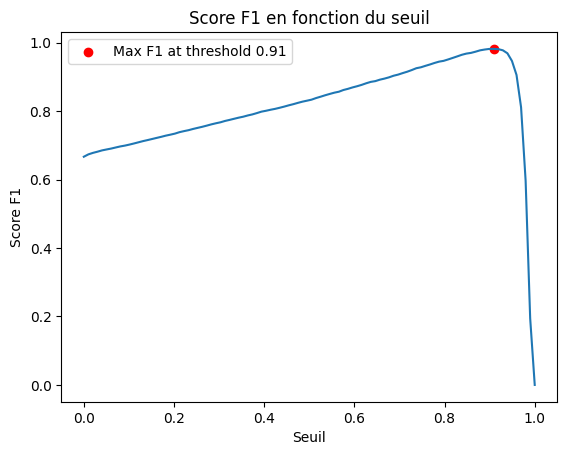

In [125]:
probas_pred = clf.predict_proba(X_test)[:, 1]

# Initialiser les listes pour stocker les résultats
threshold_array = np.linspace(0, 1, 100)
f1_list = []

# Calculer le F1 pour différents seuils
for threshold in threshold_array:
    # Labels prédits pour un seuil donné
    label_pred_threshold = (probas_pred > threshold).astype(int)
    # Calcul du f1 pour un seuil donné
    f1_threshold = f1_score(
        y_true=y_test, y_pred=label_pred_threshold
    )

    f1_list.append(f1_threshold)

# Trouver l'indice du maximum de la liste des scores F1
best_threshold_index = np.argmax(f1_list)

# Récupérer le seuil correspondant
best_threshold = threshold_array[best_threshold_index]

# Afficher le graphique
plt.plot(threshold_array, f1_list)
plt.xlabel('Seuil')
plt.ylabel('Score F1')
plt.title('Score F1 en fonction du seuil')
plt.scatter(best_threshold, f1_list[best_threshold_index], color='red', label=f'Max F1 at threshold {best_threshold:.2f}')
plt.legend()
plt.show()

# Utiliser le seuil optimal pour les prédictions
optimal_predictions = (probas_pred > best_threshold).astype(int)

In [126]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_with_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1] > best_threshold).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_with_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché avec le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché avec le seuil optimal: 0.2688028482421006


In [127]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_hide_test, predictions_with_optimal_threshold)
print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[40291  2111]
 [ 2818   906]]


In [128]:
# Prédire sur l'ensemble de test avec le seuil optimal
predictions_without_optimal_threshold = (clf.predict_proba(X_hide_test)[:, 1]).astype(int)

# Calculer le score F1 avec le seuil optimal
f1_optimal = f1_score(y_hide_test, predictions_without_optimal_threshold)

print(f"Score F1 sur l'ensemble de test caché sans le seuil optimal: {f1_optimal}")

Score F1 sur l'ensemble de test caché sans le seuil optimal: 0.0


## Submission

In [132]:
sub_preds = clf.predict_proba(df_test[feats])[:, 1]

# Créer un DataFrame final avec 'SK_ID_CURR' et les prédictions
submission_df = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': sub_preds})

submission_df.to_csv('submission.csv',index=False)

NotFittedError: Estimator not fitted, call fit before exploiting the model.